#Transfer Learning For Image Classification
In this notebook we use pre-trained resnet18 Convolutional Network.<br>

We have used the tutorials:
* "Quickstart tutorial" https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
*  "TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL", link: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html<br>


Notice: All weights are trainable, only initialized with a pretrained network, like the one that is trained on ImageNet, which contains 1.2 million images with 1000 categories.



###Import Packages

In [ ]:
#from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
from imutils import paths
import shutil
import re

plt.ion()   # interactive mode

###Mount your Google Drive to Colab
It is recommended to unmount your Google Drive when you finish

In [ ]:
drive.mount('/content/drive')
#drive.flush_and_unmount()


Mounted at /content/drive


### Build train and validation folders and load the images 
The training folder and validation folder consist 23 and 4 cats, respectively.<br>
Each folder consist two subfolders according to the classes:<br>
1) pain<br>
2) no_pain

In [ ]:
def copy_images(imagePaths, folder):
	# check if the destination folder exists and if not create it
	
	if os.path.exists(folder):
		shutil.rmtree(folder)
	os.makedirs(folder)
	# print('Folder created: ', folder)
  # loop over the image paths
	for path in imagePaths:
		# grab image name and its label from the path and create
		# a placeholder corresponding to the separate label folder
		imageName = path.split(os.path.sep)[-1]
		label = path.split(os.path.sep)[-2]
		labelFolder = os.path.join(folder, label)

		# check to see if the label folder exists and if not create it
		if not os.path.exists(labelFolder):
			os.makedirs(labelFolder)

		# construct the destination image path and copy the current
		# image to it
		destination = os.path.join(labelFolder, imageName)
		shutil.copy(path, destination)



###Load the data and create data augmentation
The batch size is set to be 4 (can be changed).<br>
The labels (pain, no_pain) are determined by the name of the folders.<br>
Only horizontal flip is applied.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation


def load_data(output_dir, batch_size, folder_names):
  data_transforms = {
      'train': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'test': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }
  image_datasets = {x: datasets.ImageFolder(os.path.join(output_dir, x),
                                            data_transforms[x])
                      for x in folder_names}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=2)
                  for x in folder_names}
  dataset_sizes = {x: len(image_datasets[x]) for x in folder_names}
  class_names = image_datasets['train'].classes
  print(dataset_sizes)
  #print(class_names)  
  return dataloaders, dataset_sizes, class_names

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


###Train and test functions for the model
A general function to train a model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, patience=15):
    since = time.time()
    train_losses = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    count_early_stopping = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses[epoch] = epoch_loss
              train_acc[epoch] = epoch_acc
            else:
              val_losses[epoch] = epoch_loss
              val_acc[epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val':
              # scheduler.step(epoch_loss) # changes lr according to val_loss
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                count_early_stopping=0
              else: count_early_stopping+=1
        if count_early_stopping==patience:
            print()
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, train_losses, train_acc, val_losses, val_acc 

Add a general test function:

In [ ]:
def test_model(dataloader, model, loss_fn, size=None):
    if not size:
      size = len(dataloader.dataset)
    #num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= size
    test_acc = correct/ size
    print(f'Test error: \nAverage loss: {test_loss:.2f} test accuracy: {test_acc*100:.1f}% \n')
    return test_loss, test_acc

In [ ]:
def plot_loss_acc (train_losses, train_acc, val_losses, val_acc, axes=None):
  
  mask_nonzero = np.nonzero(val_losses)
  if axes is None:
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize =(20,7))
    print('ax1 ',ax1)
  else: 
    ax1, ax2 = axes
    print(ax2)
  #plt.figure(figsize=(10,8))
  ax1.set_title("Training and Validation Loss")
  ax1.plot(val_losses[mask_nonzero],label="val", c='b')
  ax1.plot(train_losses[mask_nonzero],label="train", c='r')
  ax1.set_xlabel("iterations")
  ax1.set_ylabel("Loss")
  ax1.legend()
  #plt.show()

  #plt.figure(figsize=(10,4))
  ax2.set_title("Training and Validation Accuracy")
  ax2.plot(val_acc[mask_nonzero],label="val", c='b')
  ax2.plot(train_acc[mask_nonzero],label="train", c='r')
  ax2.set_xlabel("iterations")
  ax2.set_ylabel("Accuracy")
  ax2.legend()
  #plt.show()
  return (ax1, ax2)

###No cross validation:

In [ ]:
# load all the image paths and randomly shuffle them
data_dir = '/content/drive/MyDrive/cats'
split =0.85
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(data_dir))
imagePaths.sort()
# np.random.shuffle(imagePaths)

# generate training and validation paths
trainPathsLen = int((len(imagePaths) * split)/2)+2
halfLen = int((len(imagePaths)/2))
trainPaths = imagePaths[:trainPathsLen-8]+imagePaths[halfLen:(halfLen+trainPathsLen)-8]
valPaths = imagePaths[trainPathsLen+2:halfLen]+imagePaths[(halfLen+trainPathsLen)+2:]
testPaths = imagePaths[trainPathsLen-8:trainPathsLen+2]+imagePaths[halfLen+trainPathsLen-8:halfLen+trainPathsLen+2]
# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, '/content/train')
copy_images(valPaths,  '/content/val')
copy_images(testPaths, '/content/test')

[INFO] loading image paths...
[INFO] copying training and validation images...


In [ ]:
batch_size = 32
output_dir = '/content/'
folder_names = ["train", "val", "test"]
dataloaders, dataset_sizes, class_names = load_data(output_dir, batch_size, folder_names)

{'train': 382, 'val': 62, 'test': 20}


##Load dino
Load a pretrained model and reset final fully connected layer.

In [ ]:
# from torch.nn.modules.activation import ReLU
def load_model(model_name: str = 'dino_vits16', num_ftrs_last = 64 ,lr=0.001,step_size=10,flag_finetune=True):
  # load the model with pretrained parameters for transfer learning
  model = torch.hub.load('facebookresearch/dino:main', model_name)
  num_ftrs = model.embed_dim # dino

  if not flag_finetune: # Transfer learning - does not work for DINO
    for param in model.parameters():
          param.requires_grad = False
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  else: # finetuning
    head = nn.Sequential(
      nn.Linear(num_ftrs, num_ftrs_last),
      nn.ReLU(),
      nn.Dropout(0.15),
      nn.Linear(num_ftrs_last, 2))
    model.head = head

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  # optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  # Decay LR by a factor of gamma every step_size epochs
  scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=np.sqrt(0.1))
  # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
  # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

  return model, criterion, optimizer, scheduler

###a. Finetune without cross validation:

In [ ]:
model_dino, criterion, optimizer, scheduler= load_model('dino_vitb16',  lr=1e-6, step_size=20)
model_dino, best_acc_dino, train_losses_dino, train_acc_dino, val_losses_dino, val_acc_dino = train_model(model_dino, criterion, optimizer, scheduler, 
                                                                                              dataloaders, dataset_sizes, num_epochs=50, patience=15)

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase16_pretrain.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

Epoch 0/49
----------
train Loss: 10.2196 Acc: 0.0000
val Loss: 10.3018 Acc: 0.0000

Epoch 1/49
----------
train Loss: 9.3740 Acc: 0.0000
val Loss: 9.2078 Acc: 0.0000

Epoch 2/49
----------
train Loss: 8.2661 Acc: 0.0000
val Loss: 7.9916 Acc: 0.0323

Epoch 3/49
----------
train Loss: 7.0768 Acc: 0.0131
val Loss: 6.8030 Acc: 0.1452

Epoch 4/49
----------
train Loss: 5.9407 Acc: 0.0602
val Loss: 5.7896 Acc: 0.2097

Epoch 5/49
----------
train Loss: 4.8908 Acc: 0.1335
val Loss: 4.9834 Acc: 0.2742

Epoch 6/49
----------
train Loss: 4.1005 Acc: 0.2749
val Loss: 4.3678 Acc: 0.3387

Epoch 7/49
----------
train Loss: 3.5000 Acc: 0.3613
val Loss: 3.8705 Acc: 0.3548

Epoch 8/49
----------
train Loss: 3.0568 Acc: 0.3953
val Loss: 3.4363 Acc: 0.3710

Epoch 9/49
----------
train Loss: 2.6285 Acc: 0.4241
val Loss: 3.0298 Acc: 0.3871

Epoch 10/49
----------
train Loss: 2.2473 Acc: 0.4555
val Loss: 2.6554 Acc: 0.4194

Epoch 11/49
----------
train Loss: 1.9004 Acc: 0.4817
val Loss: 2.3092 Acc: 0.4032



In [ ]:
model_dino.head

Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.15, inplace=False)
  (3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
#for param in model_dino.parameters():
#  print(param)


In [ ]:
test_loss, test_acc = test_model(dataloaders['test'], model_dino, criterion)

Test error: 
Average loss: 0.05 test accuracy: 55.0% 



ax1  AxesSubplot(0.125,0.125;0.352273x0.755)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc980132810>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc9800be790>)

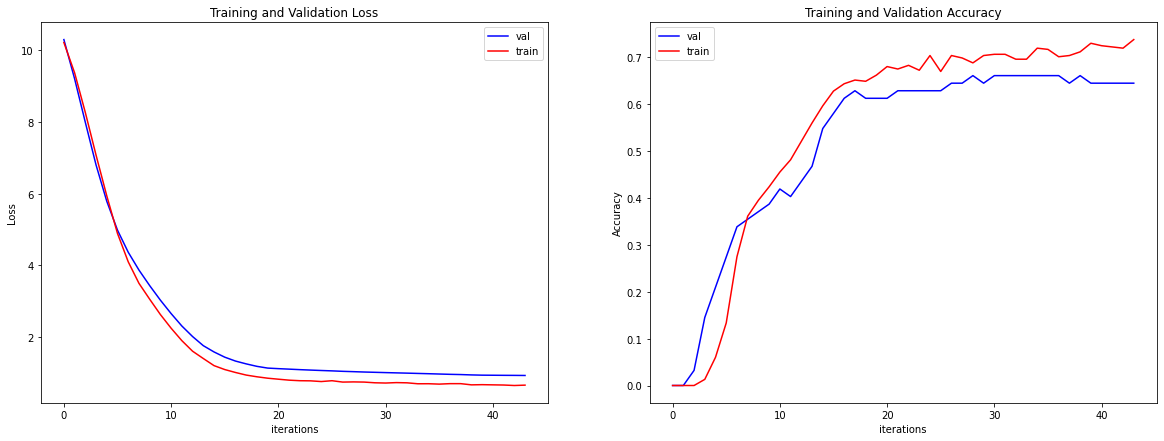

In [ ]:
plot_loss_acc ( train_losses_dino, train_acc_dino, val_losses_dino, val_acc_dino)

###Results of experiments
* lr 10^-6  3 layers:[128, 64, 2], 20 epoch, 10 decay-step, batch size 4: train:100 val:80.6 test:70. 
* lr 10^-6  2 layers: [64, 2], 50(30) epoch, 15 decay-step, batch size 4: train:99.7 val:72.5 test:75.
* lr 10^-6  2 layers: [64, 2], 50(30) epoch, 15 decay-step, batch size 4: train:95 val:76 test:65.
* lr 10^-6 2 layers: [64, 2], 50(29) epoch, 20 decay-step, batch size: 16: train:86 val:77 test:70. 
* VIT-B16: lr 10^-6 2 layers: [64, 2], 50(29) epoch, 20 decay-step, batch size: 16: train:71 val:65 test:55 (need larger decay step/ larger lr). 


###b. Transfer Learning without cross validation:
Freeze all weights and use eval_linear function from DINO for training

In [ ]:
model_tl = torch.hub.load('facebookresearch/dino:main', "dino_vits16")
#model_tl, criterion, optimizer, scheduler = load_model('dino_vits16', lr=0.001,step_size=10,flag_finetune=False)


Downloading: "https://github.com/facebookresearch/dino/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

In [ ]:
batch_size_tl = 500
output_dir = '/content/'
folder_names = ["train", "val", "test"]
dataloaders_tl, dataset_sizes_tl, class_names_tl = load_data(output_dir, batch_size_tl, folder_names)

{'train': 382, 'val': 62, 'test': 20}


In [ ]:
def eval_tl_model_knn(model, dataloader):
  model = model.to(device)
  model.eval()
  with torch.no_grad():
      for x, y in dataloader:
        x = x.to(device)
        pred = model_tl(x)
        print(pred.shape)
  return pred.cpu().numpy(), y.numpy()
train_features, train_labels = eval_tl_model_knn(model_tl, dataloaders_tl['train'])
val_features, val_labels = eval_tl_model_knn(model_tl, dataloaders_tl['val'])
test_features, test_labels = eval_tl_model_knn(model_tl, dataloaders_tl['test'])

torch.Size([382, 384])
torch.Size([62, 384])
torch.Size([20, 384])


#KNN classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
score_val =[]
score_test = []
for k in range(1,20,1):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(train_features, train_labels)
  score_val.append(knn.score(val_features, val_labels))
  score_test.append(knn.score(test_features, test_labels))
print('Validation results:\n',np.round(score_val,2))
print('Test results:\n', np.round(score_test,2))


Validation results:
 [0.79 0.81 0.74 0.71 0.73 0.76 0.73 0.74 0.71 0.76 0.76 0.77 0.69 0.76
 0.69 0.73 0.69 0.74 0.71]
Test results:
 [0.65 0.65 0.7  0.6  0.5  0.6  0.55 0.6  0.7  0.65 0.65 0.55 0.6  0.65
 0.65 0.65 0.65 0.65 0.65]


#One layer NN classifier

In [ ]:
from torch.utils.data import TensorDataset

def eval_tl_model(model, dataloader, batch_size):
  model = model.to(device)
  model.eval()
  with torch.no_grad():
      for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model_tl(x)
        print(pred.shape)
  #dataset_tl = TensorDataset(pred,y)
  # dataloader_tl = torch.utils.data.DataLoader(dataset_tl, num_workers=2, batch_size=batch_size)
  #print(dataloader_tl)
  return [(pred,y)]
#data_tl_train = eval_tl_model(model_tl, dataloaders_tl['train'], batch_size=500)
#data_tl_val = eval_tl_model(model_tl, dataloaders_tl['val'],batch_size=500)
#data_tl_test = eval_tl_model(model_tl, dataloaders_tl['test'], batch_size=500)
folder_names = ['train','val','test' ]
data_tl_dict =  {x: eval_tl_model(model_tl, dataloaders_tl[x], batch_size=500)
                  for x in folder_names}


torch.Size([382, 384])
torch.Size([62, 384])
torch.Size([20, 384])


In [ ]:
#model_tl = torch.hub.load('facebookresearch/dino:main', "dino_vits16")
def linear_head(features = 50, lr=0.001, momentum=0.9, step_size=20):
  model_linear = nn.Linear(features,2)
  model_linear = model_linear.to(device)
  criterion_tl = nn.CrossEntropyLoss()
  optimizer_tl = optim.SGD(model_linear.parameters(), lr=lr, momentum=momentum)
  # Decay LR by a factor of gamma every step_size epochs
  scheduler_tl = lr_scheduler.StepLR(optimizer_tl, step_size=step_size, gamma=np.sqrt(0.1))
  return model_linear,criterion_tl,optimizer_tl,scheduler_tl

In [ ]:
model_linear,criterion_tl,optimizer_tl,scheduler_tl = linear_head(features = model_tl.embed_dim, lr=0.001, momentum=0.9, step_size=20)
model_tl_linear, best_acc_linear, train_losses_linear, train_acc_linear, val_losses_linear, val_acc_linear = train_model(model_linear, 
                                                                                                                         criterion_tl, 
                                                                                                                         optimizer_tl, 
                                                                                                                         scheduler_tl, 
                                                                                                                         data_tl_dict, 
                                                                                                                         dataset_sizes_tl, 
                                                                                                                         num_epochs=500,
                                                                                                                         patience=30)

Epoch 0/499
----------
train Loss: 1.4453 Acc: 0.4764
val Loss: 1.1617 Acc: 0.4032

Epoch 1/499
----------
train Loss: 1.3495 Acc: 0.4843
val Loss: 1.0275 Acc: 0.5161

Epoch 2/499
----------
train Loss: 1.2260 Acc: 0.4791
val Loss: 0.9791 Acc: 0.5000

Epoch 3/499
----------
train Loss: 1.0394 Acc: 0.5000
val Loss: 0.9241 Acc: 0.5323

Epoch 4/499
----------
train Loss: 0.9124 Acc: 0.5445
val Loss: 0.8995 Acc: 0.6290

Epoch 5/499
----------
train Loss: 0.7858 Acc: 0.6073
val Loss: 0.9845 Acc: 0.5645

Epoch 6/499
----------
train Loss: 0.7361 Acc: 0.6387
val Loss: 0.9191 Acc: 0.5806

Epoch 7/499
----------
train Loss: 0.6744 Acc: 0.6361
val Loss: 0.8720 Acc: 0.6452

Epoch 8/499
----------
train Loss: 0.6463 Acc: 0.6623
val Loss: 0.9045 Acc: 0.6935

Epoch 9/499
----------
train Loss: 0.6004 Acc: 0.7225
val Loss: 0.9277 Acc: 0.6935

Epoch 10/499
----------
train Loss: 0.5831 Acc: 0.7408
val Loss: 0.8629 Acc: 0.7258

Epoch 11/499
----------
train Loss: 0.5569 Acc: 0.7487
val Loss: 0.8019 Acc

ax1  AxesSubplot(0.125,0.125;0.352273x0.755)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc98beefa90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc98321f150>)

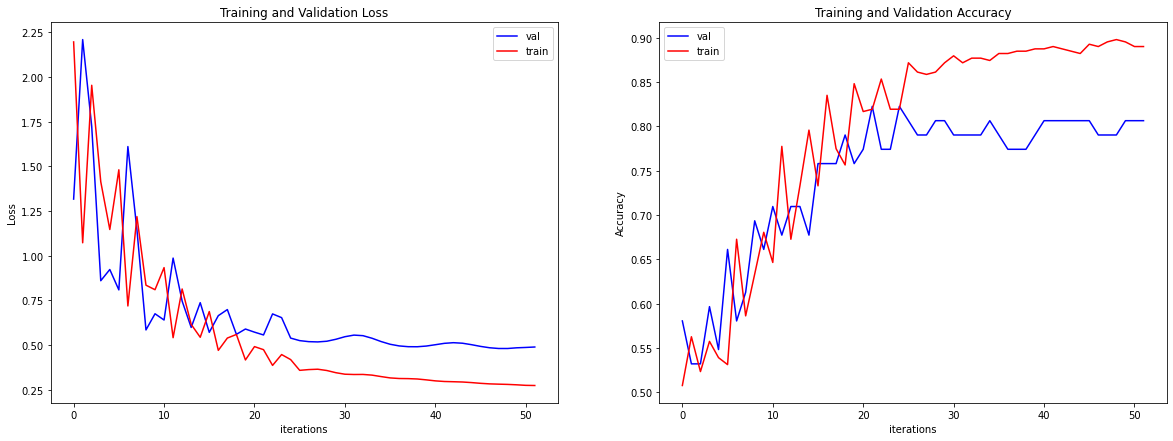

In [ ]:
plot_loss_acc(train_losses_linear, train_acc_linear, val_losses_linear, val_acc_linear )

In [ ]:
test_model(data_tl_dict['test'],model_linear,criterion_tl, size=dataset_sizes_tl['test'])

Test error: 
Average loss: 0.03 test accuracy: 70.0% 



(0.03320018947124481, 0.7)

##PCA

In [ ]:
#folder_names = ['train','val','test' ]
#data_tl_dict =  {x: eval_tl_model(model_tl, dataloaders_tl[x], batch_size=500)
#                  for x in folder_names}

In [ ]:
from sklearn.decomposition import PCA
def PCA_dino(data_tl_train, data_tl_val, data_tl_test, n_components=50):
  pca = PCA(n_components)
  data_tl_train_numpy = torch.Tensor.cpu(data_tl_train[0][0])
  data_tl_val_numpy = torch.Tensor.cpu(data_tl_val[0][0])
  data_tl_test_numpy = torch.Tensor.cpu(data_tl_test[0][0])

  train_transform = pca.fit_transform(data_tl_train_numpy)
  val_transform = pca.transform(data_tl_val_numpy)
  test_transform = pca.transform(data_tl_test_numpy)
  print("Variance ratio:", pca.explained_variance_ratio_)
  data_tl_pca_dict = { 'train': [(torch.Tensor(train_transform).to(device), data_tl_train[0][1])] , 
                    'val': [(torch.Tensor(val_transform).to(device), data_tl_val[0][1])],
                   'test': [(torch.Tensor(test_transform).to(device), data_tl_test[0][1])] }
  return data_tl_pca_dict


In [ ]:
n_components = 50
data_tl_pca_dict= PCA_dino(data_tl_dict['train'], data_tl_dict['val'], data_tl_dict['test'], n_components)

Variance ratio: [0.20378581 0.09030942 0.07870187 0.04346632 0.03750564 0.03442852
 0.02965099 0.02686722 0.02193382 0.01841329 0.01751341 0.01400853
 0.01327629 0.01310423 0.01191023 0.01109452 0.01046117 0.00975693
 0.00956102 0.00929161 0.0087041  0.00834888 0.007854   0.00750755
 0.00729636 0.00670638 0.00649289 0.00593408 0.00570302 0.00549575
 0.00527909 0.00513302 0.00501555 0.00469854 0.00446513 0.0043255
 0.00424299 0.00416138 0.00403397 0.00383995 0.00376278 0.00349007
 0.00342405 0.00341402 0.00327244 0.00322705 0.00315353 0.00303023
 0.00291223 0.00289303]


In [ ]:
model_linear_pca,criterion_tl_pca,optimizer_tl_pca,scheduler_tl_pca = linear_head(features = n_components, lr=0.001, momentum=0.9, step_size=20)
model_tl_linear_pca, best_acc_linear_pca, train_losses_linear_pca, train_acc_linear_pca, val_losses_linear_pca, val_acc_linear_pca = train_model(model_linear_pca, 
                                                                                                                         criterion_tl, 
                                                                                                                         optimizer_tl_pca, 
                                                                                                                         scheduler_tl_pca, 
                                                                                                                         data_tl_pca_dict, 
                                                                                                                         dataset_sizes_tl, 
                                                                                                                         num_epochs=500,
                                                                                                                         patience=30)

Epoch 0/499
----------
train Loss: 1.9529 Acc: 0.5890
val Loss: 2.1052 Acc: 0.4839

Epoch 1/499
----------
train Loss: 1.9031 Acc: 0.5969
val Loss: 1.9454 Acc: 0.4839

Epoch 2/499
----------
train Loss: 1.8121 Acc: 0.6073
val Loss: 1.7405 Acc: 0.5000

Epoch 3/499
----------
train Loss: 1.6908 Acc: 0.6099
val Loss: 1.5211 Acc: 0.5161

Epoch 4/499
----------
train Loss: 1.5510 Acc: 0.6073
val Loss: 1.3163 Acc: 0.5000

Epoch 5/499
----------
train Loss: 1.4046 Acc: 0.5916
val Loss: 1.1516 Acc: 0.5484

Epoch 6/499
----------
train Loss: 1.2639 Acc: 0.6099
val Loss: 1.0447 Acc: 0.6290

Epoch 7/499
----------
train Loss: 1.1393 Acc: 0.6335
val Loss: 0.9992 Acc: 0.6290

Epoch 8/499
----------
train Loss: 1.0381 Acc: 0.6623
val Loss: 1.0096 Acc: 0.6613

Epoch 9/499
----------
train Loss: 0.9665 Acc: 0.6859
val Loss: 1.0583 Acc: 0.6774

Epoch 10/499
----------
train Loss: 0.9234 Acc: 0.6963
val Loss: 1.1182 Acc: 0.6452

Epoch 11/499
----------
train Loss: 0.8977 Acc: 0.7147
val Loss: 1.1657 Acc

ax1  AxesSubplot(0.125,0.125;0.352273x0.755)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc75fac1ed0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc75fb78a90>)

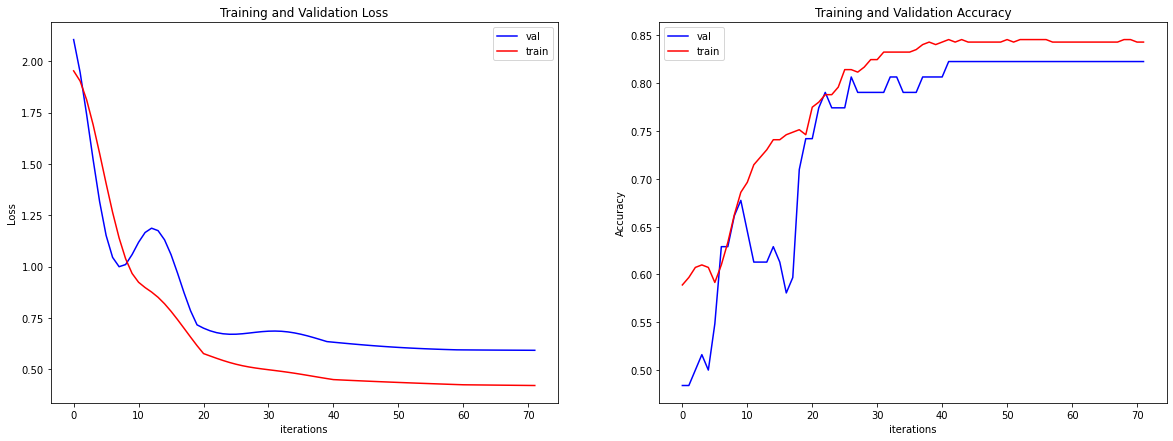

In [ ]:
plot_loss_acc(train_losses_linear_pca, train_acc_linear_pca, val_losses_linear_pca, val_acc_linear_pca )

In [ ]:
test_model(data_tl_pca_dict['test'],model_linear_pca,criterion_tl, size=dataset_sizes_tl['test'])

Test error: 
Average loss: 0.03 test accuracy: 75.0% 



(0.025235724449157716, 0.75)

In [ ]:
for parameter in model_linear_pca.parameters():
    print(parameter)

Parameter containing:
tensor([[-7.7649e-02,  3.4504e-02,  1.1399e-01,  1.0440e-01, -4.3437e-03,
          6.0727e-02, -7.7852e-02, -1.1087e-01,  8.2584e-02, -1.4629e-01,
         -1.6794e-02,  4.1412e-02,  7.0396e-02, -9.1548e-02,  1.2249e-01,
         -6.5425e-03, -1.0757e-01,  3.4235e-02, -5.1778e-02,  7.4926e-03,
          8.2432e-02, -5.3134e-02,  8.8154e-02, -6.1862e-02,  7.7941e-02,
          3.8836e-02, -1.5634e-02,  3.0117e-02, -2.7117e-02, -4.0797e-02,
          3.2118e-02,  1.0120e-01, -6.6556e-02, -1.0414e-01, -9.4848e-02,
          6.5315e-02, -2.3530e-02, -2.8377e-02, -6.6344e-02, -5.0859e-02,
          6.9073e-02, -8.7445e-02, -1.2732e-01,  1.8919e-03,  5.4899e-02,
         -7.7556e-02, -8.7442e-02,  7.6756e-02, -8.6716e-02, -4.9987e-02],
        [-8.7281e-02,  1.9968e-02,  1.2321e-01, -2.1556e-02,  7.3921e-02,
          1.0721e-01,  1.3741e-01,  4.6889e-02,  1.1312e-04, -5.8550e-02,
          4.3791e-02, -6.8331e-03,  6.1373e-02, -3.4950e-03,  9.0547e-02,
         -3.496

# Cross validation

One vs. all cross validation and train each time a new model. Run for all cats  - each time one cat in test, and n_val cats in validation.
Predict the test result for each cat, and return mean test accuracy.

In [ ]:
np.random.seed(42) # remove for random results!!!!!

def create_sets(image_paths, unique_inverse, val_index, test_index, n_val, n_images):
  # test
  test_mask= np.isin(unique_inverse, test_index)
  test_indexes = np.flatnonzero(test_mask) 
  test_paths = [image_paths[index] for index in test_indexes]
  # validation
  val_mask= np.isin(unique_inverse, val_index)
  val_indexes = np.flatnonzero(val_mask) 
  val_paths = [image_paths[index] for index in val_indexes]
  # train
  train_indexes = np.flatnonzero(np.logical_not(test_mask | val_mask)) 
  train_paths = [image_paths[index] for index in train_indexes]
  print(f'test fraction: {len(test_paths)/n_images: .2f}')
  print(f'validation fraction: {len(val_paths)/n_images: .2f}')
  print(f'train fraction: {len(train_paths)/n_images: .2f}')
  return {'train':train_paths, 'val': val_paths, 'test': test_paths}

def cross_validation_train(data_dir, output_dir, model_name, n_val, batch_size, 
                           folder_names={'test', 'val', 'train'}, num_epochs=25, patience=10, lr=0.0001, step_size =10, finetune=True, n_pca_components=None):
  since = time.time() 
  image_paths = list(paths.list_images(data_dir))
  n_images = len(image_paths)
  image_paths.sort()
  # build an array of cat/object numbers
  object_number_vec =np.array([int(re.search(r'-?\d+', path)[0]) for path in image_paths ]) 
  [object_number_unique, unique_inverse]= np.unique(object_number_vec, return_inverse=True)
  n_objects = len(object_number_unique)
  object_index_unique = np.unique(unique_inverse)  
  test_loss = np.zeros(n_objects)
  test_acc = np.zeros(n_objects)
  val_acc = np.zeros(n_objects)
  axes = None
  save_folder='/content/drive/MyDrive/models/'
  if not os.path.exists(save_folder):
    os.mkdir(save_folder)
  
  for k_object in range(n_objects):# [3]:   # for testing replace n_objects to a number for only few cats, e.g. range(5)
      object_number= object_number_unique[k_object]
      print('\nCat number for test: ',object_number ,' index: ', k_object)
      # load initial weights
      #model.load_state_dict(torch.load(file_initial_weights))
      #model.to(device) 
      model, criterion, optimizer_ft, exp_lr_scheduler = load_model(model_name, lr=lr, step_size =step_size, flag_finetune=finetune)
      # Create data loaders
      train_and_val = object_index_unique[object_index_unique != k_object]
      val_indexes = np.random.choice(train_and_val, n_val, replace=False)
      #val_indexes =[4,5,6,7]
      print('Validation cats: ', object_number_unique[val_indexes])
      dict_paths = create_sets(image_paths, unique_inverse, val_indexes, k_object, n_val, n_images)
      for name in folder_names:
        copy_images(dict_paths[name], os.path.join(output_dir, name))
      dataloaders, dataset_sizes, class_names = load_data(output_dir, batch_size, folder_names)
      if not finetune:
        input_dict =  {x: eval_tl_model(model_tl, dataloaders[x], batch_size=500)
                  for x in folder_names}
        if n_pca_components:
          input_dict= PCA_dino(input_dict['train'], input_dict['val'], input_dict['test'], n_pca_components)
          features = n_pca_components
        else: 
          features = model.embed_dim
        model,criterion,optimizer,scheduler = linear_head(features, lr=lr, step_size=step_size)
      else:
        input_dict = dataloaders
      dataloader_test = input_dict.pop('test')
      # train
      model_best, val_acc[k_object],train_losses_, train_acc_, val_losses_, val_acc_vec  = train_model(model, criterion, optimizer, exp_lr_scheduler, 
                                input_dict,dataset_sizes, num_epochs, patience)
      # test
      test_loss[k_object], test_acc[k_object] = test_model(dataloader_test, model_best, criterion,dataset_sizes['test'])
      # plot
      axes = plot_loss_acc(train_losses_, train_acc_, val_losses_, val_acc_vec, axes)

      # Calculate and print accuracy means
      val_acc_mean = val_acc[np.nonzero(val_acc)].mean()
      test_acc_mean = test_acc[np.nonzero(test_acc)].mean()
      print(f'\nMean validation accuracy till {k_object+1}: {100*val_acc_mean:.2f}%')
      print(f'Mean test accuracy till {k_object+1}: {100*test_acc_mean:.2f}%')
      # Save model
      model_file_name =f'/content/drive/MyDrive/models/model{k_object}_cat{object_number}_test_ac{100*test_acc[k_object]:.0f}.pth'
      torch.save(model.state_dict(), model_file_name)
      print('Saved PyTorch model state to ', model_file_name)
  time_elapsed = time.time() - since
  print(f'\nCross validation finished, time elappsed {time_elapsed // 60 :.0f}m {time_elapsed % 60 : .0f}s')
  #model.load_state_dict(initial_model_wts)
  test_acc_mean = test_acc[np.nonzero(test_acc)].mean()
  print(f'Total mean test accuracy: {100*test_acc_mean:.2f}%')
  return test_loss, test_acc, val_acc

##a. Finetune training with cross validation


Cat number for test:  1  index:  0


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [11 21  3 29]
test fraction:  0.02
validation fraction:  0.11
train fraction:  0.88
{'train': 406, 'test': 8, 'val': 50}
Epoch 0/34
----------
train Loss: 2.5720 Acc: 0.4901
val Loss: 1.1895 Acc: 0.6200

Epoch 1/34
----------
train Loss: 0.5777 Acc: 0.7537
val Loss: 0.9408 Acc: 0.6800

Epoch 2/34
----------
train Loss: 0.4219 Acc: 0.8153
val Loss: 1.0689 Acc: 0.7800

Epoch 3/34
----------
train Loss: 0.2301 Acc: 0.9113
val Loss: 1.2091 Acc: 0.5200

Epoch 4/34
----------
train Loss: 0.1747 Acc: 0.9360
val Loss: 1.1772 Acc: 0.6800

Epoch 5/34
----------
train Loss: 0.1408 Acc: 0.9631
val Loss: 1.2951 Acc: 0.6600

Epoch 6/34
----------
train Loss: 0.0966 Acc: 0.9778
val Loss: 1.1740 Acc: 0.6400

Epoch 7/34
----------
train Loss: 0.0635 Acc: 0.9926
val Loss: 1.2997 Acc: 0.6400

Epoch 8/34
----------
train Loss: 0.0397 Acc: 1.0000
val Loss: 1.3590 Acc: 0.6400

Epoch 9/34
----------
train Loss: 0.0518 Acc: 0.9926
val Loss: 1.5219 Acc: 0.6200

Epoch 10/34
----------
train Lo

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 13 10 16]
test fraction:  0.01
validation fraction:  0.19
train fraction:  0.80
{'train': 370, 'test': 4, 'val': 90}
Epoch 0/34
----------
train Loss: 2.6632 Acc: 0.4595
val Loss: 1.1419 Acc: 0.5778

Epoch 1/34
----------
train Loss: 0.5971 Acc: 0.7459
val Loss: 1.2175 Acc: 0.5778

Epoch 2/34
----------
train Loss: 0.3742 Acc: 0.8649
val Loss: 0.8420 Acc: 0.6778

Epoch 3/34
----------
train Loss: 0.2529 Acc: 0.8865
val Loss: 0.8490 Acc: 0.6556

Epoch 4/34
----------
train Loss: 0.1804 Acc: 0.9486
val Loss: 0.8315 Acc: 0.6444

Epoch 5/34
----------
train Loss: 0.1111 Acc: 0.9784
val Loss: 0.8772 Acc: 0.6444

Epoch 6/34
----------
train Loss: 0.0802 Acc: 0.9892
val Loss: 0.8298 Acc: 0.6667

Epoch 7/34
----------
train Loss: 0.0808 Acc: 0.9865
val Loss: 0.9112 Acc: 0.6333

Epoch 8/34
----------
train Loss: 0.0584 Acc: 0.9973
val Loss: 0.8233 Acc: 0.6556

Epoch 9/34
----------
train Loss: 0.0476 Acc: 0.9919
val Loss: 0.8586 Acc: 0.6667

Epoch 10/34
----------
train Lo

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [20 26 16 22]
test fraction:  0.01
validation fraction:  0.17
train fraction:  0.82
{'train': 382, 'test': 4, 'val': 78}
Epoch 0/34
----------
train Loss: 2.5365 Acc: 0.4974
val Loss: 1.0690 Acc: 0.6154

Epoch 1/34
----------
train Loss: 0.5460 Acc: 0.7984
val Loss: 1.6656 Acc: 0.5641

Epoch 2/34
----------
train Loss: 0.3448 Acc: 0.8639
val Loss: 0.9424 Acc: 0.6282

Epoch 3/34
----------
train Loss: 0.2175 Acc: 0.9215
val Loss: 0.9750 Acc: 0.6282

Epoch 4/34
----------
train Loss: 0.1419 Acc: 0.9634
val Loss: 0.9832 Acc: 0.6410

Epoch 5/34
----------
train Loss: 0.1065 Acc: 0.9686
val Loss: 0.9757 Acc: 0.6538

Epoch 6/34
----------
train Loss: 0.0687 Acc: 0.9948
val Loss: 0.9725 Acc: 0.6538

Epoch 7/34
----------
train Loss: 0.0572 Acc: 0.9948
val Loss: 1.0065 Acc: 0.6538

Epoch 8/34
----------
train Loss: 0.0473 Acc: 0.9974
val Loss: 0.9757 Acc: 0.6538

Epoch 9/34
----------
train Loss: 0.0427 Acc: 0.9974
val Loss: 1.0132 Acc: 0.6538

Epoch 10/34
----------
train Lo

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [22 27  4  8]
test fraction:  0.04
validation fraction:  0.13
train fraction:  0.83
{'train': 384, 'test': 20, 'val': 60}
Epoch 0/34
----------
train Loss: 2.5125 Acc: 0.4896
val Loss: 1.3918 Acc: 0.4667

Epoch 1/34
----------
train Loss: 0.5066 Acc: 0.7708
val Loss: 1.5934 Acc: 0.5333

Epoch 2/34
----------
train Loss: 0.3046 Acc: 0.8672
val Loss: 1.4415 Acc: 0.5167

Epoch 3/34
----------
train Loss: 0.2204 Acc: 0.9245
val Loss: 1.3070 Acc: 0.5500

Epoch 4/34
----------
train Loss: 0.1401 Acc: 0.9714
val Loss: 1.3010 Acc: 0.5500

Epoch 5/34
----------
train Loss: 0.0951 Acc: 0.9844
val Loss: 1.3445 Acc: 0.5333

Epoch 6/34
----------
train Loss: 0.0596 Acc: 0.9974
val Loss: 1.2071 Acc: 0.5667

Epoch 7/34
----------
train Loss: 0.0559 Acc: 0.9922
val Loss: 1.3249 Acc: 0.5333

Epoch 8/34
----------
train Loss: 0.0443 Acc: 0.9974
val Loss: 1.2802 Acc: 0.5667

Epoch 9/34
----------
train Loss: 0.0320 Acc: 1.0000
val Loss: 1.3676 Acc: 0.5500

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 8 18 24 19]
test fraction:  0.05
validation fraction:  0.17
train fraction:  0.78
{'train': 364, 'test': 22, 'val': 78}
Epoch 0/34
----------
train Loss: 2.7133 Acc: 0.4918
val Loss: 1.3600 Acc: 0.4872

Epoch 1/34
----------
train Loss: 0.6697 Acc: 0.7198
val Loss: 1.1849 Acc: 0.5897

Epoch 2/34
----------
train Loss: 0.3819 Acc: 0.8242
val Loss: 0.9972 Acc: 0.5897

Epoch 3/34
----------
train Loss: 0.2740 Acc: 0.8901
val Loss: 1.3386 Acc: 0.5769

Epoch 4/34
----------
train Loss: 0.1969 Acc: 0.9313
val Loss: 0.9554 Acc: 0.6538

Epoch 5/34
----------
train Loss: 0.1408 Acc: 0.9753
val Loss: 1.0077 Acc: 0.6026

Epoch 6/34
----------
train Loss: 0.0988 Acc: 0.9808
val Loss: 1.0393 Acc: 0.6795

Epoch 7/34
----------
train Loss: 0.0853 Acc: 0.9863
val Loss: 1.0377 Acc: 0.6410

Epoch 8/34
----------
train Loss: 0.0720 Acc: 0.9863
val Loss: 1.0569 Acc: 0.6154

Epoch 9/34
----------
train Loss: 0.0494 Acc: 1.0000
val Loss: 1.0842 Acc: 0.6538

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16 21 20  5]
test fraction:  0.01
validation fraction:  0.14
train fraction:  0.85
{'train': 394, 'test': 4, 'val': 66}
Epoch 0/34
----------
train Loss: 2.5692 Acc: 0.4873
val Loss: 0.6868 Acc: 0.7121

Epoch 1/34
----------
train Loss: 0.6320 Acc: 0.7259
val Loss: 0.4790 Acc: 0.7273

Epoch 2/34
----------
train Loss: 0.3583 Acc: 0.8579
val Loss: 0.6893 Acc: 0.7424

Epoch 3/34
----------
train Loss: 0.2783 Acc: 0.8807
val Loss: 1.0592 Acc: 0.6364

Epoch 4/34
----------
train Loss: 0.1794 Acc: 0.9416
val Loss: 0.7300 Acc: 0.7576

Epoch 5/34
----------
train Loss: 0.1136 Acc: 0.9797
val Loss: 0.6425 Acc: 0.7576

Epoch 6/34
----------
train Loss: 0.1003 Acc: 0.9772
val Loss: 0.5480 Acc: 0.7879

Epoch 7/34
----------
train Loss: 0.0630 Acc: 0.9975
val Loss: 0.6868 Acc: 0.7727

Epoch 8/34
----------
train Loss: 0.0476 Acc: 0.9975
val Loss: 0.7231 Acc: 0.7576

Epoch 9/34
----------
train Loss: 0.0373 Acc: 0.9975
val Loss: 0.5256 Acc: 0.8182

Epoch 10/34
----------
train Lo

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 1 20 18 10]
test fraction:  0.03
validation fraction:  0.13
train fraction:  0.84
{'train': 390, 'test': 12, 'val': 62}
Epoch 0/34
----------
train Loss: 2.5259 Acc: 0.4872
val Loss: 1.2810 Acc: 0.4839

Epoch 1/34
----------
train Loss: 0.5928 Acc: 0.7359
val Loss: 1.1844 Acc: 0.5968

Epoch 2/34
----------
train Loss: 0.3379 Acc: 0.8615
val Loss: 1.0428 Acc: 0.6452

Epoch 3/34
----------
train Loss: 0.2580 Acc: 0.8923
val Loss: 0.9357 Acc: 0.6129

Epoch 4/34
----------
train Loss: 0.1473 Acc: 0.9615
val Loss: 0.9935 Acc: 0.7258

Epoch 5/34
----------
train Loss: 0.1225 Acc: 0.9692
val Loss: 1.0553 Acc: 0.6774

Epoch 6/34
----------
train Loss: 0.0744 Acc: 0.9949
val Loss: 0.9171 Acc: 0.7258

Epoch 7/34
----------
train Loss: 0.0550 Acc: 1.0000
val Loss: 1.0482 Acc: 0.7097

Epoch 8/34
----------
train Loss: 0.0553 Acc: 0.9897
val Loss: 1.0550 Acc: 0.7258

Epoch 9/34
----------
train Loss: 0.0377 Acc: 1.0000
val Loss: 0.9663 Acc: 0.7419

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [25  3 14  5]
test fraction:  0.05
validation fraction:  0.16
train fraction:  0.79
{'train': 366, 'test': 24, 'val': 74}
Epoch 0/34
----------
train Loss: 2.7152 Acc: 0.4563
val Loss: 0.6670 Acc: 0.7568

Epoch 1/34
----------
train Loss: 0.5813 Acc: 0.7104
val Loss: 0.6297 Acc: 0.7703

Epoch 2/34
----------
train Loss: 0.3240 Acc: 0.8689
val Loss: 0.6256 Acc: 0.7297

Epoch 3/34
----------
train Loss: 0.2661 Acc: 0.8934
val Loss: 0.5998 Acc: 0.7973

Epoch 4/34
----------
train Loss: 0.1931 Acc: 0.9262
val Loss: 0.5074 Acc: 0.8243

Epoch 5/34
----------
train Loss: 0.1287 Acc: 0.9645
val Loss: 0.5327 Acc: 0.7973

Epoch 6/34
----------
train Loss: 0.1088 Acc: 0.9699
val Loss: 0.5728 Acc: 0.8378

Epoch 7/34
----------
train Loss: 0.0891 Acc: 0.9781
val Loss: 0.4874 Acc: 0.8108

Epoch 8/34
----------
train Loss: 0.0560 Acc: 0.9945
val Loss: 0.5153 Acc: 0.7973

Epoch 9/34
----------
train Loss: 0.0491 Acc: 0.9945
val Loss: 0.5319 Acc: 0.8243

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [11 20  5 16]
test fraction:  0.04
validation fraction:  0.15
train fraction:  0.81
{'train': 374, 'test': 20, 'val': 70}
Epoch 0/34
----------
train Loss: 2.7531 Acc: 0.4599
val Loss: 0.8949 Acc: 0.6571

Epoch 1/34
----------
train Loss: 0.6470 Acc: 0.7005
val Loss: 0.8377 Acc: 0.6571

Epoch 2/34
----------
train Loss: 0.3575 Acc: 0.8476
val Loss: 1.1514 Acc: 0.6000

Epoch 3/34
----------
train Loss: 0.2297 Acc: 0.9091
val Loss: 0.9857 Acc: 0.6143

Epoch 4/34
----------
train Loss: 0.1646 Acc: 0.9465
val Loss: 0.9457 Acc: 0.7143

Epoch 5/34
----------
train Loss: 0.1073 Acc: 0.9840
val Loss: 1.0400 Acc: 0.6857

Epoch 6/34
----------
train Loss: 0.0845 Acc: 0.9893
val Loss: 0.9984 Acc: 0.7000

Epoch 7/34
----------
train Loss: 0.0761 Acc: 0.9840
val Loss: 1.0036 Acc: 0.7000

Epoch 8/34
----------
train Loss: 0.0544 Acc: 0.9947
val Loss: 1.1678 Acc: 0.5857

Epoch 9/34
----------
train Loss: 0.0406 Acc: 1.0000
val Loss: 1.0150 Acc: 0.6857

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 18 22 12]
test fraction:  0.03
validation fraction:  0.18
train fraction:  0.79
{'train': 366, 'test': 14, 'val': 84}
Epoch 0/34
----------
train Loss: 2.5228 Acc: 0.4918
val Loss: 1.2562 Acc: 0.5595

Epoch 1/34
----------
train Loss: 0.5490 Acc: 0.7787
val Loss: 1.2113 Acc: 0.5476

Epoch 2/34
----------
train Loss: 0.3682 Acc: 0.8552
val Loss: 1.0061 Acc: 0.6071

Epoch 3/34
----------
train Loss: 0.2197 Acc: 0.9208
val Loss: 1.0380 Acc: 0.6429

Epoch 4/34
----------
train Loss: 0.1547 Acc: 0.9454
val Loss: 1.0265 Acc: 0.6548

Epoch 5/34
----------
train Loss: 0.1177 Acc: 0.9727
val Loss: 0.8833 Acc: 0.6786

Epoch 6/34
----------
train Loss: 0.0785 Acc: 0.9891
val Loss: 1.0507 Acc: 0.6786

Epoch 7/34
----------
train Loss: 0.0634 Acc: 0.9891
val Loss: 1.0474 Acc: 0.6548

Epoch 8/34
----------
train Loss: 0.0491 Acc: 0.9945
val Loss: 1.0429 Acc: 0.6548

Epoch 9/34
----------
train Loss: 0.0374 Acc: 1.0000
val Loss: 1.0312 Acc: 0.6786

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [18  7  6 21]
test fraction:  0.03
validation fraction:  0.13
train fraction:  0.84
{'train': 390, 'test': 12, 'val': 62}
Epoch 0/34
----------
train Loss: 2.5335 Acc: 0.4846
val Loss: 1.0311 Acc: 0.6290

Epoch 1/34
----------
train Loss: 0.7554 Acc: 0.6923
val Loss: 0.7159 Acc: 0.6935

Epoch 2/34
----------
train Loss: 0.3754 Acc: 0.8308
val Loss: 0.6166 Acc: 0.7581

Epoch 3/34
----------
train Loss: 0.2678 Acc: 0.8846
val Loss: 0.6338 Acc: 0.7419

Epoch 4/34
----------
train Loss: 0.2090 Acc: 0.9308
val Loss: 0.5755 Acc: 0.7742

Epoch 5/34
----------
train Loss: 0.1429 Acc: 0.9615
val Loss: 0.5730 Acc: 0.8226

Epoch 6/34
----------
train Loss: 0.1100 Acc: 0.9744
val Loss: 0.5842 Acc: 0.8065

Epoch 7/34
----------
train Loss: 0.0706 Acc: 0.9974
val Loss: 0.5384 Acc: 0.8226

Epoch 8/34
----------
train Loss: 0.0602 Acc: 1.0000
val Loss: 0.5095 Acc: 0.7903

Epoch 9/34
----------
train Loss: 0.0694 Acc: 0.9897
val Loss: 0.5758 Acc: 0.7581

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 8 26 11  3]
test fraction:  0.05
validation fraction:  0.10
train fraction:  0.85
{'train': 396, 'test': 22, 'val': 46}
Epoch 0/34
----------
train Loss: 2.5338 Acc: 0.4773
val Loss: 0.9190 Acc: 0.6304

Epoch 1/34
----------
train Loss: 0.7504 Acc: 0.6843
val Loss: 1.1739 Acc: 0.6087

Epoch 2/34
----------
train Loss: 0.4175 Acc: 0.8157
val Loss: 0.7896 Acc: 0.6304

Epoch 3/34
----------
train Loss: 0.2827 Acc: 0.8914
val Loss: 1.0868 Acc: 0.6087

Epoch 4/34
----------
train Loss: 0.2015 Acc: 0.9394
val Loss: 0.7607 Acc: 0.6522

Epoch 5/34
----------
train Loss: 0.1454 Acc: 0.9571
val Loss: 1.0852 Acc: 0.6304

Epoch 6/34
----------
train Loss: 0.0949 Acc: 0.9848
val Loss: 0.9375 Acc: 0.6304

Epoch 7/34
----------
train Loss: 0.0792 Acc: 0.9899
val Loss: 1.0501 Acc: 0.6522

Epoch 8/34
----------
train Loss: 0.0712 Acc: 0.9924
val Loss: 1.2433 Acc: 0.5870

Epoch 9/34
----------
train Loss: 0.0453 Acc: 0.9975
val Loss: 1.0340 Acc: 0.6522

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 7 25 16 11]
test fraction:  0.06
validation fraction:  0.15
train fraction:  0.79
{'train': 368, 'test': 26, 'val': 70}
Epoch 0/34
----------
train Loss: 2.6467 Acc: 0.4457
val Loss: 0.7359 Acc: 0.6429

Epoch 1/34
----------
train Loss: 0.5830 Acc: 0.7554
val Loss: 0.6793 Acc: 0.7000

Epoch 2/34
----------
train Loss: 0.3928 Acc: 0.8152
val Loss: 0.9421 Acc: 0.6714

Epoch 3/34
----------
train Loss: 0.2683 Acc: 0.8832
val Loss: 0.9827 Acc: 0.6286

Epoch 4/34
----------
train Loss: 0.1729 Acc: 0.9402
val Loss: 0.8928 Acc: 0.6286

Epoch 5/34
----------
train Loss: 0.1362 Acc: 0.9565
val Loss: 0.8526 Acc: 0.6857

Epoch 6/34
----------
train Loss: 0.1165 Acc: 0.9565
val Loss: 0.8649 Acc: 0.6429

Epoch 7/34
----------
train Loss: 0.0779 Acc: 0.9918
val Loss: 0.8559 Acc: 0.7000

Epoch 8/34
----------
train Loss: 0.0577 Acc: 0.9946
val Loss: 0.8299 Acc: 0.6714

Epoch 9/34
----------
train Loss: 0.0463 Acc: 1.0000
val Loss: 0.9546 Acc: 0.6714

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [10 29 22 25]
test fraction:  0.06
validation fraction:  0.20
train fraction:  0.74
{'train': 344, 'test': 28, 'val': 92}
Epoch 0/34
----------
train Loss: 2.5921 Acc: 0.4738
val Loss: 1.5828 Acc: 0.5000

Epoch 1/34
----------
train Loss: 0.5614 Acc: 0.7762
val Loss: 1.4124 Acc: 0.5761

Epoch 2/34
----------
train Loss: 0.2902 Acc: 0.8721
val Loss: 1.3443 Acc: 0.6413

Epoch 3/34
----------
train Loss: 0.2208 Acc: 0.9099
val Loss: 1.4553 Acc: 0.5978

Epoch 4/34
----------
train Loss: 0.1341 Acc: 0.9622
val Loss: 1.3584 Acc: 0.6413

Epoch 5/34
----------
train Loss: 0.0982 Acc: 0.9797
val Loss: 1.4486 Acc: 0.5870

Epoch 6/34
----------
train Loss: 0.0675 Acc: 0.9884
val Loss: 1.4326 Acc: 0.6413

Epoch 7/34
----------
train Loss: 0.0476 Acc: 1.0000
val Loss: 1.4327 Acc: 0.6196

Epoch 8/34
----------
train Loss: 0.0367 Acc: 1.0000
val Loss: 1.4513 Acc: 0.6413

Epoch 9/34
----------
train Loss: 0.0282 Acc: 1.0000
val Loss: 1.4771 Acc: 0.6522

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 9 20 23 11]
test fraction:  0.06
validation fraction:  0.14
train fraction:  0.80
{'train': 372, 'test': 26, 'val': 66}
Epoch 0/34
----------
train Loss: 2.6356 Acc: 0.4570
val Loss: 1.0975 Acc: 0.5909

Epoch 1/34
----------
train Loss: 0.5624 Acc: 0.7500
val Loss: 0.7792 Acc: 0.6970

Epoch 2/34
----------
train Loss: 0.3400 Acc: 0.8468
val Loss: 0.8244 Acc: 0.6667

Epoch 3/34
----------
train Loss: 0.2316 Acc: 0.9247
val Loss: 1.0357 Acc: 0.6515

Epoch 4/34
----------
train Loss: 0.1755 Acc: 0.9570
val Loss: 0.8828 Acc: 0.6667

Epoch 5/34
----------
train Loss: 0.1224 Acc: 0.9785
val Loss: 0.8706 Acc: 0.6364

Epoch 6/34
----------
train Loss: 0.1005 Acc: 0.9785
val Loss: 1.0358 Acc: 0.6212

Epoch 7/34
----------
train Loss: 0.0605 Acc: 1.0000
val Loss: 0.9139 Acc: 0.6818

Epoch 8/34
----------
train Loss: 0.0534 Acc: 0.9973
val Loss: 0.9086 Acc: 0.6667

Epoch 9/34
----------
train Loss: 0.0448 Acc: 0.9919
val Loss: 0.9115 Acc: 0.6667

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16 29 20 30]
test fraction:  0.04
validation fraction:  0.19
train fraction:  0.78
{'train': 360, 'test': 18, 'val': 86}
Epoch 0/34
----------
train Loss: 2.5294 Acc: 0.4917
val Loss: 2.2461 Acc: 0.5698

Epoch 1/34
----------
train Loss: 0.5728 Acc: 0.7667
val Loss: 1.5070 Acc: 0.6047

Epoch 2/34
----------
train Loss: 0.3594 Acc: 0.8389
val Loss: 1.4586 Acc: 0.6395

Epoch 3/34
----------
train Loss: 0.1897 Acc: 0.9306
val Loss: 1.3498 Acc: 0.6744

Epoch 4/34
----------
train Loss: 0.1369 Acc: 0.9611
val Loss: 1.3070 Acc: 0.6860

Epoch 5/34
----------
train Loss: 0.0748 Acc: 0.9861
val Loss: 1.5541 Acc: 0.6860

Epoch 6/34
----------
train Loss: 0.0650 Acc: 0.9889
val Loss: 1.5923 Acc: 0.6512

Epoch 7/34
----------
train Loss: 0.0419 Acc: 1.0000
val Loss: 1.4925 Acc: 0.6977

Epoch 8/34
----------
train Loss: 0.0574 Acc: 0.9944
val Loss: 1.5864 Acc: 0.6744

Epoch 9/34
----------
train Loss: 0.0343 Acc: 1.0000
val Loss: 1.5238 Acc: 0.6860

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 6 12 29 30]
test fraction:  0.02
validation fraction:  0.18
train fraction:  0.80
{'train': 372, 'test': 8, 'val': 84}
Epoch 0/34
----------
train Loss: 2.5485 Acc: 0.4919
val Loss: 2.1221 Acc: 0.6429

Epoch 1/34
----------
train Loss: 0.5939 Acc: 0.7581
val Loss: 1.4864 Acc: 0.6429

Epoch 2/34
----------
train Loss: 0.3847 Acc: 0.8306
val Loss: 1.3507 Acc: 0.6786

Epoch 3/34
----------
train Loss: 0.2389 Acc: 0.9220
val Loss: 1.4184 Acc: 0.6786

Epoch 4/34
----------
train Loss: 0.1897 Acc: 0.9274
val Loss: 1.6116 Acc: 0.7024

Epoch 5/34
----------
train Loss: 0.1314 Acc: 0.9651
val Loss: 1.3478 Acc: 0.6786

Epoch 6/34
----------
train Loss: 0.0909 Acc: 0.9839
val Loss: 1.3887 Acc: 0.6667

Epoch 7/34
----------
train Loss: 0.0745 Acc: 0.9892
val Loss: 1.4945 Acc: 0.6786

Epoch 8/34
----------
train Loss: 0.0472 Acc: 0.9973
val Loss: 1.5983 Acc: 0.6905

Epoch 9/34
----------
train Loss: 0.0445 Acc: 1.0000
val Loss: 1.5679 Acc: 0.6905

Epoch 10/34
----------
train Lo

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 29 28 30]
test fraction:  0.02
validation fraction:  0.16
train fraction:  0.81
{'train': 378, 'test': 10, 'val': 76}
Epoch 0/34
----------
train Loss: 2.5544 Acc: 0.5000
val Loss: 2.2897 Acc: 0.5658

Epoch 1/34
----------
train Loss: 0.5216 Acc: 0.7725
val Loss: 2.3747 Acc: 0.5921

Epoch 2/34
----------
train Loss: 0.3448 Acc: 0.8651
val Loss: 1.8989 Acc: 0.5526

Epoch 3/34
----------
train Loss: 0.1978 Acc: 0.9312
val Loss: 1.9135 Acc: 0.5526

Epoch 4/34
----------
train Loss: 0.1275 Acc: 0.9709
val Loss: 2.2502 Acc: 0.5395

Epoch 5/34
----------
train Loss: 0.0950 Acc: 0.9788
val Loss: 1.9938 Acc: 0.6053

Epoch 6/34
----------
train Loss: 0.0835 Acc: 0.9868
val Loss: 2.3795 Acc: 0.5789

Epoch 7/34
----------
train Loss: 0.0580 Acc: 0.9921
val Loss: 2.0929 Acc: 0.5789

Epoch 8/34
----------
train Loss: 0.0476 Acc: 0.9947
val Loss: 2.6297 Acc: 0.5395

Epoch 9/34
----------
train Loss: 0.0390 Acc: 0.9974
val Loss: 2.2895 Acc: 0.5789

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [29 19  5  4]
test fraction:  0.06
validation fraction:  0.14
train fraction:  0.81
{'train': 374, 'test': 26, 'val': 64}
Epoch 0/34
----------
train Loss: 2.5934 Acc: 0.5134
val Loss: 1.3450 Acc: 0.6406

Epoch 1/34
----------
train Loss: 0.5372 Acc: 0.7834
val Loss: 1.0999 Acc: 0.7031

Epoch 2/34
----------
train Loss: 0.3557 Acc: 0.8610
val Loss: 1.0176 Acc: 0.6562

Epoch 3/34
----------
train Loss: 0.2527 Acc: 0.8930
val Loss: 1.1491 Acc: 0.7031

Epoch 4/34
----------
train Loss: 0.1858 Acc: 0.9278
val Loss: 1.0373 Acc: 0.6719

Epoch 5/34
----------
train Loss: 0.1170 Acc: 0.9652
val Loss: 0.9816 Acc: 0.6875

Epoch 6/34
----------
train Loss: 0.0932 Acc: 0.9759
val Loss: 1.1840 Acc: 0.7031

Epoch 7/34
----------
train Loss: 0.0705 Acc: 0.9893
val Loss: 1.1253 Acc: 0.7031

Epoch 8/34
----------
train Loss: 0.0409 Acc: 0.9947
val Loss: 1.1645 Acc: 0.7031

Epoch 9/34
----------
train Loss: 0.0375 Acc: 1.0000
val Loss: 1.1105 Acc: 0.7031

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [10  9  3  4]
test fraction:  0.04
validation fraction:  0.11
train fraction:  0.84
{'train': 392, 'test': 20, 'val': 52}
Epoch 0/34
----------
train Loss: 2.5407 Acc: 0.4821
val Loss: 1.5783 Acc: 0.4423

Epoch 1/34
----------
train Loss: 0.5388 Acc: 0.7755
val Loss: 1.0271 Acc: 0.5577

Epoch 2/34
----------
train Loss: 0.3276 Acc: 0.8622
val Loss: 1.1851 Acc: 0.5962

Epoch 3/34
----------
train Loss: 0.2608 Acc: 0.8980
val Loss: 1.0310 Acc: 0.6346

Epoch 4/34
----------
train Loss: 0.1817 Acc: 0.9311
val Loss: 0.9747 Acc: 0.6923

Epoch 5/34
----------
train Loss: 0.1238 Acc: 0.9643
val Loss: 0.9406 Acc: 0.6538

Epoch 6/34
----------
train Loss: 0.0831 Acc: 0.9847
val Loss: 0.9863 Acc: 0.6538

Epoch 7/34
----------
train Loss: 0.0662 Acc: 0.9898
val Loss: 1.0097 Acc: 0.6731

Epoch 8/34
----------
train Loss: 0.0535 Acc: 0.9974
val Loss: 0.9588 Acc: 0.6731

Epoch 9/34
----------
train Loss: 0.0399 Acc: 1.0000
val Loss: 0.9950 Acc: 0.6731

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16  7 21 13]
test fraction:  0.05
validation fraction:  0.14
train fraction:  0.81
{'train': 378, 'test': 22, 'val': 64}
Epoch 0/34
----------
train Loss: 2.6970 Acc: 0.4603
val Loss: 0.7189 Acc: 0.6562

Epoch 1/34
----------
train Loss: 0.6356 Acc: 0.7460
val Loss: 0.6995 Acc: 0.6719

Epoch 2/34
----------
train Loss: 0.4077 Acc: 0.8386
val Loss: 0.6176 Acc: 0.7344

Epoch 3/34
----------
train Loss: 0.3113 Acc: 0.8836
val Loss: 0.5118 Acc: 0.7500

Epoch 4/34
----------
train Loss: 0.1844 Acc: 0.9577
val Loss: 0.5247 Acc: 0.7656

Epoch 5/34
----------
train Loss: 0.1468 Acc: 0.9603
val Loss: 0.5210 Acc: 0.7656

Epoch 6/34
----------
train Loss: 0.0989 Acc: 0.9841
val Loss: 0.4972 Acc: 0.7656

Epoch 7/34
----------
train Loss: 0.0968 Acc: 0.9762
val Loss: 0.4895 Acc: 0.7812

Epoch 8/34
----------
train Loss: 0.0676 Acc: 0.9947
val Loss: 0.5549 Acc: 0.7656

Epoch 9/34
----------
train Loss: 0.0521 Acc: 1.0000
val Loss: 0.5282 Acc: 0.7656

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [30 10  5  7]
test fraction:  0.05
validation fraction:  0.16
train fraction:  0.79
{'train': 368, 'test': 24, 'val': 72}
Epoch 0/34
----------
train Loss: 2.5448 Acc: 0.4783
val Loss: 1.1442 Acc: 0.5694

Epoch 1/34
----------
train Loss: 0.5308 Acc: 0.7636
val Loss: 1.2416 Acc: 0.5972

Epoch 2/34
----------
train Loss: 0.3037 Acc: 0.8723
val Loss: 1.0129 Acc: 0.6528

Epoch 3/34
----------
train Loss: 0.2555 Acc: 0.8886
val Loss: 1.0577 Acc: 0.6250

Epoch 4/34
----------
train Loss: 0.1429 Acc: 0.9620
val Loss: 1.2519 Acc: 0.5833

Epoch 5/34
----------
train Loss: 0.1051 Acc: 0.9755
val Loss: 1.2445 Acc: 0.6111

Epoch 6/34
----------
train Loss: 0.0717 Acc: 0.9918
val Loss: 1.3591 Acc: 0.5972

Epoch 7/34
----------
train Loss: 0.0562 Acc: 1.0000
val Loss: 1.5225 Acc: 0.5833

Epoch 8/34
----------
train Loss: 0.0460 Acc: 0.9946
val Loss: 1.3841 Acc: 0.6250

Epoch 9/34
----------
train Loss: 0.0341 Acc: 0.9973
val Loss: 1.6242 Acc: 0.5694

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23  7 30 13]
test fraction:  0.03
validation fraction:  0.16
train fraction:  0.81
{'train': 374, 'test': 16, 'val': 74}
Epoch 0/34
----------
train Loss: 2.5338 Acc: 0.4733
val Loss: 1.8948 Acc: 0.5676

Epoch 1/34
----------
train Loss: 0.5886 Acc: 0.7594
val Loss: 1.3464 Acc: 0.6081

Epoch 2/34
----------
train Loss: 0.4581 Acc: 0.8235
val Loss: 0.9877 Acc: 0.5946

Epoch 3/34
----------
train Loss: 0.2918 Acc: 0.8930
val Loss: 0.9785 Acc: 0.6081

Epoch 4/34
----------
train Loss: 0.1840 Acc: 0.9305
val Loss: 1.0314 Acc: 0.6351

Epoch 5/34
----------
train Loss: 0.1542 Acc: 0.9545
val Loss: 1.0642 Acc: 0.5946

Epoch 6/34
----------
train Loss: 0.0973 Acc: 0.9786
val Loss: 1.2228 Acc: 0.6622

Epoch 7/34
----------
train Loss: 0.0685 Acc: 0.9947
val Loss: 1.0531 Acc: 0.6081

Epoch 8/34
----------
train Loss: 0.0596 Acc: 0.9893
val Loss: 1.1137 Acc: 0.6351

Epoch 9/34
----------
train Loss: 0.0444 Acc: 0.9973
val Loss: 1.1050 Acc: 0.6216

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 3 30 25 11]
test fraction:  0.04
validation fraction:  0.15
train fraction:  0.81
{'train': 376, 'test': 18, 'val': 70}
Epoch 0/34
----------
train Loss: 2.6206 Acc: 0.5000
val Loss: 1.2172 Acc: 0.5714

Epoch 1/34
----------
train Loss: 0.6276 Acc: 0.7074
val Loss: 1.1079 Acc: 0.6714

Epoch 2/34
----------
train Loss: 0.4188 Acc: 0.8165
val Loss: 1.3543 Acc: 0.5714

Epoch 3/34
----------
train Loss: 0.2690 Acc: 0.8830
val Loss: 1.1465 Acc: 0.6143

Epoch 4/34
----------
train Loss: 0.1893 Acc: 0.9362
val Loss: 1.2101 Acc: 0.6429

Epoch 5/34
----------
train Loss: 0.1266 Acc: 0.9601
val Loss: 1.2545 Acc: 0.6571

Epoch 6/34
----------
train Loss: 0.0963 Acc: 0.9787
val Loss: 1.3487 Acc: 0.7143

Epoch 7/34
----------
train Loss: 0.0776 Acc: 0.9894
val Loss: 1.3637 Acc: 0.6429

Epoch 8/34
----------
train Loss: 0.0516 Acc: 0.9973
val Loss: 1.4175 Acc: 0.6571

Epoch 9/34
----------
train Loss: 0.0465 Acc: 1.0000
val Loss: 1.4273 Acc: 0.7143

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 9  1 20 27]
test fraction:  0.01
validation fraction:  0.12
train fraction:  0.86
{'train': 400, 'test': 6, 'val': 58}
Epoch 0/34
----------
train Loss: 2.3691 Acc: 0.5075
val Loss: 1.0458 Acc: 0.6034

Epoch 1/34
----------
train Loss: 0.8407 Acc: 0.6850
val Loss: 0.7515 Acc: 0.7241

Epoch 2/34
----------
train Loss: 0.5047 Acc: 0.8000
val Loss: 1.5830 Acc: 0.5862

Epoch 3/34
----------
train Loss: 0.3061 Acc: 0.8950
val Loss: 0.7207 Acc: 0.6724

Epoch 4/34
----------
train Loss: 0.2014 Acc: 0.9325
val Loss: 0.9312 Acc: 0.6552

Epoch 5/34
----------
train Loss: 0.1223 Acc: 0.9600
val Loss: 0.7652 Acc: 0.7414

Epoch 6/34
----------
train Loss: 0.0878 Acc: 0.9850
val Loss: 0.7338 Acc: 0.7414

Epoch 7/34
----------
train Loss: 0.0798 Acc: 0.9875
val Loss: 0.6983 Acc: 0.7759

Epoch 8/34
----------
train Loss: 0.0488 Acc: 1.0000
val Loss: 0.7524 Acc: 0.7759

Epoch 9/34
----------
train Loss: 0.0445 Acc: 0.9925
val Loss: 0.8224 Acc: 0.7414

Epoch 10/34
----------
train Lo

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [28 27  1  5]
test fraction:  0.05
validation fraction:  0.11
train fraction:  0.84
{'train': 390, 'test': 22, 'val': 52}
Epoch 0/34
----------
train Loss: 2.4722 Acc: 0.4897
val Loss: 0.8857 Acc: 0.5385

Epoch 1/34
----------
train Loss: 0.6012 Acc: 0.7615
val Loss: 0.9684 Acc: 0.5962

Epoch 2/34
----------
train Loss: 0.4544 Acc: 0.8179
val Loss: 0.7013 Acc: 0.6154

Epoch 3/34
----------
train Loss: 0.2449 Acc: 0.8923
val Loss: 0.6045 Acc: 0.6731

Epoch 4/34
----------
train Loss: 0.1735 Acc: 0.9487
val Loss: 0.6900 Acc: 0.6538

Epoch 5/34
----------
train Loss: 0.1221 Acc: 0.9667
val Loss: 0.6776 Acc: 0.6923

Epoch 6/34
----------
train Loss: 0.0895 Acc: 0.9795
val Loss: 0.8314 Acc: 0.6346

Epoch 7/34
----------
train Loss: 0.0798 Acc: 0.9769
val Loss: 0.6630 Acc: 0.6731

Epoch 8/34
----------
train Loss: 0.0565 Acc: 0.9923
val Loss: 0.5539 Acc: 0.7692

Epoch 9/34
----------
train Loss: 0.0432 Acc: 0.9974
val Loss: 0.7429 Acc: 0.6731

Epoch 10/34
----------
train L

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 9 16 21 19]
test fraction:  0.06
validation fraction:  0.17
train fraction:  0.77
{'train': 356, 'test': 28, 'val': 80}
Epoch 0/34
----------
train Loss: 2.8125 Acc: 0.4663
val Loss: 0.9362 Acc: 0.6125

Epoch 1/34
----------
train Loss: 0.6223 Acc: 0.7107
val Loss: 0.7784 Acc: 0.6375

Epoch 2/34
----------
train Loss: 0.3860 Acc: 0.8511
val Loss: 0.7126 Acc: 0.6625

Epoch 3/34
----------
train Loss: 0.2651 Acc: 0.8989
val Loss: 0.6264 Acc: 0.7375

Epoch 4/34
----------
train Loss: 0.1705 Acc: 0.9551
val Loss: 0.6938 Acc: 0.6875

Epoch 5/34
----------
train Loss: 0.1301 Acc: 0.9607
val Loss: 0.7457 Acc: 0.7125

Epoch 6/34
----------
train Loss: 0.1382 Acc: 0.9551
val Loss: 0.5200 Acc: 0.7625

Epoch 7/34
----------
train Loss: 0.0908 Acc: 0.9831
val Loss: 0.6064 Acc: 0.7500

Epoch 8/34
----------
train Loss: 0.0797 Acc: 0.9860
val Loss: 0.5450 Acc: 0.7500

Epoch 9/34
----------
train Loss: 0.0546 Acc: 0.9972
val Loss: 0.4761 Acc: 0.8000

Epoch 10/34
----------
train L

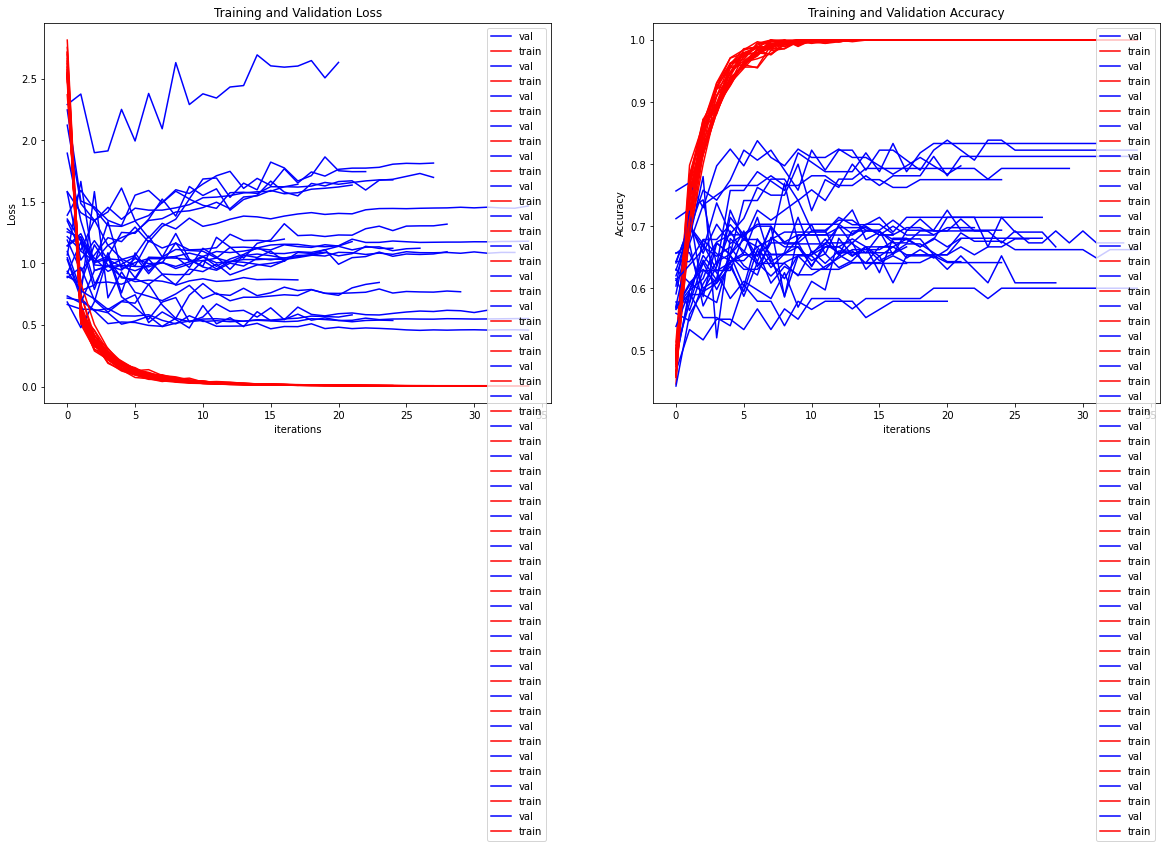

In [ ]:
n_val = 4 
data_folder = '/content/drive/MyDrive/cats'
output_dir = '/content/'
batch_size = 4
test_loss_ft, test_acc_ft, val_acc_ft=cross_validation_train(data_folder, output_dir, 'dino_vits16', 
                        n_val, batch_size, num_epochs=35, patience=15, lr=1e-6, step_size=10, finetune=True)

TBD:
* Review transformers and Treacher-student self destilation
* Run with different parameters - lr, head size,...
* Try finetune vs. transfer learning - done
* Remove crop center?
* Check different ViT networks
* Each image - what is the test result (not only statistics)
* Visualize model



In [ ]:
#help (model_dino.head)
# torch.hub.list('facebookresearch/dino')
!wget https://github.com/facebookresearch/dino/blob/cb711401860da580817918b9167ed73e3eef3dcf/eval_linear.py



## b.Transfer learning:


Cat number for test:  1  index:  0


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [11 21  3 29]
test fraction:  0.02
validation fraction:  0.11
train fraction:  0.88
{'val': 50, 'train': 406, 'test': 8}
torch.Size([50, 384])
torch.Size([406, 384])
torch.Size([8, 384])
Epoch 0/99
----------
train Loss: 1.0206 Acc: 0.5074
val Loss: 0.8817 Acc: 0.6400

Epoch 1/99
----------
train Loss: 0.9848 Acc: 0.4877
val Loss: 0.8350 Acc: 0.6600

Epoch 2/99
----------
train Loss: 0.9376 Acc: 0.4975
val Loss: 0.6239 Acc: 0.7400

Epoch 3/99
----------
train Loss: 0.8663 Acc: 0.5443
val Loss: 0.5740 Acc: 0.7600

Epoch 4/99
----------
train Loss: 0.7939 Acc: 0.5640
val Loss: 0.6239 Acc: 0.7000

Epoch 5/99
----------
train Loss: 0.7235 Acc: 0.6084
val Loss: 0.5628 Acc: 0.7400

Epoch 6/99
----------
train Loss: 0.6535 Acc: 0.6453
val Loss: 0.4812 Acc: 0.7600

Epoch 7/99
----------
train Loss: 0.6042 Acc: 0.6749
val Loss: 0.4727 Acc: 0.7600

Epoch 8/99
----------
train Loss: 0.5563 Acc: 0.7044
val Loss: 0.4956 Acc: 0.7400

Epoch 9/99
----------
train Loss: 0.5250 Acc: 0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


val Loss: 0.6331 Acc: 0.7800

Epoch 47/99
----------
train Loss: 0.2140 Acc: 0.9261
val Loss: 0.6351 Acc: 0.7800

Epoch 48/99
----------
train Loss: 0.2114 Acc: 0.9212
val Loss: 0.6368 Acc: 0.7800

Epoch 49/99
----------
train Loss: 0.2092 Acc: 0.9212
val Loss: 0.6349 Acc: 0.8000

Epoch 50/99
----------
train Loss: 0.2068 Acc: 0.9212
val Loss: 0.6313 Acc: 0.8000

Epoch 51/99
----------
train Loss: 0.2044 Acc: 0.9310
val Loss: 0.6292 Acc: 0.8000

Training complete in 0m 0s
Best val Acc: 0.840000
Test error: 
Average loss: 0.05 test accuracy: 75.0% 

ax1  AxesSubplot(0.125,0.125;0.352273x0.755)

Mean validation accuracy till 1: 84.00%
Mean test accuracy till 1: 75.00%
Saved PyTorch model state to  /content/drive/MyDrive/models/model0_cat1_test_ac75.pth

Cat number for test:  3  index:  1
Validation cats:  [23 13 10 16]
test fraction:  0.01
validation fraction:  0.19
train fraction:  0.80
{'val': 90, 'train': 370, 'test': 4}
torch.Size([90, 384])
torch.Size([370, 384])
torch.Size([4, 384]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 38/99
----------
train Loss: 0.2823 Acc: 0.8919
val Loss: 0.4481 Acc: 0.8111

Epoch 39/99
----------
train Loss: 0.2970 Acc: 0.8541
val Loss: 0.4302 Acc: 0.8222

Epoch 40/99
----------
train Loss: 0.2771 Acc: 0.8730
val Loss: 0.4178 Acc: 0.7778

Epoch 41/99
----------
train Loss: 0.2654 Acc: 0.9027
val Loss: 0.4371 Acc: 0.7778

Epoch 42/99
----------
train Loss: 0.2748 Acc: 0.8811
val Loss: 0.4203 Acc: 0.8111

Epoch 43/99
----------
train Loss: 0.2558 Acc: 0.9027
val Loss: 0.4273 Acc: 0.8444

Epoch 44/99
----------
train Loss: 0.2522 Acc: 0.8973
val Loss: 0.4407 Acc: 0.8333

Epoch 45/99
----------
train Loss: 0.2562 Acc: 0.8865
val Loss: 0.4219 Acc: 0.8444

Epoch 46/99
----------
train Loss: 0.2406 Acc: 0.9054
val Loss: 0.4285 Acc: 0.8111

Epoch 47/99
----------
train Loss: 0.2419 Acc: 0.8973
val Loss: 0.4334 Acc: 0.7667

Epoch 48/99
----------
train Loss: 0.2412 Acc: 0.9000
val Loss: 0.4233 Acc: 0.8333

Epoch 49/99
----------
train Loss: 0.2297 Acc: 0.9081
val Loss: 0.4347 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [20 26 16 22]
test fraction:  0.01
validation fraction:  0.17
train fraction:  0.82
{'val': 78, 'train': 382, 'test': 4}
torch.Size([78, 384])
torch.Size([382, 384])
torch.Size([4, 384])
Epoch 0/99
----------
train Loss: 1.2550 Acc: 0.4974
val Loss: 1.1223 Acc: 0.4744

Epoch 1/99
----------
train Loss: 1.1421 Acc: 0.4948
val Loss: 1.1634 Acc: 0.4615

Epoch 2/99
----------
train Loss: 1.0871 Acc: 0.5157
val Loss: 1.0060 Acc: 0.4359

Epoch 3/99
----------
train Loss: 0.9280 Acc: 0.5079
val Loss: 0.9394 Acc: 0.4872

Epoch 4/99
----------
train Loss: 0.9235 Acc: 0.5288
val Loss: 1.1167 Acc: 0.5256

Epoch 5/99
----------
train Loss: 0.8171 Acc: 0.5838
val Loss: 1.3150 Acc: 0.5128

Epoch 6/99
----------
train Loss: 0.8165 Acc: 0.6152
val Loss: 1.0077 Acc: 0.5385

Epoch 7/99
----------
train Loss: 0.6993 Acc: 0.6545
val Loss: 0.7908 Acc: 0.5513

Epoch 8/99
----------
train Loss: 0.6713 Acc: 0.6545
val Loss: 0.7859 Acc: 0.5641

Epoch 9/99
----------
train Loss: 0.5785 Acc: 0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2644 Acc: 0.8979
val Loss: 0.6787 Acc: 0.7564

Epoch 36/99
----------
train Loss: 0.2584 Acc: 0.9136
val Loss: 0.6867 Acc: 0.7564

Epoch 37/99
----------
train Loss: 0.2547 Acc: 0.9162
val Loss: 0.6834 Acc: 0.7436

Epoch 38/99
----------
train Loss: 0.2490 Acc: 0.9162
val Loss: 0.6778 Acc: 0.7564

Epoch 39/99
----------
train Loss: 0.2435 Acc: 0.9110
val Loss: 0.6792 Acc: 0.7436

Epoch 40/99
----------
train Loss: 0.2397 Acc: 0.9084
val Loss: 0.6829 Acc: 0.7436

Epoch 41/99
----------
train Loss: 0.2347 Acc: 0.9162
val Loss: 0.6875 Acc: 0.7308

Epoch 42/99
----------
train Loss: 0.2310 Acc: 0.9215
val Loss: 0.6920 Acc: 0.7308

Epoch 43/99
----------
train Loss: 0.2281 Acc: 0.9241
val Loss: 0.6960 Acc: 0.7051

Epoch 44/99
----------
train Loss: 0.2240 Acc: 0.9241
val Loss: 0.7017 Acc: 0.7051

Epoch 45/99
----------
train Loss: 0.2208 Acc: 0.9215
val Loss: 0.7064 Acc: 0.7051

Epoch 46/99
----------
train Loss: 0.2174 Acc: 0.9215
val Loss: 0.7095 Acc: 0.6923

Epoch 47/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [22 27  4  8]
test fraction:  0.04
validation fraction:  0.13
train fraction:  0.83
{'val': 60, 'train': 384, 'test': 20}
torch.Size([60, 384])
torch.Size([384, 384])
torch.Size([20, 384])
Epoch 0/99
----------
train Loss: 3.3226 Acc: 0.4922
val Loss: 1.1981 Acc: 0.5167

Epoch 1/99
----------
train Loss: 1.4999 Acc: 0.5000
val Loss: 3.3112 Acc: 0.5000

Epoch 2/99
----------
train Loss: 2.5058 Acc: 0.4818
val Loss: 3.5335 Acc: 0.5000

Epoch 3/99
----------
train Loss: 2.7323 Acc: 0.4948
val Loss: 1.3825 Acc: 0.5167

Epoch 4/99
----------
train Loss: 1.0659 Acc: 0.5651
val Loss: 1.7086 Acc: 0.5833

Epoch 5/99
----------
train Loss: 2.0882 Acc: 0.5182
val Loss: 1.8394 Acc: 0.5500

Epoch 6/99
----------
train Loss: 2.0622 Acc: 0.5391
val Loss: 0.9776 Acc: 0.4833

Epoch 7/99
----------
train Loss: 0.8004 Acc: 0.6667
val Loss: 2.1996 Acc: 0.5000

Epoch 8/99
----------
train Loss: 1.7576 Acc: 0.5156
val Loss: 1.7885 Acc: 0.5333

Epoch 9/99
----------
train Loss: 1.3993 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 46/99
----------
train Loss: 0.2640 Acc: 0.9010
val Loss: 0.6575 Acc: 0.7667

Epoch 47/99
----------
train Loss: 0.2618 Acc: 0.9036
val Loss: 0.6640 Acc: 0.7500

Epoch 48/99
----------
train Loss: 0.2438 Acc: 0.8984
val Loss: 0.6957 Acc: 0.7500

Epoch 49/99
----------
train Loss: 0.2461 Acc: 0.9193
val Loss: 0.7059 Acc: 0.7833

Epoch 50/99
----------
train Loss: 0.2459 Acc: 0.9141
val Loss: 0.6820 Acc: 0.7333

Epoch 51/99
----------
train Loss: 0.2319 Acc: 0.9167
val Loss: 0.6724 Acc: 0.7500

Epoch 52/99
----------
train Loss: 0.2315 Acc: 0.9193
val Loss: 0.6763 Acc: 0.7500

Epoch 53/99
----------
train Loss: 0.2328 Acc: 0.9193
val Loss: 0.6785 Acc: 0.7333

Epoch 54/99
----------
train Loss: 0.2223 Acc: 0.9219
val Loss: 0.6921 Acc: 0.7500

Epoch 55/99
----------
train Loss: 0.2205 Acc: 0.9193
val Loss: 0.6998 Acc: 0.7500

Epoch 56/99
----------
train Loss: 0.2214 Acc: 0.9271
val Loss: 0.6851 Acc: 0.7500

Epoch 57/99
----------
train Loss: 0.2132 Acc: 0.9219
val Loss: 0.6711 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 8 18 24 19]
test fraction:  0.05
validation fraction:  0.17
train fraction:  0.78
{'val': 78, 'train': 364, 'test': 22}
torch.Size([78, 384])
torch.Size([364, 384])
torch.Size([22, 384])
Epoch 0/99
----------
train Loss: 1.7597 Acc: 0.4835
val Loss: 1.2863 Acc: 0.6026

Epoch 1/99
----------
train Loss: 1.2848 Acc: 0.4835
val Loss: 1.5434 Acc: 0.6538

Epoch 2/99
----------
train Loss: 1.6138 Acc: 0.5137
val Loss: 0.8680 Acc: 0.6154

Epoch 3/99
----------
train Loss: 0.8992 Acc: 0.5220
val Loss: 0.7525 Acc: 0.5769

Epoch 4/99
----------
train Loss: 1.3355 Acc: 0.5110
val Loss: 0.6924 Acc: 0.6795

Epoch 5/99
----------
train Loss: 0.7573 Acc: 0.5962
val Loss: 1.4691 Acc: 0.5513

Epoch 6/99
----------
train Loss: 1.1427 Acc: 0.5549
val Loss: 0.9335 Acc: 0.6026

Epoch 7/99
----------
train Loss: 0.6984 Acc: 0.6731
val Loss: 0.5570 Acc: 0.7051

Epoch 8/99
----------
train Loss: 0.9134 Acc: 0.6181
val Loss: 0.5636 Acc: 0.6923

Epoch 9/99
----------
train Loss: 0.7509 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 45/99
----------
train Loss: 0.2316 Acc: 0.9093
val Loss: 0.6066 Acc: 0.7308

Epoch 46/99
----------
train Loss: 0.2326 Acc: 0.9038
val Loss: 0.6060 Acc: 0.7179

Epoch 47/99
----------
train Loss: 0.2283 Acc: 0.9038
val Loss: 0.6004 Acc: 0.6923

Epoch 48/99
----------
train Loss: 0.2224 Acc: 0.9038
val Loss: 0.6001 Acc: 0.7179

Epoch 49/99
----------
train Loss: 0.2232 Acc: 0.9093
val Loss: 0.5962 Acc: 0.6923

Epoch 50/99
----------
train Loss: 0.2172 Acc: 0.9093
val Loss: 0.5976 Acc: 0.7308

Epoch 51/99
----------
train Loss: 0.2143 Acc: 0.9066
val Loss: 0.5981 Acc: 0.7436

Epoch 52/99
----------
train Loss: 0.2132 Acc: 0.9066
val Loss: 0.5911 Acc: 0.7308

Epoch 53/99
----------
train Loss: 0.2075 Acc: 0.9121
val Loss: 0.5894 Acc: 0.7051

Epoch 54/99
----------
train Loss: 0.2063 Acc: 0.9066
val Loss: 0.5885 Acc: 0.7179

Epoch 55/99
----------
train Loss: 0.2038 Acc: 0.9066
val Loss: 0.5860 Acc: 0.7179

Epoch 56/99
----------
train Loss: 0.1998 Acc: 0.9203
val Loss: 0.5863 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16 21 20  5]
test fraction:  0.01
validation fraction:  0.14
train fraction:  0.85
{'val': 66, 'train': 394, 'test': 4}
torch.Size([66, 384])
torch.Size([394, 384])
torch.Size([4, 384])
Epoch 0/99
----------
train Loss: 1.5937 Acc: 0.5127
val Loss: 1.0305 Acc: 0.5909

Epoch 1/99
----------
train Loss: 1.0939 Acc: 0.5381
val Loss: 1.4551 Acc: 0.5152

Epoch 2/99
----------
train Loss: 1.4521 Acc: 0.5152
val Loss: 0.7237 Acc: 0.6515

Epoch 3/99
----------
train Loss: 0.8305 Acc: 0.5609
val Loss: 0.9738 Acc: 0.4848

Epoch 4/99
----------
train Loss: 1.2218 Acc: 0.4975
val Loss: 0.6349 Acc: 0.7273

Epoch 5/99
----------
train Loss: 0.7215 Acc: 0.6320
val Loss: 1.0283 Acc: 0.5606

Epoch 6/99
----------
train Loss: 1.0255 Acc: 0.5660
val Loss: 0.6711 Acc: 0.7424

Epoch 7/99
----------
train Loss: 0.7127 Acc: 0.6523
val Loss: 0.7340 Acc: 0.6212

Epoch 8/99
----------
train Loss: 0.8296 Acc: 0.6269
val Loss: 0.6443 Acc: 0.6970

Epoch 9/99
----------
train Loss: 0.7008 Acc: 0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


val Loss: 0.5419 Acc: 0.7424

Epoch 46/99
----------
train Loss: 0.2511 Acc: 0.9213
val Loss: 0.5630 Acc: 0.7273

Epoch 47/99
----------
train Loss: 0.2444 Acc: 0.9289
val Loss: 0.6024 Acc: 0.6667

Epoch 48/99
----------
train Loss: 0.2421 Acc: 0.9315
val Loss: 0.6179 Acc: 0.6667

Epoch 49/99
----------
train Loss: 0.2407 Acc: 0.9239
val Loss: 0.5953 Acc: 0.6970

Epoch 50/99
----------
train Loss: 0.2350 Acc: 0.9315
val Loss: 0.5735 Acc: 0.7273

Epoch 51/99
----------
train Loss: 0.2340 Acc: 0.9315
val Loss: 0.5760 Acc: 0.7273

Epoch 52/99
----------
train Loss: 0.2314 Acc: 0.9289
val Loss: 0.6005 Acc: 0.6970

Training complete in 0m 0s
Best val Acc: 0.833333
Test error: 
Average loss: 0.05 test accuracy: 100.0% 

AxesSubplot(0.547727,0.125;0.352273x0.755)

Mean validation accuracy till 6: 81.27%
Mean test accuracy till 6: 78.56%
Saved PyTorch model state to  /content/drive/MyDrive/models/model5_cat7_test_ac100.pth

Cat number for test:  8  index:  6
Validation cats:  [ 1 20 18 10]
tes

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


----------
train Loss: 0.2691 Acc: 0.9026
val Loss: 0.4907 Acc: 0.7903

Epoch 39/99
----------
train Loss: 0.2641 Acc: 0.9051
val Loss: 0.4900 Acc: 0.8065

Epoch 40/99
----------
train Loss: 0.2597 Acc: 0.9051
val Loss: 0.4895 Acc: 0.8226

Epoch 41/99
----------
train Loss: 0.2559 Acc: 0.9026
val Loss: 0.4889 Acc: 0.8065

Epoch 42/99
----------
train Loss: 0.2516 Acc: 0.9077
val Loss: 0.4884 Acc: 0.8065

Epoch 43/99
----------
train Loss: 0.2476 Acc: 0.9179
val Loss: 0.4863 Acc: 0.7903

Epoch 44/99
----------
train Loss: 0.2437 Acc: 0.9205
val Loss: 0.4836 Acc: 0.8065

Epoch 45/99
----------
train Loss: 0.2398 Acc: 0.9205
val Loss: 0.4822 Acc: 0.8065

Epoch 46/99
----------
train Loss: 0.2366 Acc: 0.9179
val Loss: 0.4814 Acc: 0.8065

Epoch 47/99
----------
train Loss: 0.2333 Acc: 0.9179
val Loss: 0.4812 Acc: 0.8065

Epoch 48/99
----------
train Loss: 0.2303 Acc: 0.9205
val Loss: 0.4815 Acc: 0.8065

Epoch 49/99
----------
train Loss: 0.2275 Acc: 0.9205
val Loss: 0.4823 Acc: 0.7903

Epoc

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [25  3 14  5]
test fraction:  0.05
validation fraction:  0.16
train fraction:  0.79
{'val': 74, 'train': 366, 'test': 24}
torch.Size([74, 384])
torch.Size([366, 384])
torch.Size([24, 384])
Epoch 0/99
----------
train Loss: 1.3428 Acc: 0.4563
val Loss: 1.6373 Acc: 0.4054

Epoch 1/99
----------
train Loss: 1.2219 Acc: 0.4672
val Loss: 1.6719 Acc: 0.4189

Epoch 2/99
----------
train Loss: 1.2277 Acc: 0.4863
val Loss: 1.4691 Acc: 0.3514

Epoch 3/99
----------
train Loss: 1.0148 Acc: 0.4617
val Loss: 1.4593 Acc: 0.3919

Epoch 4/99
----------
train Loss: 1.0253 Acc: 0.5355
val Loss: 1.3272 Acc: 0.4459

Epoch 5/99
----------
train Loss: 0.8253 Acc: 0.5574
val Loss: 1.3053 Acc: 0.4730

Epoch 6/99
----------
train Loss: 0.8305 Acc: 0.5765
val Loss: 1.0826 Acc: 0.4865

Epoch 7/99
----------
train Loss: 0.6680 Acc: 0.6585
val Loss: 1.0485 Acc: 0.5811

Epoch 8/99
----------
train Loss: 0.6791 Acc: 0.6995
val Loss: 0.8446 Acc: 0.5541

Epoch 9/99
----------
train Loss: 0.5560 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 39/99
----------
train Loss: 0.2538 Acc: 0.9208
val Loss: 0.6445 Acc: 0.7027

Epoch 40/99
----------
train Loss: 0.2498 Acc: 0.9208
val Loss: 0.6267 Acc: 0.7027

Epoch 41/99
----------
train Loss: 0.2456 Acc: 0.9262
val Loss: 0.6197 Acc: 0.7027

Epoch 42/99
----------
train Loss: 0.2437 Acc: 0.9153
val Loss: 0.6288 Acc: 0.6892

Epoch 43/99
----------
train Loss: 0.2394 Acc: 0.9262
val Loss: 0.6469 Acc: 0.7027

Epoch 44/99
----------
train Loss: 0.2363 Acc: 0.9262
val Loss: 0.6534 Acc: 0.7027

Epoch 45/99
----------
train Loss: 0.2339 Acc: 0.9262
val Loss: 0.6413 Acc: 0.7027

Epoch 46/99
----------
train Loss: 0.2299 Acc: 0.9290
val Loss: 0.6291 Acc: 0.7027

Epoch 47/99
----------
train Loss: 0.2275 Acc: 0.9290
val Loss: 0.6283 Acc: 0.7027

Epoch 48/99
----------
train Loss: 0.2247 Acc: 0.9317
val Loss: 0.6370 Acc: 0.6892

Epoch 49/99
----------
train Loss: 0.2212 Acc: 0.9317
val Loss: 0.6446 Acc: 0.6892

Epoch 50/99
----------
train Loss: 0.2190 Acc: 0.9317
val Loss: 0.6402 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [11 20  5 16]
test fraction:  0.04
validation fraction:  0.15
train fraction:  0.81
{'val': 70, 'train': 374, 'test': 20}
torch.Size([70, 384])
torch.Size([374, 384])
torch.Size([20, 384])
Epoch 0/99
----------
train Loss: 1.6968 Acc: 0.5000
val Loss: 0.8331 Acc: 0.6000

Epoch 1/99
----------
train Loss: 1.0637 Acc: 0.5535
val Loss: 1.4193 Acc: 0.5571

Epoch 2/99
----------
train Loss: 1.5731 Acc: 0.5321
val Loss: 0.6417 Acc: 0.6714

Epoch 3/99
----------
train Loss: 0.8360 Acc: 0.5695
val Loss: 0.9258 Acc: 0.6286

Epoch 4/99
----------
train Loss: 1.3769 Acc: 0.5160
val Loss: 0.6122 Acc: 0.7286

Epoch 5/99
----------
train Loss: 0.8592 Acc: 0.5936
val Loss: 1.1246 Acc: 0.5857

Epoch 6/99
----------
train Loss: 1.0786 Acc: 0.5963
val Loss: 1.0562 Acc: 0.5857

Epoch 7/99
----------
train Loss: 0.9764 Acc: 0.6257
val Loss: 0.5993 Acc: 0.7571

Epoch 8/99
----------
train Loss: 0.6923 Acc: 0.6818
val Loss: 0.7555 Acc: 0.7571

Epoch 9/99
----------
train Loss: 0.9247 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.5943 Acc: 0.7143

Epoch 43/99
----------
train Loss: 0.2264 Acc: 0.9144
val Loss: 0.6201 Acc: 0.7286

Epoch 44/99
----------
train Loss: 0.2292 Acc: 0.9091
val Loss: 0.6044 Acc: 0.7286

Epoch 45/99
----------
train Loss: 0.2200 Acc: 0.9171
val Loss: 0.5874 Acc: 0.7143

Epoch 46/99
----------
train Loss: 0.2172 Acc: 0.9251
val Loss: 0.5884 Acc: 0.7286

Epoch 47/99
----------
train Loss: 0.2170 Acc: 0.9198
val Loss: 0.5978 Acc: 0.7143

Epoch 48/99
----------
train Loss: 0.2091 Acc: 0.9332
val Loss: 0.6186 Acc: 0.7000

Epoch 49/99
----------
train Loss: 0.2084 Acc: 0.9171
val Loss: 0.6218 Acc: 0.7000

Epoch 50/99
----------
train Loss: 0.2060 Acc: 0.9171
val Loss: 0.6062 Acc: 0.7143

Epoch 51/99
----------
train Loss: 0.2001 Acc: 0.9305
val Loss: 0.5993 Acc: 0.7000

Epoch 52/99
----------
train Loss: 0.1999 Acc: 0.9305
val Loss: 0.6009 Acc: 0.7143

Training complete in 0m 0s
Best val Acc: 0.785714
Test error: 
Average loss: 0.02 test accuracy: 85.0% 

AxesSubplot(0.547727,0.12

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 18 22 12]
test fraction:  0.03
validation fraction:  0.18
train fraction:  0.79
{'val': 84, 'train': 366, 'test': 14}
torch.Size([84, 384])
torch.Size([366, 384])
torch.Size([14, 384])
Epoch 0/99
----------
train Loss: 1.5739 Acc: 0.5027
val Loss: 1.3552 Acc: 0.5357

Epoch 1/99
----------
train Loss: 1.2878 Acc: 0.5219
val Loss: 1.5575 Acc: 0.4762

Epoch 2/99
----------
train Loss: 1.4222 Acc: 0.5109
val Loss: 1.1538 Acc: 0.5119

Epoch 3/99
----------
train Loss: 1.0392 Acc: 0.5355
val Loss: 1.2353 Acc: 0.5357

Epoch 4/99
----------
train Loss: 1.0631 Acc: 0.5738
val Loss: 1.0874 Acc: 0.5238

Epoch 5/99
----------
train Loss: 0.8680 Acc: 0.6148
val Loss: 0.8609 Acc: 0.5952

Epoch 6/99
----------
train Loss: 0.8084 Acc: 0.6148
val Loss: 0.8124 Acc: 0.6310

Epoch 7/99
----------
train Loss: 0.7888 Acc: 0.6366
val Loss: 0.9215 Acc: 0.5119

Epoch 8/99
----------
train Loss: 0.6788 Acc: 0.7077
val Loss: 1.1101 Acc: 0.5238

Epoch 9/99
----------
train Loss: 0.7524 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.5063 Acc: 0.7619

Epoch 42/99
----------
train Loss: 0.2133 Acc: 0.9399
val Loss: 0.5114 Acc: 0.7619

Epoch 43/99
----------
train Loss: 0.2131 Acc: 0.9372
val Loss: 0.5036 Acc: 0.7619

Epoch 44/99
----------
train Loss: 0.2086 Acc: 0.9399
val Loss: 0.4963 Acc: 0.7738

Epoch 45/99
----------
train Loss: 0.2057 Acc: 0.9399
val Loss: 0.4956 Acc: 0.7857

Epoch 46/99
----------
train Loss: 0.2048 Acc: 0.9399
val Loss: 0.4947 Acc: 0.7738

Epoch 47/99
----------
train Loss: 0.2002 Acc: 0.9399
val Loss: 0.4988 Acc: 0.7619

Epoch 48/99
----------
train Loss: 0.1976 Acc: 0.9426
val Loss: 0.5019 Acc: 0.7619

Epoch 49/99
----------
train Loss: 0.1957 Acc: 0.9399
val Loss: 0.4981 Acc: 0.7619

Epoch 50/99
----------
train Loss: 0.1914 Acc: 0.9454
val Loss: 0.4966 Acc: 0.7976

Epoch 51/99
----------
train Loss: 0.1892 Acc: 0.9426
val Loss: 0.4982 Acc: 0.7857

Epoch 52/99
----------
train Loss: 0.1870 Acc: 0.9481
val Loss: 0.5018 Acc: 0.7738

Epoch 53/99
----------
train Loss: 0.1835 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [18  7  6 21]
test fraction:  0.03
validation fraction:  0.13
train fraction:  0.84
{'val': 62, 'train': 390, 'test': 12}
torch.Size([62, 384])
torch.Size([390, 384])
torch.Size([12, 384])
Epoch 0/99
----------
train Loss: 2.1256 Acc: 0.5000
val Loss: 0.8948 Acc: 0.5806

Epoch 1/99
----------
train Loss: 1.3256 Acc: 0.4974
val Loss: 1.2427 Acc: 0.5161

Epoch 2/99
----------
train Loss: 1.9320 Acc: 0.5179
val Loss: 0.8568 Acc: 0.5806

Epoch 3/99
----------
train Loss: 1.2533 Acc: 0.5282
val Loss: 1.4939 Acc: 0.4839

Epoch 4/99
----------
train Loss: 1.4301 Acc: 0.5308
val Loss: 1.2602 Acc: 0.4839

Epoch 5/99
----------
train Loss: 1.3447 Acc: 0.5333
val Loss: 0.9362 Acc: 0.5323

Epoch 6/99
----------
train Loss: 0.9560 Acc: 0.5923
val Loss: 1.4148 Acc: 0.5323

Epoch 7/99
----------
train Loss: 1.2695 Acc: 0.5436
val Loss: 0.6737 Acc: 0.6613

Epoch 8/99
----------
train Loss: 0.7152 Acc: 0.6718
val Loss: 0.8283 Acc: 0.5968

Epoch 9/99
----------
train Loss: 1.0523 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2755 Acc: 0.8769
val Loss: 0.4423 Acc: 0.7903

Epoch 41/99
----------
train Loss: 0.2742 Acc: 0.8821
val Loss: 0.4408 Acc: 0.7903

Epoch 42/99
----------
train Loss: 0.2744 Acc: 0.8872
val Loss: 0.4499 Acc: 0.8065

Epoch 43/99
----------
train Loss: 0.2600 Acc: 0.8821
val Loss: 0.4726 Acc: 0.8226

Epoch 44/99
----------
train Loss: 0.2645 Acc: 0.8795
val Loss: 0.4643 Acc: 0.8226

Epoch 45/99
----------
train Loss: 0.2588 Acc: 0.8769
val Loss: 0.4427 Acc: 0.7903

Epoch 46/99
----------
train Loss: 0.2516 Acc: 0.8949
val Loss: 0.4389 Acc: 0.7903

Epoch 47/99
----------
train Loss: 0.2550 Acc: 0.9103
val Loss: 0.4404 Acc: 0.7903

Epoch 48/99
----------
train Loss: 0.2462 Acc: 0.9128
val Loss: 0.4564 Acc: 0.8226

Epoch 49/99
----------
train Loss: 0.2441 Acc: 0.8821
val Loss: 0.4639 Acc: 0.8065

Epoch 50/99
----------
train Loss: 0.2435 Acc: 0.8821
val Loss: 0.4484 Acc: 0.8065

Epoch 51/99
----------
train Loss: 0.2360 Acc: 0.8949
val Loss: 0.4380 Acc: 0.8065

Epoch 52/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 8 26 11  3]
test fraction:  0.05
validation fraction:  0.10
train fraction:  0.85
{'val': 46, 'train': 396, 'test': 22}
torch.Size([46, 384])
torch.Size([396, 384])
torch.Size([22, 384])
Epoch 0/99
----------
train Loss: 1.5157 Acc: 0.4899
val Loss: 1.4255 Acc: 0.5870

Epoch 1/99
----------
train Loss: 1.3219 Acc: 0.4975
val Loss: 1.4038 Acc: 0.5217

Epoch 2/99
----------
train Loss: 1.2960 Acc: 0.5025
val Loss: 0.9503 Acc: 0.5652

Epoch 3/99
----------
train Loss: 1.0129 Acc: 0.5328
val Loss: 0.8795 Acc: 0.6304

Epoch 4/99
----------
train Loss: 1.0222 Acc: 0.5480
val Loss: 0.7416 Acc: 0.6739

Epoch 5/99
----------
train Loss: 0.8119 Acc: 0.5833
val Loss: 0.7571 Acc: 0.6304

Epoch 6/99
----------
train Loss: 0.8210 Acc: 0.6162
val Loss: 0.7432 Acc: 0.6957

Epoch 7/99
----------
train Loss: 0.6741 Acc: 0.6540
val Loss: 0.9365 Acc: 0.6087

Epoch 8/99
----------
train Loss: 0.6565 Acc: 0.7121
val Loss: 0.9082 Acc: 0.6739

Epoch 9/99
----------
train Loss: 0.5921 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.8184 Acc: 0.6957

Epoch 47/99
----------
train Loss: 0.2188 Acc: 0.9192
val Loss: 0.8284 Acc: 0.6522

Epoch 48/99
----------
train Loss: 0.2160 Acc: 0.9293
val Loss: 0.8325 Acc: 0.6304

Epoch 49/99
----------
train Loss: 0.2134 Acc: 0.9318
val Loss: 0.8301 Acc: 0.6739

Epoch 50/99
----------
train Loss: 0.2102 Acc: 0.9343
val Loss: 0.8294 Acc: 0.6957

Epoch 51/99
----------
train Loss: 0.2081 Acc: 0.9268
val Loss: 0.8328 Acc: 0.6957

Epoch 52/99
----------
train Loss: 0.2055 Acc: 0.9343
val Loss: 0.8386 Acc: 0.6522

Epoch 53/99
----------
train Loss: 0.2026 Acc: 0.9444
val Loss: 0.8435 Acc: 0.6522

Epoch 54/99
----------
train Loss: 0.2005 Acc: 0.9394
val Loss: 0.8433 Acc: 0.6522

Epoch 55/99
----------
train Loss: 0.1979 Acc: 0.9444
val Loss: 0.8408 Acc: 0.6957

Training complete in 0m 0s
Best val Acc: 0.760870
Test error: 
Average loss: 0.02 test accuracy: 81.8% 

AxesSubplot(0.547727,0.125;0.352273x0.755)

Mean validation accuracy till 12: 81.49%
Mean test accuracy till 

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 7 25 16 11]
test fraction:  0.06
validation fraction:  0.15
train fraction:  0.79
{'val': 70, 'train': 368, 'test': 26}
torch.Size([70, 384])
torch.Size([368, 384])
torch.Size([26, 384])
Epoch 0/99
----------
train Loss: 2.1010 Acc: 0.4701
val Loss: 1.8456 Acc: 0.4714

Epoch 1/99
----------
train Loss: 1.2617 Acc: 0.5054
val Loss: 1.9736 Acc: 0.4000

Epoch 2/99
----------
train Loss: 1.8279 Acc: 0.5136
val Loss: 1.3792 Acc: 0.4571

Epoch 3/99
----------
train Loss: 1.1233 Acc: 0.5326
val Loss: 1.8021 Acc: 0.5429

Epoch 4/99
----------
train Loss: 1.3382 Acc: 0.5054
val Loss: 1.6850 Acc: 0.5286

Epoch 5/99
----------
train Loss: 1.2380 Acc: 0.5299
val Loss: 0.8464 Acc: 0.5429

Epoch 6/99
----------
train Loss: 0.9676 Acc: 0.6141
val Loss: 1.0969 Acc: 0.5857

Epoch 7/99
----------
train Loss: 1.3049 Acc: 0.6005
val Loss: 0.7546 Acc: 0.5143

Epoch 8/99
----------
train Loss: 0.7762 Acc: 0.6603
val Loss: 1.4299 Acc: 0.5571

Epoch 9/99
----------
train Loss: 0.9432 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.6139 Acc: 0.7429

Epoch 46/99
----------
train Loss: 0.2166 Acc: 0.9293
val Loss: 0.5759 Acc: 0.7571

Epoch 47/99
----------
train Loss: 0.2181 Acc: 0.9185
val Loss: 0.5719 Acc: 0.7571

Epoch 48/99
----------
train Loss: 0.2162 Acc: 0.9158
val Loss: 0.5973 Acc: 0.7429

Epoch 49/99
----------
train Loss: 0.2085 Acc: 0.9293
val Loss: 0.6337 Acc: 0.7429

Epoch 50/99
----------
train Loss: 0.2083 Acc: 0.9239
val Loss: 0.6347 Acc: 0.7429

Epoch 51/99
----------
train Loss: 0.2053 Acc: 0.9293
val Loss: 0.6018 Acc: 0.7571

Epoch 52/99
----------
train Loss: 0.1994 Acc: 0.9348
val Loss: 0.5779 Acc: 0.7714

Epoch 53/99
----------
train Loss: 0.1995 Acc: 0.9293
val Loss: 0.5778 Acc: 0.7714

Epoch 54/99
----------
train Loss: 0.1974 Acc: 0.9293
val Loss: 0.5978 Acc: 0.7714

Epoch 55/99
----------
train Loss: 0.1933 Acc: 0.9348
val Loss: 0.6198 Acc: 0.7286

Epoch 56/99
----------
train Loss: 0.1931 Acc: 0.9375
val Loss: 0.6145 Acc: 0.7286

Epoch 57/99
----------
train Loss: 0.1909 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [10 29 22 25]
test fraction:  0.06
validation fraction:  0.20
train fraction:  0.74
{'val': 92, 'train': 344, 'test': 28}
torch.Size([92, 384])
torch.Size([344, 384])
torch.Size([28, 384])
Epoch 0/99
----------
train Loss: 1.8291 Acc: 0.4651
val Loss: 1.4063 Acc: 0.5000

Epoch 1/99
----------
train Loss: 1.3935 Acc: 0.4884
val Loss: 1.4957 Acc: 0.5109

Epoch 2/99
----------
train Loss: 1.7025 Acc: 0.5174
val Loss: 1.1862 Acc: 0.5543

Epoch 3/99
----------
train Loss: 1.2206 Acc: 0.5233
val Loss: 1.6214 Acc: 0.5109

Epoch 4/99
----------
train Loss: 1.3522 Acc: 0.5087
val Loss: 1.4656 Acc: 0.5000

Epoch 5/99
----------
train Loss: 1.1832 Acc: 0.5320
val Loss: 0.9321 Acc: 0.5652

Epoch 6/99
----------
train Loss: 1.0176 Acc: 0.5843
val Loss: 0.9249 Acc: 0.5870

Epoch 7/99
----------
train Loss: 1.0729 Acc: 0.5959
val Loss: 0.9881 Acc: 0.6413

Epoch 8/99
----------
train Loss: 0.7555 Acc: 0.6483
val Loss: 1.2812 Acc: 0.5652

Epoch 9/99
----------
train Loss: 0.8937 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.8838 Acc: 0.7065

Epoch 42/99
----------
train Loss: 0.2586 Acc: 0.8983
val Loss: 0.8698 Acc: 0.7065

Epoch 43/99
----------
train Loss: 0.2513 Acc: 0.8983
val Loss: 0.8333 Acc: 0.6957

Epoch 44/99
----------
train Loss: 0.2457 Acc: 0.9157
val Loss: 0.8200 Acc: 0.6957

Epoch 45/99
----------
train Loss: 0.2452 Acc: 0.8924
val Loss: 0.8349 Acc: 0.6957

Epoch 46/99
----------
train Loss: 0.2387 Acc: 0.9157
val Loss: 0.8670 Acc: 0.7065

Epoch 47/99
----------
train Loss: 0.2359 Acc: 0.9215
val Loss: 0.8788 Acc: 0.7065

Epoch 48/99
----------
train Loss: 0.2347 Acc: 0.9157
val Loss: 0.8543 Acc: 0.7174

Epoch 49/99
----------
train Loss: 0.2292 Acc: 0.9244
val Loss: 0.8274 Acc: 0.6957

Epoch 50/99
----------
train Loss: 0.2273 Acc: 0.9215
val Loss: 0.8207 Acc: 0.7174

Epoch 51/99
----------
train Loss: 0.2249 Acc: 0.9215
val Loss: 0.8340 Acc: 0.7065

Epoch 52/99
----------
train Loss: 0.2202 Acc: 0.9244
val Loss: 0.8509 Acc: 0.7174

Epoch 53/99
----------
train Loss: 0.2186 Acc:

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During h

Validation cats:  [ 9 20 23 11]
test fraction:  0.06
validation fraction:  0.14
train fraction:  0.80
{'val': 66, 'train': 372, 'test': 26}
torch.Size([66, 384])
torch.Size([372, 384])
torch.Size([26, 384])
Epoch 0/99
----------
train Loss: 1.1385 Acc: 0.5027
val Loss: 0.9451 Acc: 0.5455

Epoch 1/99
----------
train Loss: 1.0558 Acc: 0.5027
val Loss: 0.9481 Acc: 0.5455

Epoch 2/99
----------
train Loss: 0.9849 Acc: 0.4973
val Loss: 0.9168 Acc: 0.5606

Epoch 3/99
----------
train Loss: 0.8670 Acc: 0.5672
val Loss: 0.9636 Acc: 0.5606

Epoch 4/99
----------
train Loss: 0.8156 Acc: 0.5968
val Loss: 0.8901 Acc: 0.6061

Epoch 5/99
----------
train Loss: 0.7586 Acc: 0.6048
val Loss: 0.8416 Acc: 0.6364

Epoch 6/99
----------
train Loss: 0.7202 Acc: 0.6344
val Loss: 0.8430 Acc: 0.5909

Epoch 7/99
----------
train Loss: 0.6600 Acc: 0.6747
val Loss: 0.7733 Acc: 0.6212

Epoch 8/99
----------
train Loss: 0.6186 Acc: 0.7043
val Loss: 0.6303 Acc: 0.6970

Epoch 9/99
----------
train Loss: 0.5621 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2273 Acc: 0.9274
val Loss: 0.5391 Acc: 0.7424

Epoch 47/99
----------
train Loss: 0.2243 Acc: 0.9328
val Loss: 0.5375 Acc: 0.7424

Epoch 48/99
----------
train Loss: 0.2209 Acc: 0.9328
val Loss: 0.5368 Acc: 0.7424

Epoch 49/99
----------
train Loss: 0.2180 Acc: 0.9247
val Loss: 0.5365 Acc: 0.7424

Epoch 50/99
----------
train Loss: 0.2152 Acc: 0.9247
val Loss: 0.5358 Acc: 0.7424

Epoch 51/99
----------
train Loss: 0.2123 Acc: 0.9301
val Loss: 0.5349 Acc: 0.7424

Epoch 52/99
----------
train Loss: 0.2100 Acc: 0.9355
val Loss: 0.5339 Acc: 0.7424

Epoch 53/99
----------
train Loss: 0.2075 Acc: 0.9355
val Loss: 0.5329 Acc: 0.7424

Epoch 54/99
----------
train Loss: 0.2051 Acc: 0.9328
val Loss: 0.5318 Acc: 0.7424

Epoch 55/99
----------
train Loss: 0.2029 Acc: 0.9328
val Loss: 0.5300 Acc: 0.7424

Epoch 56/99
----------
train Loss: 0.2006 Acc: 0.9328
val Loss: 0.5283 Acc: 0.7424

Epoch 57/99
----------
train Loss: 0.1984 Acc: 0.9382
val Loss: 0.5271 Acc: 0.7424

Epoch 58/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16 29 20 30]
test fraction:  0.04
validation fraction:  0.19
train fraction:  0.78
{'val': 86, 'train': 360, 'test': 18}
torch.Size([86, 384])
torch.Size([360, 384])
torch.Size([18, 384])
Epoch 0/99
----------
train Loss: 0.9720 Acc: 0.5139
val Loss: 1.0677 Acc: 0.5000

Epoch 1/99
----------
train Loss: 0.9375 Acc: 0.5306
val Loss: 1.0300 Acc: 0.5000

Epoch 2/99
----------
train Loss: 0.8847 Acc: 0.5528
val Loss: 0.9863 Acc: 0.5000

Epoch 3/99
----------
train Loss: 0.8172 Acc: 0.5472
val Loss: 0.9403 Acc: 0.5000

Epoch 4/99
----------
train Loss: 0.7551 Acc: 0.5917
val Loss: 0.8996 Acc: 0.5581

Epoch 5/99
----------
train Loss: 0.6971 Acc: 0.6583
val Loss: 0.8749 Acc: 0.5581

Epoch 6/99
----------
train Loss: 0.6505 Acc: 0.6750
val Loss: 0.8466 Acc: 0.5465

Epoch 7/99
----------
train Loss: 0.6082 Acc: 0.7056
val Loss: 0.8351 Acc: 0.5930

Epoch 8/99
----------
train Loss: 0.5735 Acc: 0.7278
val Loss: 0.8472 Acc: 0.5814

Epoch 9/99
----------
train Loss: 0.5378 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.9663 Acc: 0.6628

Epoch 44/99
----------
train Loss: 0.2071 Acc: 0.9250
val Loss: 0.9650 Acc: 0.6628

Epoch 45/99
----------
train Loss: 0.2047 Acc: 0.9306
val Loss: 0.9726 Acc: 0.6628

Epoch 46/99
----------
train Loss: 0.2023 Acc: 0.9306
val Loss: 0.9797 Acc: 0.6628

Epoch 47/99
----------
train Loss: 0.2000 Acc: 0.9333
val Loss: 0.9782 Acc: 0.6628

Epoch 48/99
----------
train Loss: 0.1978 Acc: 0.9361
val Loss: 0.9699 Acc: 0.6628

Epoch 49/99
----------
train Loss: 0.1955 Acc: 0.9333
val Loss: 0.9636 Acc: 0.6628

Epoch 50/99
----------
train Loss: 0.1934 Acc: 0.9417
val Loss: 0.9651 Acc: 0.6628

Epoch 51/99
----------
train Loss: 0.1913 Acc: 0.9417
val Loss: 0.9719 Acc: 0.6628

Epoch 52/99
----------
train Loss: 0.1893 Acc: 0.9472
val Loss: 0.9768 Acc: 0.6628

Epoch 53/99
----------
train Loss: 0.1873 Acc: 0.9500
val Loss: 0.9753 Acc: 0.6628

Epoch 54/99
----------
train Loss: 0.1854 Acc: 0.9528
val Loss: 0.9704 Acc: 0.6628

Epoch 55/99
----------
train Loss: 0.1836 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 6 12 29 30]
test fraction:  0.02
validation fraction:  0.18
train fraction:  0.80
{'val': 84, 'train': 372, 'test': 8}
torch.Size([84, 384])
torch.Size([372, 384])
torch.Size([8, 384])
Epoch 0/99
----------
train Loss: 2.0766 Acc: 0.4892
val Loss: 1.0161 Acc: 0.4881

Epoch 1/99
----------
train Loss: 1.3165 Acc: 0.4839
val Loss: 1.3519 Acc: 0.5119

Epoch 2/99
----------
train Loss: 1.9234 Acc: 0.4892
val Loss: 0.9139 Acc: 0.5595

Epoch 3/99
----------
train Loss: 1.1749 Acc: 0.5081
val Loss: 1.8228 Acc: 0.5119

Epoch 4/99
----------
train Loss: 1.4860 Acc: 0.5215
val Loss: 1.6185 Acc: 0.5357

Epoch 5/99
----------
train Loss: 1.3253 Acc: 0.5511
val Loss: 0.9280 Acc: 0.6310

Epoch 6/99
----------
train Loss: 0.9509 Acc: 0.5484
val Loss: 1.1670 Acc: 0.5476

Epoch 7/99
----------
train Loss: 1.2448 Acc: 0.5161
val Loss: 0.9242 Acc: 0.6310

Epoch 8/99
----------
train Loss: 0.6872 Acc: 0.6882
val Loss: 1.4213 Acc: 0.5714

Epoch 9/99
----------
train Loss: 0.9879 Acc: 0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 42/99
----------
train Loss: 0.2354 Acc: 0.9059
val Loss: 1.1839 Acc: 0.7262

Epoch 43/99
----------
train Loss: 0.2274 Acc: 0.9194
val Loss: 1.2312 Acc: 0.7143

Epoch 44/99
----------
train Loss: 0.2311 Acc: 0.9140
val Loss: 1.1991 Acc: 0.7143

Epoch 45/99
----------
train Loss: 0.2238 Acc: 0.9220
val Loss: 1.1240 Acc: 0.7262

Epoch 46/99
----------
train Loss: 0.2183 Acc: 0.9140
val Loss: 1.0809 Acc: 0.7262

Epoch 47/99
----------
train Loss: 0.2202 Acc: 0.9194
val Loss: 1.0968 Acc: 0.7262

Epoch 48/99
----------
train Loss: 0.2134 Acc: 0.9194
val Loss: 1.1479 Acc: 0.7143

Epoch 49/99
----------
train Loss: 0.2092 Acc: 0.9247
val Loss: 1.1741 Acc: 0.7143

Epoch 50/99
----------
train Loss: 0.2098 Acc: 0.9274
val Loss: 1.1417 Acc: 0.7262

Epoch 51/99
----------
train Loss: 0.2042 Acc: 0.9247
val Loss: 1.0865 Acc: 0.7262

Epoch 52/99
----------
train Loss: 0.2013 Acc: 0.9301
val Loss: 1.0596 Acc: 0.7262

Epoch 53/99
----------
train Loss: 0.2014 Acc: 0.9355
val Loss: 1.0756 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 29 28 30]
test fraction:  0.02
validation fraction:  0.16
train fraction:  0.81
{'val': 76, 'train': 378, 'test': 10}
torch.Size([76, 384])
torch.Size([378, 384])
torch.Size([10, 384])
Epoch 0/99
----------
train Loss: 1.2198 Acc: 0.4365
val Loss: 0.9324 Acc: 0.6184

Epoch 1/99
----------
train Loss: 1.1440 Acc: 0.5106
val Loss: 0.9166 Acc: 0.6053

Epoch 2/99
----------
train Loss: 1.0679 Acc: 0.5132
val Loss: 0.9399 Acc: 0.5921

Epoch 3/99
----------
train Loss: 0.9481 Acc: 0.4815
val Loss: 0.9311 Acc: 0.6053

Epoch 4/99
----------
train Loss: 0.8709 Acc: 0.5185
val Loss: 0.8375 Acc: 0.6579

Epoch 5/99
----------
train Loss: 0.7732 Acc: 0.6217
val Loss: 0.8207 Acc: 0.6184

Epoch 6/99
----------
train Loss: 0.6914 Acc: 0.6534
val Loss: 0.7935 Acc: 0.6316

Epoch 7/99
----------
train Loss: 0.5919 Acc: 0.6693
val Loss: 0.7729 Acc: 0.6316

Epoch 8/99
----------
train Loss: 0.5269 Acc: 0.7328
val Loss: 0.7910 Acc: 0.6184

Epoch 9/99
----------
train Loss: 0.4632 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main



Mean validation accuracy till 18: 78.54%
Mean test accuracy till 18: 74.33%
Saved PyTorch model state to  /content/drive/MyDrive/models/model17_cat21_test_ac40.pth

Cat number for test:  22  index:  18
Validation cats:  [29 19  5  4]
test fraction:  0.06
validation fraction:  0.14
train fraction:  0.81
{'val': 64, 'train': 374, 'test': 26}
torch.Size([64, 384])
torch.Size([374, 384])
torch.Size([26, 384])
Epoch 0/99
----------
train Loss: 2.1137 Acc: 0.4947
val Loss: 1.6600 Acc: 0.4375

Epoch 1/99
----------
train Loss: 1.2973 Acc: 0.4973
val Loss: 1.9226 Acc: 0.4062

Epoch 2/99
----------
train Loss: 1.9680 Acc: 0.4920
val Loss: 1.4831 Acc: 0.4062

Epoch 3/99
----------
train Loss: 1.2632 Acc: 0.4920
val Loss: 1.7810 Acc: 0.4844

Epoch 4/99
----------
train Loss: 1.3785 Acc: 0.5374
val Loss: 1.7473 Acc: 0.5000

Epoch 5/99
----------
train Loss: 1.3541 Acc: 0.5267
val Loss: 1.3155 Acc: 0.4844

Epoch 6/99
----------
train Loss: 0.8029 Acc: 0.6043
val Loss: 1.6269 Acc: 0.5000

Epoch 7/9

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 1.1130 Acc: 0.5156

Epoch 46/99
----------
train Loss: 0.2167 Acc: 0.9305
val Loss: 1.1265 Acc: 0.5312

Epoch 47/99
----------
train Loss: 0.2161 Acc: 0.9305
val Loss: 1.1279 Acc: 0.5625

Epoch 48/99
----------
train Loss: 0.2151 Acc: 0.9305
val Loss: 1.1109 Acc: 0.5312

Epoch 49/99
----------
train Loss: 0.2078 Acc: 0.9305
val Loss: 1.1018 Acc: 0.5000

Epoch 50/99
----------
train Loss: 0.2071 Acc: 0.9305
val Loss: 1.0970 Acc: 0.5156

Epoch 51/99
----------
train Loss: 0.2053 Acc: 0.9305
val Loss: 1.0914 Acc: 0.5000

Training complete in 0m 0s
Best val Acc: 0.656250
Test error: 
Average loss: 0.03 test accuracy: 69.2% 

AxesSubplot(0.547727,0.125;0.352273x0.755)

Mean validation accuracy till 19: 77.86%
Mean test accuracy till 19: 74.06%
Saved PyTorch model state to  /content/drive/MyDrive/models/model18_cat22_test_ac69.pth

Cat number for test:  23  index:  19


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [10  9  3  4]
test fraction:  0.04
validation fraction:  0.11
train fraction:  0.84
{'val': 52, 'train': 392, 'test': 20}
torch.Size([52, 384])
torch.Size([392, 384])
torch.Size([20, 384])
Epoch 0/99
----------
train Loss: 1.3758 Acc: 0.5281
val Loss: 0.8917 Acc: 0.5577

Epoch 1/99
----------
train Loss: 1.0727 Acc: 0.5765
val Loss: 1.1689 Acc: 0.4808

Epoch 2/99
----------
train Loss: 1.3116 Acc: 0.5612
val Loss: 0.7690 Acc: 0.6538

Epoch 3/99
----------
train Loss: 0.8980 Acc: 0.6148
val Loss: 1.0031 Acc: 0.6346

Epoch 4/99
----------
train Loss: 1.0642 Acc: 0.5561
val Loss: 0.8634 Acc: 0.7115

Epoch 5/99
----------
train Loss: 0.8302 Acc: 0.6352
val Loss: 0.7318 Acc: 0.6538

Epoch 6/99
----------
train Loss: 0.8307 Acc: 0.6429
val Loss: 0.7189 Acc: 0.6923

Epoch 7/99
----------
train Loss: 0.7968 Acc: 0.6378
val Loss: 0.9008 Acc: 0.6538

Epoch 8/99
----------
train Loss: 0.6614 Acc: 0.7296
val Loss: 1.1347 Acc: 0.5577

Epoch 9/99
----------
train Loss: 0.7578 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 43/99
----------
train Loss: 0.2339 Acc: 0.9056
val Loss: 0.5376 Acc: 0.7885

Epoch 44/99
----------
train Loss: 0.2327 Acc: 0.9133
val Loss: 0.5323 Acc: 0.7885

Epoch 45/99
----------
train Loss: 0.2301 Acc: 0.9158
val Loss: 0.5472 Acc: 0.7885

Epoch 46/99
----------
train Loss: 0.2246 Acc: 0.9082
val Loss: 0.5643 Acc: 0.7885

Epoch 47/99
----------
train Loss: 0.2239 Acc: 0.9056
val Loss: 0.5579 Acc: 0.7885

Epoch 48/99
----------
train Loss: 0.2202 Acc: 0.9031
val Loss: 0.5363 Acc: 0.7885

Epoch 49/99
----------
train Loss: 0.2164 Acc: 0.9056
val Loss: 0.5248 Acc: 0.7885

Epoch 50/99
----------
train Loss: 0.2155 Acc: 0.9184
val Loss: 0.5311 Acc: 0.7885

Epoch 51/99
----------
train Loss: 0.2118 Acc: 0.9133
val Loss: 0.5483 Acc: 0.7885

Epoch 52/99
----------
train Loss: 0.2095 Acc: 0.9107
val Loss: 0.5557 Acc: 0.7885

Epoch 53/99
----------
train Loss: 0.2082 Acc: 0.9133
val Loss: 0.5439 Acc: 0.7885

Epoch 54/99
----------
train Loss: 0.2049 Acc: 0.9133
val Loss: 0.5290 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16  7 21 13]
test fraction:  0.05
validation fraction:  0.14
train fraction:  0.81
{'val': 64, 'train': 378, 'test': 22}
torch.Size([64, 384])
torch.Size([378, 384])
torch.Size([22, 384])
Epoch 0/99
----------
train Loss: 1.5693 Acc: 0.5344
val Loss: 1.8772 Acc: 0.5000

Epoch 1/99
----------
train Loss: 1.2010 Acc: 0.5079
val Loss: 2.4849 Acc: 0.5000

Epoch 2/99
----------
train Loss: 1.4817 Acc: 0.4603
val Loss: 1.4627 Acc: 0.5000

Epoch 3/99
----------
train Loss: 0.9871 Acc: 0.5450
val Loss: 0.9759 Acc: 0.5000

Epoch 4/99
----------
train Loss: 1.1831 Acc: 0.5979
val Loss: 0.8554 Acc: 0.5469

Epoch 5/99
----------
train Loss: 0.8690 Acc: 0.5899
val Loss: 1.3056 Acc: 0.5469

Epoch 6/99
----------
train Loss: 0.9505 Acc: 0.5635
val Loss: 0.9375 Acc: 0.6094

Epoch 7/99
----------
train Loss: 0.7725 Acc: 0.6032
val Loss: 0.7089 Acc: 0.6250

Epoch 8/99
----------
train Loss: 0.7876 Acc: 0.6349
val Loss: 0.6868 Acc: 0.6406

Epoch 9/99
----------
train Loss: 0.7586 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2583 Acc: 0.8810
val Loss: 0.4062 Acc: 0.8125

Epoch 46/99
----------
train Loss: 0.2535 Acc: 0.8862
val Loss: 0.4010 Acc: 0.8125

Epoch 47/99
----------
train Loss: 0.2493 Acc: 0.9048
val Loss: 0.4003 Acc: 0.8438

Epoch 48/99
----------
train Loss: 0.2489 Acc: 0.9021
val Loss: 0.4021 Acc: 0.8281

Epoch 49/99
----------
train Loss: 0.2433 Acc: 0.9021
val Loss: 0.4114 Acc: 0.7969

Epoch 50/99
----------
train Loss: 0.2419 Acc: 0.8942
val Loss: 0.4128 Acc: 0.7812

Epoch 51/99
----------
train Loss: 0.2398 Acc: 0.8995
val Loss: 0.4026 Acc: 0.8125

Epoch 52/99
----------
train Loss: 0.2357 Acc: 0.9048
val Loss: 0.3958 Acc: 0.8281

Epoch 53/99
----------
train Loss: 0.2351 Acc: 0.9048
val Loss: 0.3961 Acc: 0.8281

Epoch 54/99
----------
train Loss: 0.2320 Acc: 0.9074
val Loss: 0.4028 Acc: 0.8125

Epoch 55/99
----------
train Loss: 0.2294 Acc: 0.9048
val Loss: 0.4059 Acc: 0.7969

Epoch 56/99
----------
train Loss: 0.2282 Acc: 0.9101
val Loss: 0.3977 Acc: 0.8125

Epoch 57/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [30 10  5  7]
test fraction:  0.05
validation fraction:  0.16
train fraction:  0.79
{'val': 72, 'train': 368, 'test': 24}
torch.Size([72, 384])
torch.Size([368, 384])
torch.Size([24, 384])
Epoch 0/99
----------
train Loss: 2.4318 Acc: 0.5027
val Loss: 0.8733 Acc: 0.5556

Epoch 1/99
----------
train Loss: 0.9795 Acc: 0.5571
val Loss: 2.6857 Acc: 0.5000

Epoch 2/99
----------
train Loss: 2.1542 Acc: 0.5136
val Loss: 2.2516 Acc: 0.5000

Epoch 3/99
----------
train Loss: 1.7360 Acc: 0.5190
val Loss: 0.7083 Acc: 0.5972

Epoch 4/99
----------
train Loss: 0.9828 Acc: 0.5815
val Loss: 1.2643 Acc: 0.5556

Epoch 5/99
----------
train Loss: 1.6839 Acc: 0.5163
val Loss: 0.6452 Acc: 0.6528

Epoch 6/99
----------
train Loss: 0.7877 Acc: 0.6467
val Loss: 1.8703 Acc: 0.5139

Epoch 7/99
----------
train Loss: 1.2297 Acc: 0.5707
val Loss: 1.8349 Acc: 0.5139

Epoch 8/99
----------
train Loss: 1.1685 Acc: 0.5870
val Loss: 0.6467 Acc: 0.6944

Epoch 9/99
----------
train Loss: 0.6050 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.9508 Acc: 0.7222

Epoch 44/99
----------
train Loss: 0.2170 Acc: 0.9321
val Loss: 0.9050 Acc: 0.7222

Epoch 45/99
----------
train Loss: 0.2043 Acc: 0.9375
val Loss: 0.8465 Acc: 0.7222

Epoch 46/99
----------
train Loss: 0.2005 Acc: 0.9266
val Loss: 0.8276 Acc: 0.7361

Epoch 47/99
----------
train Loss: 0.2046 Acc: 0.9239
val Loss: 0.8428 Acc: 0.7222

Epoch 48/99
----------
train Loss: 0.1957 Acc: 0.9266
val Loss: 0.8887 Acc: 0.7083

Epoch 49/99
----------
train Loss: 0.1911 Acc: 0.9375
val Loss: 0.9236 Acc: 0.7083

Epoch 50/99
----------
train Loss: 0.1940 Acc: 0.9402
val Loss: 0.9031 Acc: 0.7222

Epoch 51/99
----------
train Loss: 0.1877 Acc: 0.9375
val Loss: 0.8595 Acc: 0.7083

Epoch 52/99
----------
train Loss: 0.1830 Acc: 0.9348
val Loss: 0.8387 Acc: 0.7222

Epoch 53/99
----------
train Loss: 0.1848 Acc: 0.9321
val Loss: 0.8465 Acc: 0.7083

Epoch 54/99
----------
train Loss: 0.1805 Acc: 0.9402
val Loss: 0.8782 Acc: 0.7083

Training complete in 0m 0s
Best val Acc: 0.763

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23  7 30 13]
test fraction:  0.03
validation fraction:  0.16
train fraction:  0.81
{'val': 74, 'train': 374, 'test': 16}
torch.Size([74, 384])
torch.Size([374, 384])
torch.Size([16, 384])
Epoch 0/99
----------
train Loss: 1.6061 Acc: 0.5053
val Loss: 1.0863 Acc: 0.4324

Epoch 1/99
----------
train Loss: 1.4264 Acc: 0.4786
val Loss: 1.0597 Acc: 0.5270

Epoch 2/99
----------
train Loss: 1.3870 Acc: 0.4893
val Loss: 0.9567 Acc: 0.4865

Epoch 3/99
----------
train Loss: 1.1583 Acc: 0.4866
val Loss: 1.0066 Acc: 0.5405

Epoch 4/99
----------
train Loss: 1.1006 Acc: 0.5535
val Loss: 0.9108 Acc: 0.5405

Epoch 5/99
----------
train Loss: 1.0178 Acc: 0.5668
val Loss: 0.8414 Acc: 0.5135

Epoch 6/99
----------
train Loss: 0.9178 Acc: 0.5909
val Loss: 0.8618 Acc: 0.5811

Epoch 7/99
----------
train Loss: 0.8799 Acc: 0.6230
val Loss: 0.7480 Acc: 0.5946

Epoch 8/99
----------
train Loss: 0.7187 Acc: 0.6471
val Loss: 0.8713 Acc: 0.7027

Epoch 9/99
----------
train Loss: 0.6914 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.6453 Acc: 0.7703

Epoch 46/99
----------
train Loss: 0.2077 Acc: 0.9332
val Loss: 0.6331 Acc: 0.7703

Epoch 47/99
----------
train Loss: 0.2048 Acc: 0.9358
val Loss: 0.6336 Acc: 0.7703

Epoch 48/99
----------
train Loss: 0.2012 Acc: 0.9332
val Loss: 0.6414 Acc: 0.7703

Epoch 49/99
----------
train Loss: 0.1982 Acc: 0.9358
val Loss: 0.6449 Acc: 0.7703

Epoch 50/99
----------
train Loss: 0.1962 Acc: 0.9358
val Loss: 0.6368 Acc: 0.7703

Epoch 51/99
----------
train Loss: 0.1936 Acc: 0.9385
val Loss: 0.6236 Acc: 0.7703

Epoch 52/99
----------
train Loss: 0.1912 Acc: 0.9385
val Loss: 0.6156 Acc: 0.7703

Epoch 53/99
----------
train Loss: 0.1892 Acc: 0.9412
val Loss: 0.6165 Acc: 0.7838

Epoch 54/99
----------
train Loss: 0.1866 Acc: 0.9412
val Loss: 0.6232 Acc: 0.7703

Epoch 55/99
----------
train Loss: 0.1841 Acc: 0.9439
val Loss: 0.6280 Acc: 0.7703

Epoch 56/99
----------
train Loss: 0.1821 Acc: 0.9465
val Loss: 0.6253 Acc: 0.7703

Epoch 57/99
----------
train Loss: 0.1797 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 3 30 25 11]
test fraction:  0.04
validation fraction:  0.15
train fraction:  0.81
{'val': 70, 'train': 376, 'test': 18}
torch.Size([70, 384])
torch.Size([376, 384])
torch.Size([18, 384])
Epoch 0/99
----------
train Loss: 1.8870 Acc: 0.5080
val Loss: 1.2527 Acc: 0.4143

Epoch 1/99
----------
train Loss: 1.0956 Acc: 0.5080
val Loss: 1.9218 Acc: 0.4714

Epoch 2/99
----------
train Loss: 1.7781 Acc: 0.5106
val Loss: 1.1703 Acc: 0.4429

Epoch 3/99
----------
train Loss: 0.9951 Acc: 0.5319
val Loss: 1.6730 Acc: 0.4714

Epoch 4/99
----------
train Loss: 1.4124 Acc: 0.5346
val Loss: 1.3933 Acc: 0.4857

Epoch 5/99
----------
train Loss: 1.1540 Acc: 0.5638
val Loss: 1.1652 Acc: 0.5571

Epoch 6/99
----------
train Loss: 0.8987 Acc: 0.5957
val Loss: 1.4226 Acc: 0.5143

Epoch 7/99
----------
train Loss: 1.0942 Acc: 0.5745
val Loss: 0.8609 Acc: 0.6429

Epoch 8/99
----------
train Loss: 0.5878 Acc: 0.7234
val Loss: 1.1806 Acc: 0.5714

Epoch 9/99
----------
train Loss: 0.9260 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2320 Acc: 0.9096
val Loss: 1.1354 Acc: 0.6571

Epoch 42/99
----------
train Loss: 0.2194 Acc: 0.9282
val Loss: 1.1518 Acc: 0.6571

Epoch 43/99
----------
train Loss: 0.2203 Acc: 0.9229
val Loss: 1.1541 Acc: 0.6571

Epoch 44/99
----------
train Loss: 0.2193 Acc: 0.9202
val Loss: 1.1381 Acc: 0.6571

Epoch 45/99
----------
train Loss: 0.2098 Acc: 0.9282
val Loss: 1.1287 Acc: 0.6429

Epoch 46/99
----------
train Loss: 0.2103 Acc: 0.9229
val Loss: 1.1280 Acc: 0.6429

Epoch 47/99
----------
train Loss: 0.2088 Acc: 0.9202
val Loss: 1.1319 Acc: 0.6571

Epoch 48/99
----------
train Loss: 0.2015 Acc: 0.9282
val Loss: 1.1404 Acc: 0.6571

Epoch 49/99
----------
train Loss: 0.2016 Acc: 0.9335
val Loss: 1.1401 Acc: 0.6571

Epoch 50/99
----------
train Loss: 0.1999 Acc: 0.9282
val Loss: 1.1310 Acc: 0.6571

Epoch 51/99
----------
train Loss: 0.1943 Acc: 0.9309
val Loss: 1.1261 Acc: 0.6286

Epoch 52/99
----------
train Loss: 0.1941 Acc: 0.9309
val Loss: 1.1251 Acc: 0.6286

Epoch 53/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 9  1 20 27]
test fraction:  0.01
validation fraction:  0.12
train fraction:  0.86
{'val': 58, 'train': 400, 'test': 6}
torch.Size([58, 384])
torch.Size([400, 384])
torch.Size([6, 384])
Epoch 0/99
----------
train Loss: 1.5857 Acc: 0.4900
val Loss: 1.1597 Acc: 0.5000

Epoch 1/99
----------
train Loss: 1.1840 Acc: 0.5100
val Loss: 1.3229 Acc: 0.5000

Epoch 2/99
----------
train Loss: 1.5278 Acc: 0.5200
val Loss: 1.0498 Acc: 0.5345

Epoch 3/99
----------
train Loss: 1.0073 Acc: 0.5300
val Loss: 1.3454 Acc: 0.5690

Epoch 4/99
----------
train Loss: 1.2922 Acc: 0.5475
val Loss: 1.0145 Acc: 0.6034

Epoch 5/99
----------
train Loss: 0.9520 Acc: 0.5875
val Loss: 0.9087 Acc: 0.5690

Epoch 6/99
----------
train Loss: 1.0202 Acc: 0.5850
val Loss: 0.7998 Acc: 0.5862

Epoch 7/99
----------
train Loss: 0.8944 Acc: 0.6025
val Loss: 0.7287 Acc: 0.6897

Epoch 8/99
----------
train Loss: 0.7671 Acc: 0.6550
val Loss: 0.7270 Acc: 0.7069

Epoch 9/99
----------
train Loss: 0.8205 Acc: 0.

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.3474 Acc: 0.8448

Epoch 43/99
----------
train Loss: 0.2648 Acc: 0.9050
val Loss: 0.3492 Acc: 0.8276

Epoch 44/99
----------
train Loss: 0.2620 Acc: 0.9100
val Loss: 0.3317 Acc: 0.8276

Epoch 45/99
----------
train Loss: 0.2556 Acc: 0.9100
val Loss: 0.3227 Acc: 0.8276

Epoch 46/99
----------
train Loss: 0.2563 Acc: 0.9025
val Loss: 0.3254 Acc: 0.8276

Epoch 47/99
----------
train Loss: 0.2510 Acc: 0.9100
val Loss: 0.3382 Acc: 0.8276

Epoch 48/99
----------
train Loss: 0.2476 Acc: 0.9125
val Loss: 0.3435 Acc: 0.8276

Epoch 49/99
----------
train Loss: 0.2468 Acc: 0.9125
val Loss: 0.3304 Acc: 0.8276

Epoch 50/99
----------
train Loss: 0.2414 Acc: 0.9125
val Loss: 0.3179 Acc: 0.7931

Epoch 51/99
----------
train Loss: 0.2401 Acc: 0.9200
val Loss: 0.3158 Acc: 0.7931

Epoch 52/99
----------
train Loss: 0.2377 Acc: 0.9225
val Loss: 0.3229 Acc: 0.8103

Training complete in 0m 0s
Best val Acc: 0.844828
Test error: 
Average loss: 0.22 test accuracy: 50.0% 

AxesSubplot(0.547727,0.12

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [28 27  1  5]
test fraction:  0.05
validation fraction:  0.11
train fraction:  0.84
{'val': 52, 'train': 390, 'test': 22}
torch.Size([52, 384])
torch.Size([390, 384])
torch.Size([22, 384])
Epoch 0/99
----------
train Loss: 1.0665 Acc: 0.5513
val Loss: 0.9906 Acc: 0.5385

Epoch 1/99
----------
train Loss: 0.9620 Acc: 0.5846
val Loss: 1.1058 Acc: 0.5192

Epoch 2/99
----------
train Loss: 1.0087 Acc: 0.5692
val Loss: 0.6732 Acc: 0.6154

Epoch 3/99
----------
train Loss: 0.8494 Acc: 0.5923
val Loss: 0.6559 Acc: 0.6346

Epoch 4/99
----------
train Loss: 0.8977 Acc: 0.5872
val Loss: 0.6840 Acc: 0.6346

Epoch 5/99
----------
train Loss: 0.7250 Acc: 0.6590
val Loss: 0.8446 Acc: 0.5769

Epoch 6/99
----------
train Loss: 0.7823 Acc: 0.6462
val Loss: 0.5494 Acc: 0.6923

Epoch 7/99
----------
train Loss: 0.6293 Acc: 0.7205
val Loss: 0.5128 Acc: 0.7115

Epoch 8/99
----------
train Loss: 0.6751 Acc: 0.7103
val Loss: 0.4614 Acc: 0.7500

Epoch 9/99
----------
train Loss: 0.5643 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.4682 Acc: 0.7308

Epoch 46/99
----------
train Loss: 0.2202 Acc: 0.9205
val Loss: 0.4697 Acc: 0.7308

Epoch 47/99
----------
train Loss: 0.2184 Acc: 0.9231
val Loss: 0.4700 Acc: 0.7308

Training complete in 0m 0s
Best val Acc: 0.826923
Test error: 
Average loss: 0.04 test accuracy: 59.1% 

AxesSubplot(0.547727,0.125;0.352273x0.755)

Mean validation accuracy till 26: 78.64%
Mean test accuracy till 26: 72.71%
Saved PyTorch model state to  /content/drive/MyDrive/models/model25_cat29_test_ac59.pth

Cat number for test:  30  index:  26


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 9 16 21 19]
test fraction:  0.06
validation fraction:  0.17
train fraction:  0.77
{'val': 80, 'train': 356, 'test': 28}
torch.Size([80, 384])
torch.Size([356, 384])
torch.Size([28, 384])
Epoch 0/99
----------
train Loss: 1.2055 Acc: 0.4551
val Loss: 0.7706 Acc: 0.6250

Epoch 1/99
----------
train Loss: 1.1549 Acc: 0.4213
val Loss: 0.7413 Acc: 0.6500

Epoch 2/99
----------
train Loss: 1.0688 Acc: 0.4607
val Loss: 0.7869 Acc: 0.5875

Epoch 3/99
----------
train Loss: 0.9943 Acc: 0.4747
val Loss: 0.7575 Acc: 0.6625

Epoch 4/99
----------
train Loss: 0.8886 Acc: 0.5253
val Loss: 0.6933 Acc: 0.6875

Epoch 5/99
----------
train Loss: 0.8347 Acc: 0.5702
val Loss: 0.6847 Acc: 0.6625

Epoch 6/99
----------
train Loss: 0.7326 Acc: 0.5843
val Loss: 0.7179 Acc: 0.6500

Epoch 7/99
----------
train Loss: 0.6903 Acc: 0.6320
val Loss: 0.5914 Acc: 0.7000

Epoch 8/99
----------
train Loss: 0.6077 Acc: 0.6966
val Loss: 0.5040 Acc: 0.8000

Epoch 9/99
----------
train Loss: 0.5840 Acc: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 45/99
----------
train Loss: 0.2282 Acc: 0.9157
val Loss: 0.3253 Acc: 0.8875

Epoch 46/99
----------
train Loss: 0.2258 Acc: 0.9213
val Loss: 0.3230 Acc: 0.8750

Epoch 47/99
----------
train Loss: 0.2232 Acc: 0.9185
val Loss: 0.3191 Acc: 0.9000

Epoch 48/99
----------
train Loss: 0.2207 Acc: 0.9270
val Loss: 0.3167 Acc: 0.9000

Epoch 49/99
----------
train Loss: 0.2184 Acc: 0.9270
val Loss: 0.3168 Acc: 0.9000

Epoch 50/99
----------
train Loss: 0.2160 Acc: 0.9298
val Loss: 0.3184 Acc: 0.8875

Epoch 51/99
----------
train Loss: 0.2136 Acc: 0.9298
val Loss: 0.3188 Acc: 0.8750

Epoch 52/99
----------
train Loss: 0.2115 Acc: 0.9326
val Loss: 0.3168 Acc: 0.8750

Epoch 53/99
----------
train Loss: 0.2093 Acc: 0.9326
val Loss: 0.3137 Acc: 0.8875

Epoch 54/99
----------
train Loss: 0.2071 Acc: 0.9326
val Loss: 0.3114 Acc: 0.8875

Epoch 55/99
----------
train Loss: 0.2051 Acc: 0.9326
val Loss: 0.3104 Acc: 0.8875

Epoch 56/99
----------
train Loss: 0.2030 Acc: 0.9298
val Loss: 0.3097 Acc:

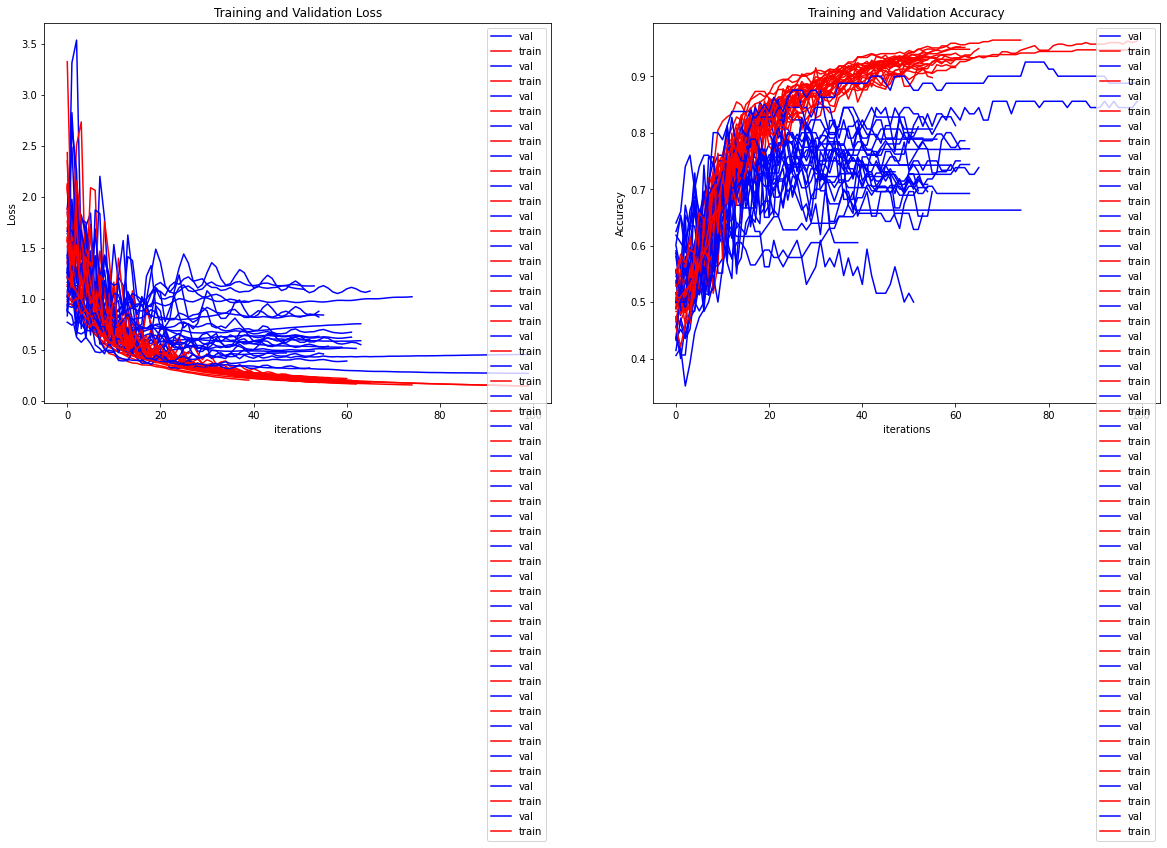

In [ ]:
n_val = 4 
data_folder = '/content/drive/MyDrive/cats'
output_dir = '/content/'
batch_size = 500
test_loss_tl, test_acc_lt, val_acc_tl=cross_validation_train(data_folder, output_dir, 'dino_vits16', 
                        n_val, batch_size, num_epochs=100, patience=35, lr=0.001, step_size=25, finetune=False)


Cat number for test:  1  index:  0


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [20 12  9  4]
test fraction:  0.02
validation fraction:  0.10
train fraction:  0.88
{'val': 48, 'train': 408, 'test': 8}
torch.Size([48, 384])
torch.Size([408, 384])
torch.Size([8, 384])
Variance ratio: [0.20561666 0.11035796 0.06533307 0.04227268 0.03896841 0.03398288
 0.02781455 0.02459498 0.02003768 0.01882691 0.01777397 0.01410205
 0.01293082 0.01231991 0.01187218 0.01074883 0.01033378 0.01006819
 0.00894159 0.00887258 0.00856544 0.00808122 0.00789907 0.00728314
 0.00709354 0.00666628 0.00638527 0.00602866 0.0057438  0.00537312
 0.00531738 0.00506913 0.0047148  0.00453251 0.00441432 0.00433607
 0.00416558 0.00404895 0.00395831 0.0037519  0.00355306 0.00343122
 0.00339786 0.00334556 0.00317059 0.00308638 0.00297365 0.00295028
 0.00283734 0.00279227]
Epoch 0/99
----------
train Loss: 1.9605 Acc: 0.5196
val Loss: 1.8531 Acc: 0.5000

Epoch 1/99
----------
train Loss: 1.9032 Acc: 0.5270
val Loss: 1.7761 Acc: 0.5208

Epoch 2/99
----------
train Loss: 1.8018 Acc: 0.5270


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 9/99
----------
train Loss: 1.0106 Acc: 0.6078
val Loss: 1.0468 Acc: 0.5625

Epoch 10/99
----------
train Loss: 0.9604 Acc: 0.6373
val Loss: 1.0125 Acc: 0.5625

Epoch 11/99
----------
train Loss: 0.9203 Acc: 0.6618
val Loss: 0.9696 Acc: 0.5833

Epoch 12/99
----------
train Loss: 0.8815 Acc: 0.6789
val Loss: 0.9117 Acc: 0.6250

Epoch 13/99
----------
train Loss: 0.8392 Acc: 0.6863
val Loss: 0.8387 Acc: 0.6667

Epoch 14/99
----------
train Loss: 0.7925 Acc: 0.7034
val Loss: 0.7552 Acc: 0.7500

Epoch 15/99
----------
train Loss: 0.7440 Acc: 0.7230
val Loss: 0.6689 Acc: 0.7708

Epoch 16/99
----------
train Loss: 0.6973 Acc: 0.7353
val Loss: 0.5877 Acc: 0.7708

Epoch 17/99
----------
train Loss: 0.6563 Acc: 0.7426
val Loss: 0.5178 Acc: 0.8125

Epoch 18/99
----------
train Loss: 0.6237 Acc: 0.7500
val Loss: 0.4635 Acc: 0.8333

Epoch 19/99
----------
train Loss: 0.6006 Acc: 0.7525
val Loss: 0.4260 Acc: 0.8750

Epoch 20/99
----------
train Loss: 0.5866 Acc: 0.7574
val Loss: 0.4027 Acc: 

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 26 27 29]
test fraction:  0.01
validation fraction:  0.16
train fraction:  0.83
{'val': 76, 'train': 384, 'test': 4}
torch.Size([76, 384])
torch.Size([384, 384])
torch.Size([4, 384])
Variance ratio: [0.23414615 0.11342469 0.06197799 0.03984988 0.03522722 0.03073104
 0.02797839 0.02423381 0.01904741 0.01857539 0.0165123  0.01494481
 0.01267634 0.0119887  0.01130525 0.01076025 0.00953257 0.00891967
 0.00874068 0.00859995 0.00794648 0.00772895 0.00722536 0.00691998
 0.00628143 0.00604217 0.00597059 0.00571966 0.00543094 0.00522271
 0.00510412 0.00484437 0.00459525 0.00442973 0.00424826 0.00424314
 0.00410001 0.00403064 0.0038393  0.00372747 0.00364891 0.00344286
 0.00338212 0.00318634 0.00307136 0.00305244 0.00299797 0.00290261
 0.00273331 0.00265954]
Epoch 0/99
----------
train Loss: 2.8935 Acc: 0.4714
val Loss: 2.2442 Acc: 0.5132

Epoch 1/99
----------
train Loss: 2.7606 Acc: 0.4714
val Loss: 2.0645 Acc: 0.5263

Epoch 2/99
----------
train Loss: 2.5269 Acc: 0.4609


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 12/99
----------
train Loss: 0.8843 Acc: 0.7005
val Loss: 1.2577 Acc: 0.6184

Epoch 13/99
----------
train Loss: 0.8425 Acc: 0.6953
val Loss: 1.2806 Acc: 0.6184

Epoch 14/99
----------
train Loss: 0.8104 Acc: 0.7135
val Loss: 1.2911 Acc: 0.6316

Epoch 15/99
----------
train Loss: 0.7840 Acc: 0.7344
val Loss: 1.2913 Acc: 0.6974

Epoch 16/99
----------
train Loss: 0.7587 Acc: 0.7500
val Loss: 1.2854 Acc: 0.6974

Epoch 17/99
----------
train Loss: 0.7326 Acc: 0.7526
val Loss: 1.2772 Acc: 0.7237

Epoch 18/99
----------
train Loss: 0.7069 Acc: 0.7708
val Loss: 1.2681 Acc: 0.7237

Epoch 19/99
----------
train Loss: 0.6839 Acc: 0.7839
val Loss: 1.2580 Acc: 0.7105

Epoch 20/99
----------
train Loss: 0.6651 Acc: 0.7786
val Loss: 1.2458 Acc: 0.6842

Epoch 21/99
----------
train Loss: 0.6499 Acc: 0.7812
val Loss: 1.2302 Acc: 0.6842

Epoch 22/99
----------
train Loss: 0.6357 Acc: 0.7891
val Loss: 1.2103 Acc: 0.6842

Epoch 23/99
----------
train Loss: 0.6195 Acc: 0.8047
val Loss: 1.1859 Acc: 

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [12 30 29 13]
test fraction:  0.01
validation fraction:  0.18
train fraction:  0.81
{'val': 84, 'train': 376, 'test': 4}
torch.Size([84, 384])
torch.Size([376, 384])
torch.Size([4, 384])
Variance ratio: [0.24662244 0.11827997 0.04363465 0.03890668 0.03468507 0.03077101
 0.02708495 0.02391619 0.02071349 0.01875249 0.01714191 0.01431398
 0.01188973 0.01165407 0.01103647 0.01018516 0.01006526 0.00995805
 0.00893747 0.00864367 0.008296   0.00781961 0.00727287 0.00694156
 0.00670436 0.00621699 0.00592553 0.00560072 0.00535217 0.00514182
 0.00500846 0.00489215 0.0046704  0.00460114 0.00441884 0.0042902
 0.00416126 0.00408099 0.00372117 0.00360649 0.00348555 0.00343417
 0.00340712 0.00328309 0.00305212 0.0029869  0.00296614 0.00287429
 0.00286077 0.00273706]
Epoch 0/99
----------
train Loss: 2.3833 Acc: 0.5027
val Loss: 1.6125 Acc: 0.5714

Epoch 1/99
----------
train Loss: 2.3031 Acc: 0.5027
val Loss: 1.5414 Acc: 0.5714

Epoch 2/99
----------
train Loss: 2.1635 Acc: 0.5239
v

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 19/99
----------
train Loss: 0.5851 Acc: 0.7846
val Loss: 0.9295 Acc: 0.7143

Epoch 20/99
----------
train Loss: 0.5712 Acc: 0.7952
val Loss: 0.9389 Acc: 0.7143

Epoch 21/99
----------
train Loss: 0.5627 Acc: 0.7926
val Loss: 0.9440 Acc: 0.7262

Epoch 22/99
----------
train Loss: 0.5544 Acc: 0.7979
val Loss: 0.9450 Acc: 0.7262

Epoch 23/99
----------
train Loss: 0.5432 Acc: 0.7952
val Loss: 0.9425 Acc: 0.7262

Epoch 24/99
----------
train Loss: 0.5279 Acc: 0.7979
val Loss: 0.9373 Acc: 0.7262

Epoch 25/99
----------
train Loss: 0.5091 Acc: 0.8085
val Loss: 0.9305 Acc: 0.7262

Epoch 26/99
----------
train Loss: 0.4886 Acc: 0.8298
val Loss: 0.9232 Acc: 0.7143

Epoch 27/99
----------
train Loss: 0.4685 Acc: 0.8378
val Loss: 0.9164 Acc: 0.7024

Epoch 28/99
----------
train Loss: 0.4505 Acc: 0.8431
val Loss: 0.9107 Acc: 0.6905

Epoch 29/99
----------
train Loss: 0.4358 Acc: 0.8431
val Loss: 0.9064 Acc: 0.6786

Epoch 30/99
----------
train Loss: 0.4246 Acc: 0.8404
val Loss: 0.9036 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [20 18 10 14]
test fraction:  0.04
validation fraction:  0.17
train fraction:  0.78
{'val': 80, 'train': 364, 'test': 20}
torch.Size([80, 384])
torch.Size([364, 384])
torch.Size([20, 384])
Variance ratio: [0.20474138 0.10210131 0.0698261  0.04349073 0.04172974 0.03263797
 0.03084116 0.02428091 0.02052835 0.01997645 0.01823137 0.01375682
 0.01245643 0.01216798 0.01189721 0.01105915 0.01028935 0.01008225
 0.00975416 0.00902516 0.00858562 0.00808159 0.00785274 0.00769508
 0.00708342 0.00653276 0.0063599  0.00617806 0.00554446 0.00544094
 0.00531665 0.00512609 0.00482492 0.00462541 0.00460534 0.0044945
 0.00424321 0.004171   0.00397813 0.00384094 0.00367108 0.00361466
 0.00347922 0.00330606 0.0032795  0.00318562 0.00302582 0.00292665
 0.0028941  0.00280937]
Epoch 0/99
----------
train Loss: 3.5351 Acc: 0.5082
val Loss: 1.7582 Acc: 0.5750

Epoch 1/99
----------
train Loss: 3.3897 Acc: 0.5027
val Loss: 1.6013 Acc: 0.6125

Epoch 2/99
----------
train Loss: 3.1270 Acc: 0.5110

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 1.0464 Acc: 0.7000

Epoch 19/99
----------
train Loss: 0.9913 Acc: 0.7225
val Loss: 1.0232 Acc: 0.7250

Epoch 20/99
----------
train Loss: 0.9532 Acc: 0.7390
val Loss: 0.9545 Acc: 0.7250

Epoch 21/99
----------
train Loss: 0.8993 Acc: 0.7582
val Loss: 0.8530 Acc: 0.7250

Epoch 22/99
----------
train Loss: 0.8344 Acc: 0.7610
val Loss: 0.7413 Acc: 0.7375

Epoch 23/99
----------
train Loss: 0.7686 Acc: 0.7692
val Loss: 0.6472 Acc: 0.7750

Epoch 24/99
----------
train Loss: 0.7132 Acc: 0.7747
val Loss: 0.5908 Acc: 0.7750

Epoch 25/99
----------
train Loss: 0.6756 Acc: 0.7775
val Loss: 0.5721 Acc: 0.7625

Epoch 26/99
----------
train Loss: 0.6558 Acc: 0.7802
val Loss: 0.5778 Acc: 0.7750

Epoch 27/99
----------
train Loss: 0.6480 Acc: 0.7720
val Loss: 0.5917 Acc: 0.7750

Epoch 28/99
----------
train Loss: 0.6441 Acc: 0.7692
val Loss: 0.6009 Acc: 0.7625

Epoch 29/99
----------
train Loss: 0.6367 Acc: 0.7692
val Loss: 0.5982 Acc: 0.7750

Epoch 30/99
----------
train Loss: 0.6206 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 16  8 26]
test fraction:  0.05
validation fraction:  0.16
train fraction:  0.79
{'val': 76, 'train': 366, 'test': 22}
torch.Size([76, 384])
torch.Size([366, 384])
torch.Size([22, 384])
Variance ratio: [0.23702094 0.09090964 0.0773552  0.04434388 0.03403348 0.03236319
 0.02852092 0.02601774 0.02035582 0.01825028 0.01619667 0.0138701
 0.01317956 0.01235329 0.01086567 0.01058846 0.00990319 0.0092885
 0.00852296 0.00804284 0.00752886 0.00733531 0.00704348 0.00687156
 0.00648858 0.00623673 0.00602347 0.00562616 0.0055307  0.00527585
 0.00508086 0.00486427 0.00477531 0.00457771 0.00435532 0.00419488
 0.00407669 0.00391885 0.00381784 0.00368507 0.00352032 0.00338243
 0.00333223 0.00315464 0.00314533 0.00311098 0.00297272 0.0028955
 0.00286853 0.00276015]
Epoch 0/99
----------
train Loss: 1.7082 Acc: 0.5546
val Loss: 1.4779 Acc: 0.6447

Epoch 1/99
----------
train Loss: 1.6750 Acc: 0.5601
val Loss: 1.4483 Acc: 0.6447

Epoch 2/99
----------
train Loss: 1.6177 Acc: 0.5683
v

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 1.1385 Acc: 0.7105

Epoch 10/99
----------
train Loss: 1.0036 Acc: 0.6721
val Loss: 1.1105 Acc: 0.6842

Epoch 11/99
----------
train Loss: 0.9395 Acc: 0.6858
val Loss: 1.0871 Acc: 0.6447

Epoch 12/99
----------
train Loss: 0.8833 Acc: 0.6967
val Loss: 1.0674 Acc: 0.6447

Epoch 13/99
----------
train Loss: 0.8339 Acc: 0.7131
val Loss: 1.0503 Acc: 0.6447

Epoch 14/99
----------
train Loss: 0.7899 Acc: 0.7377
val Loss: 1.0353 Acc: 0.6447

Epoch 15/99
----------
train Loss: 0.7506 Acc: 0.7514
val Loss: 1.0221 Acc: 0.6447

Epoch 16/99
----------
train Loss: 0.7152 Acc: 0.7705
val Loss: 1.0105 Acc: 0.6579

Epoch 17/99
----------
train Loss: 0.6836 Acc: 0.7705
val Loss: 1.0003 Acc: 0.6579

Epoch 18/99
----------
train Loss: 0.6555 Acc: 0.7814
val Loss: 0.9909 Acc: 0.6711

Epoch 19/99
----------
train Loss: 0.6303 Acc: 0.7923
val Loss: 0.9815 Acc: 0.6842

Epoch 20/99
----------
train Loss: 0.6073 Acc: 0.7978
val Loss: 0.9714 Acc: 0.6974

Epoch 21/99
----------
train Loss: 0.5858 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [30 12 11 16]
test fraction:  0.01
validation fraction:  0.18
train fraction:  0.81
{'val': 82, 'train': 378, 'test': 4}
torch.Size([82, 384])
torch.Size([378, 384])
torch.Size([4, 384])
Variance ratio: [0.23027762 0.10025652 0.07586806 0.0417712  0.03737666 0.03359516
 0.02858237 0.02565298 0.01847874 0.01748847 0.01660441 0.01345558
 0.01223281 0.01152011 0.01138231 0.01098304 0.01012886 0.00934326
 0.00854056 0.0081751  0.00788745 0.00778908 0.00705998 0.00675473
 0.00655258 0.00610986 0.00597506 0.00583052 0.0053265  0.00522738
 0.0050454  0.00487729 0.00476012 0.00465063 0.00435704 0.00429665
 0.00407294 0.00391359 0.00374774 0.00369347 0.00350448 0.00342183
 0.0031399  0.0030417  0.00299689 0.00298699 0.00288527 0.00285475
 0.00273957 0.00269855]
Epoch 0/99
----------
train Loss: 2.4262 Acc: 0.5794
val Loss: 1.6155 Acc: 0.5000

Epoch 1/99
----------
train Loss: 2.3320 Acc: 0.5794
val Loss: 1.5511 Acc: 0.5000

Epoch 2/99
----------
train Loss: 2.1599 Acc: 0.5767


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 13/99
----------
train Loss: 1.0087 Acc: 0.6958
val Loss: 1.2523 Acc: 0.6829

Epoch 14/99
----------
train Loss: 0.9818 Acc: 0.7011
val Loss: 1.2470 Acc: 0.6951

Epoch 15/99
----------
train Loss: 0.9340 Acc: 0.7222
val Loss: 1.2414 Acc: 0.6829

Epoch 16/99
----------
train Loss: 0.8696 Acc: 0.7275
val Loss: 1.2401 Acc: 0.6951

Epoch 17/99
----------
train Loss: 0.7958 Acc: 0.7407
val Loss: 1.2477 Acc: 0.6829

Epoch 18/99
----------
train Loss: 0.7215 Acc: 0.7513
val Loss: 1.2672 Acc: 0.6951

Epoch 19/99
----------
train Loss: 0.6555 Acc: 0.7804
val Loss: 1.2981 Acc: 0.7073

Epoch 20/99
----------
train Loss: 0.6042 Acc: 0.7910
val Loss: 1.3352 Acc: 0.6829

Epoch 21/99
----------
train Loss: 0.5699 Acc: 0.7963
val Loss: 1.3711 Acc: 0.6707

Epoch 22/99
----------
train Loss: 0.5507 Acc: 0.8069
val Loss: 1.3979 Acc: 0.6463

Epoch 23/99
----------
train Loss: 0.5420 Acc: 0.7937
val Loss: 1.4104 Acc: 0.6463

Epoch 24/99
----------
train Loss: 0.5374 Acc: 0.8016
val Loss: 1.4066 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 4 11 13 26]
test fraction:  0.03
validation fraction:  0.12
train fraction:  0.85
{'val': 56, 'train': 396, 'test': 12}
torch.Size([56, 384])
torch.Size([396, 384])
torch.Size([12, 384])
Variance ratio: [0.24194818 0.10125659 0.05113702 0.0431087  0.03568617 0.03300363
 0.02850956 0.02415117 0.02145519 0.01924816 0.01688565 0.01485049
 0.01275883 0.01185674 0.01113682 0.01006033 0.00975093 0.00953703
 0.00861032 0.00830791 0.00820119 0.00761475 0.00730247 0.0067387
 0.0063974  0.00623268 0.00617388 0.00594942 0.00577695 0.00536398
 0.00513971 0.00499775 0.00492624 0.00465077 0.00442406 0.00425671
 0.00410805 0.0040335  0.003914   0.0038193  0.0036948  0.00334587
 0.00331132 0.0032839  0.00320172 0.00309148 0.00300868 0.00294935
 0.00285198 0.00275955]
Epoch 0/99
----------
train Loss: 2.9151 Acc: 0.4116
val Loss: 2.6575 Acc: 0.3393

Epoch 1/99
----------
train Loss: 2.8198 Acc: 0.4167
val Loss: 2.5505 Acc: 0.3571

Epoch 2/99
----------
train Loss: 2.6488 Acc: 0.4293

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 11/99
----------
train Loss: 1.1786 Acc: 0.6389
val Loss: 1.1959 Acc: 0.5179

Epoch 12/99
----------
train Loss: 1.1035 Acc: 0.6515
val Loss: 1.1324 Acc: 0.5357

Epoch 13/99
----------
train Loss: 1.0303 Acc: 0.6591
val Loss: 1.0820 Acc: 0.5536

Epoch 14/99
----------
train Loss: 0.9552 Acc: 0.6818
val Loss: 1.0484 Acc: 0.5893

Epoch 15/99
----------
train Loss: 0.8768 Acc: 0.6970
val Loss: 1.0342 Acc: 0.6071

Epoch 16/99
----------
train Loss: 0.7976 Acc: 0.7096
val Loss: 1.0383 Acc: 0.6071

Epoch 17/99
----------
train Loss: 0.7243 Acc: 0.7500
val Loss: 1.0579 Acc: 0.6607

Epoch 18/99
----------
train Loss: 0.6651 Acc: 0.7626
val Loss: 1.0884 Acc: 0.6964

Epoch 19/99
----------
train Loss: 0.6250 Acc: 0.7727
val Loss: 1.1235 Acc: 0.6786

Epoch 20/99
----------
train Loss: 0.6024 Acc: 0.7753
val Loss: 1.1559 Acc: 0.6786

Epoch 21/99
----------
train Loss: 0.5912 Acc: 0.7753
val Loss: 1.1798 Acc: 0.6607

Epoch 22/99
----------
train Loss: 0.5847 Acc: 0.7828
val Loss: 1.1915 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16  8 18  1]
test fraction:  0.05
validation fraction:  0.16
train fraction:  0.79
{'val': 74, 'train': 366, 'test': 24}
torch.Size([74, 384])
torch.Size([366, 384])
torch.Size([24, 384])
Variance ratio: [0.21450015 0.09015126 0.08067171 0.04398018 0.04167277 0.03565551
 0.02996895 0.02350522 0.02080136 0.01932189 0.01767149 0.01356859
 0.01301693 0.01237195 0.0110266  0.01050259 0.01018606 0.00968885
 0.00884269 0.00855353 0.00821517 0.00758551 0.00714217 0.00697968
 0.00657429 0.00638421 0.00612634 0.00570168 0.00562329 0.00535309
 0.00501449 0.00480494 0.00467932 0.0044855  0.00440323 0.00421175
 0.00419575 0.00409999 0.00394703 0.00389738 0.00360337 0.00345893
 0.00336872 0.00329843 0.00319753 0.00311717 0.00298789 0.00284287
 0.00280602 0.00275449]
Epoch 0/99
----------
train Loss: 2.9668 Acc: 0.5055
val Loss: 2.4270 Acc: 0.4459

Epoch 1/99
----------
train Loss: 2.8055 Acc: 0.5000
val Loss: 2.2435 Acc: 0.4595

Epoch 2/99
----------
train Loss: 2.5214 Acc: 0.516

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7975 Acc: 0.7295
val Loss: 1.1048 Acc: 0.6351

Epoch 18/99
----------
train Loss: 0.7659 Acc: 0.7404
val Loss: 1.0178 Acc: 0.6486

Epoch 19/99
----------
train Loss: 0.7044 Acc: 0.7760
val Loss: 0.9153 Acc: 0.6892

Epoch 20/99
----------
train Loss: 0.6357 Acc: 0.7951
val Loss: 0.8186 Acc: 0.6757

Epoch 21/99
----------
train Loss: 0.5829 Acc: 0.8087
val Loss: 0.7438 Acc: 0.6892

Epoch 22/99
----------
train Loss: 0.5577 Acc: 0.8251
val Loss: 0.6974 Acc: 0.7027

Epoch 23/99
----------
train Loss: 0.5578 Acc: 0.8005
val Loss: 0.6751 Acc: 0.7162

Epoch 24/99
----------
train Loss: 0.5712 Acc: 0.7896
val Loss: 0.6676 Acc: 0.7027

Epoch 25/99
----------
train Loss: 0.5831 Acc: 0.7842
val Loss: 0.6663 Acc: 0.7027

Epoch 26/99
----------
train Loss: 0.5829 Acc: 0.7923
val Loss: 0.6665 Acc: 0.7027

Epoch 27/99
----------
train Loss: 0.5676 Acc: 0.7978
val Loss: 0.6678 Acc: 0.6892

Epoch 28/99
----------
train Loss: 0.5420 Acc: 0.8033
val Loss: 0.6722 Acc: 0.6757

Epoch 29/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [21  5  9 28]
test fraction:  0.04
validation fraction:  0.13
train fraction:  0.83
{'val': 60, 'train': 384, 'test': 20}
torch.Size([60, 384])
torch.Size([384, 384])
torch.Size([20, 384])
Variance ratio: [0.18134378 0.10811565 0.07727019 0.04379881 0.04038315 0.03092203
 0.02982068 0.02746729 0.02133977 0.02021561 0.01740817 0.01367335
 0.01332875 0.01287575 0.01219136 0.01137902 0.01085486 0.00973764
 0.00951622 0.00923656 0.00885592 0.00856854 0.00825197 0.00767
 0.00736571 0.00648066 0.00633799 0.00623183 0.00555574 0.00536579
 0.00525037 0.00506571 0.00496755 0.00476576 0.00469967 0.00461311
 0.0044727  0.00419337 0.00409775 0.00395559 0.00384081 0.00364633
 0.00355661 0.00341881 0.00337852 0.00320172 0.00310643 0.00299444
 0.00297718 0.00289152]
Epoch 0/99
----------
train Loss: 1.8836 Acc: 0.5599
val Loss: 1.9520 Acc: 0.4833

Epoch 1/99
----------
train Loss: 1.8527 Acc: 0.5625
val Loss: 1.9182 Acc: 0.4833

Epoch 2/99
----------
train Loss: 1.7958 Acc: 0.5755
v

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 14/99
----------
train Loss: 0.7736 Acc: 0.7266
val Loss: 0.6972 Acc: 0.7000

Epoch 15/99
----------
train Loss: 0.7345 Acc: 0.7318
val Loss: 0.6935 Acc: 0.7167

Epoch 16/99
----------
train Loss: 0.7023 Acc: 0.7500
val Loss: 0.6956 Acc: 0.7000

Epoch 17/99
----------
train Loss: 0.6746 Acc: 0.7578
val Loss: 0.6969 Acc: 0.6833

Epoch 18/99
----------
train Loss: 0.6499 Acc: 0.7578
val Loss: 0.6943 Acc: 0.6833

Epoch 19/99
----------
train Loss: 0.6270 Acc: 0.7630
val Loss: 0.6879 Acc: 0.6833

Epoch 20/99
----------
train Loss: 0.6055 Acc: 0.7682
val Loss: 0.6790 Acc: 0.6833

Epoch 21/99
----------
train Loss: 0.5853 Acc: 0.7760
val Loss: 0.6693 Acc: 0.7000

Epoch 22/99
----------
train Loss: 0.5664 Acc: 0.7839
val Loss: 0.6602 Acc: 0.7333

Epoch 23/99
----------
train Loss: 0.5489 Acc: 0.7891
val Loss: 0.6524 Acc: 0.7333

Epoch 24/99
----------
train Loss: 0.5326 Acc: 0.7917
val Loss: 0.6465 Acc: 0.7333

Epoch 25/99
----------
train Loss: 0.5172 Acc: 0.7969
val Loss: 0.6425 Acc: 

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [29 22 28  6]
test fraction:  0.03
validation fraction:  0.16
train fraction:  0.81
{'val': 76, 'train': 374, 'test': 14}
torch.Size([76, 384])
torch.Size([374, 384])
torch.Size([14, 384])
Variance ratio: [0.23835102 0.09383673 0.06574926 0.04367612 0.03407596 0.03326105
 0.03027454 0.02505643 0.02164545 0.01881486 0.01543342 0.01449262
 0.01245261 0.01178156 0.01080005 0.01040266 0.00994426 0.00960624
 0.00925355 0.00880427 0.00808837 0.00777002 0.00722967 0.00672303
 0.0064207  0.00609482 0.00582372 0.00566454 0.00535768 0.00531318
 0.00502756 0.00496528 0.00463236 0.00451093 0.00448453 0.00437853
 0.00420309 0.00411863 0.00390599 0.00377053 0.00358265 0.00349555
 0.00345992 0.0032499  0.00313177 0.00305    0.00298623 0.00291887
 0.00289471 0.00277797]
Epoch 0/99
----------
train Loss: 1.6387 Acc: 0.5749
val Loss: 1.0847 Acc: 0.6711

Epoch 1/99
----------
train Loss: 1.5825 Acc: 0.5749
val Loss: 1.0689 Acc: 0.6711

Epoch 2/99
----------
train Loss: 1.4879 Acc: 0.580

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.9420 Acc: 0.6447

Epoch 13/99
----------
train Loss: 0.6684 Acc: 0.7647
val Loss: 0.9334 Acc: 0.6974

Epoch 14/99
----------
train Loss: 0.6452 Acc: 0.7647
val Loss: 0.9236 Acc: 0.6974

Epoch 15/99
----------
train Loss: 0.6222 Acc: 0.7727
val Loss: 0.9131 Acc: 0.6974

Epoch 16/99
----------
train Loss: 0.5971 Acc: 0.7807
val Loss: 0.9042 Acc: 0.7237

Epoch 17/99
----------
train Loss: 0.5708 Acc: 0.7941
val Loss: 0.8993 Acc: 0.7105

Epoch 18/99
----------
train Loss: 0.5465 Acc: 0.7995
val Loss: 0.8999 Acc: 0.7105

Epoch 19/99
----------
train Loss: 0.5265 Acc: 0.8048
val Loss: 0.9049 Acc: 0.7105

Epoch 20/99
----------
train Loss: 0.5116 Acc: 0.8262
val Loss: 0.9118 Acc: 0.7105

Epoch 21/99
----------
train Loss: 0.5002 Acc: 0.8262
val Loss: 0.9173 Acc: 0.6974

Epoch 22/99
----------
train Loss: 0.4897 Acc: 0.8262
val Loss: 0.9190 Acc: 0.6842

Epoch 23/99
----------
train Loss: 0.4777 Acc: 0.8289
val Loss: 0.9161 Acc: 0.6842

Epoch 24/99
----------
train Loss: 0.4633 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [20  9 22 25]
test fraction:  0.03
validation fraction:  0.18
train fraction:  0.80
{'val': 82, 'train': 370, 'test': 12}
torch.Size([82, 384])
torch.Size([370, 384])
torch.Size([12, 384])
Variance ratio: [0.19451936 0.12106737 0.0693793  0.04291658 0.04019651 0.03521844
 0.02883595 0.02536641 0.0208221  0.01796579 0.01672194 0.01503052
 0.01334563 0.01264629 0.0119452  0.0109509  0.01033661 0.01020363
 0.00937466 0.00886817 0.00861575 0.00798551 0.00746804 0.00736069
 0.00715118 0.00668859 0.00612119 0.00587142 0.00542855 0.00515188
 0.00495108 0.00480033 0.00472357 0.00452162 0.00449856 0.00429753
 0.00405328 0.00384795 0.00371551 0.00367801 0.00346545 0.00346164
 0.00328644 0.00318278 0.00305194 0.00298022 0.00294421 0.00285825
 0.00283948 0.00281774]
Epoch 0/99
----------
train Loss: 4.0099 Acc: 0.4595
val Loss: 4.2128 Acc: 0.4390

Epoch 1/99
----------
train Loss: 3.8214 Acc: 0.4541
val Loss: 3.7609 Acc: 0.4146

Epoch 2/99
----------
train Loss: 3.4790 Acc: 0.454

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 19/99
----------
train Loss: 0.9556 Acc: 0.7027
val Loss: 1.2044 Acc: 0.6585

Epoch 20/99
----------
train Loss: 0.9177 Acc: 0.7243
val Loss: 1.0859 Acc: 0.7073

Epoch 21/99
----------
train Loss: 0.8602 Acc: 0.7405
val Loss: 0.9545 Acc: 0.7805

Epoch 22/99
----------
train Loss: 0.7971 Acc: 0.7459
val Loss: 0.8497 Acc: 0.7927

Epoch 23/99
----------
train Loss: 0.7459 Acc: 0.7568
val Loss: 0.7892 Acc: 0.8049

Epoch 24/99
----------
train Loss: 0.7149 Acc: 0.7541
val Loss: 0.7699 Acc: 0.8049

Epoch 25/99
----------
train Loss: 0.7020 Acc: 0.7568
val Loss: 0.7763 Acc: 0.7439

Epoch 26/99
----------
train Loss: 0.6995 Acc: 0.7784
val Loss: 0.7882 Acc: 0.7317

Epoch 27/99
----------
train Loss: 0.6974 Acc: 0.7784
val Loss: 0.7880 Acc: 0.7317

Epoch 28/99
----------
train Loss: 0.6873 Acc: 0.7865
val Loss: 0.7673 Acc: 0.7561

Epoch 29/99
----------
train Loss: 0.6653 Acc: 0.7811
val Loss: 0.7282 Acc: 0.7561

Epoch 30/99
----------
train Loss: 0.6331 Acc: 0.7811
val Loss: 0.6812 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 4 16 20 12]
test fraction:  0.05
validation fraction:  0.11
train fraction:  0.84
{'val': 52, 'train': 390, 'test': 22}
torch.Size([52, 384])
torch.Size([390, 384])
torch.Size([22, 384])
Variance ratio: [0.24158906 0.11102038 0.04745622 0.04328785 0.04067984 0.03083793
 0.02627754 0.02287515 0.01923363 0.01830166 0.01735911 0.01416749
 0.01200772 0.01159279 0.01107481 0.01084658 0.01030276 0.00928263
 0.00885379 0.00810492 0.0079609  0.00770674 0.00731128 0.00685443
 0.00657659 0.00639367 0.00609313 0.00590662 0.00540893 0.00528582
 0.00504909 0.00497559 0.00491389 0.00456767 0.00437223 0.00432879
 0.00408312 0.00394251 0.00389872 0.00379026 0.00343049 0.00339064
 0.00326871 0.00319278 0.00316988 0.00305144 0.00292104 0.00281026
 0.0027828  0.0027225 ]
Epoch 0/99
----------
train Loss: 1.3705 Acc: 0.5897
val Loss: 0.8775 Acc: 0.6538

Epoch 1/99
----------
train Loss: 1.3533 Acc: 0.5974
val Loss: 0.8539 Acc: 0.6731

Epoch 2/99
----------
train Loss: 1.3213 Acc: 0.605

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 12/99
----------
train Loss: 0.7854 Acc: 0.7333
val Loss: 0.5165 Acc: 0.8462

Epoch 13/99
----------
train Loss: 0.7495 Acc: 0.7487
val Loss: 0.5060 Acc: 0.8462

Epoch 14/99
----------
train Loss: 0.7172 Acc: 0.7564
val Loss: 0.4982 Acc: 0.8462

Epoch 15/99
----------
train Loss: 0.6878 Acc: 0.7564
val Loss: 0.4925 Acc: 0.8462

Epoch 16/99
----------
train Loss: 0.6607 Acc: 0.7564
val Loss: 0.4886 Acc: 0.8462

Epoch 17/99
----------
train Loss: 0.6356 Acc: 0.7667
val Loss: 0.4860 Acc: 0.8462

Epoch 18/99
----------
train Loss: 0.6122 Acc: 0.7667
val Loss: 0.4843 Acc: 0.8654

Epoch 19/99
----------
train Loss: 0.5905 Acc: 0.7821
val Loss: 0.4833 Acc: 0.8654

Epoch 20/99
----------
train Loss: 0.5703 Acc: 0.7872
val Loss: 0.4826 Acc: 0.8462

Epoch 21/99
----------
train Loss: 0.5518 Acc: 0.7923
val Loss: 0.4821 Acc: 0.8269

Epoch 22/99
----------
train Loss: 0.5348 Acc: 0.8051
val Loss: 0.4818 Acc: 0.8077

Epoch 23/99
----------
train Loss: 0.5196 Acc: 0.8051
val Loss: 0.4814 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [21 11  8 16]
test fraction:  0.06
validation fraction:  0.14
train fraction:  0.81
{'val': 64, 'train': 374, 'test': 26}
torch.Size([64, 384])
torch.Size([374, 384])
torch.Size([26, 384])
Variance ratio: [0.23061539 0.09101275 0.07713127 0.04314558 0.03921862 0.03447817
 0.02978558 0.02475867 0.02173427 0.01826241 0.01631194 0.01331865
 0.01198355 0.01142103 0.01087925 0.0101204  0.00954378 0.00940768
 0.00868083 0.00850383 0.00827606 0.00728317 0.0069973  0.00670918
 0.00654204 0.006473   0.00594768 0.00567074 0.0055344  0.00528751
 0.00504698 0.00479943 0.00470682 0.00467037 0.00448237 0.0043007
 0.00416456 0.00386626 0.00381534 0.00371482 0.00347206 0.0033819
 0.00324155 0.00314031 0.00310528 0.00307885 0.00296774 0.00287781
 0.00275623 0.00267611]
Epoch 0/99
----------
train Loss: 2.6670 Acc: 0.5455
val Loss: 2.6295 Acc: 0.5938

Epoch 1/99
----------
train Loss: 2.5386 Acc: 0.5508
val Loss: 2.5320 Acc: 0.5938

Epoch 2/99
----------
train Loss: 2.3122 Acc: 0.5615


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 1.1266 Acc: 0.7188

Epoch 10/99
----------
train Loss: 1.1358 Acc: 0.6417
val Loss: 0.9839 Acc: 0.7656

Epoch 11/99
----------
train Loss: 1.0626 Acc: 0.6604
val Loss: 0.8639 Acc: 0.7812

Epoch 12/99
----------
train Loss: 1.0151 Acc: 0.6658
val Loss: 0.7722 Acc: 0.7656

Epoch 13/99
----------
train Loss: 0.9910 Acc: 0.6791
val Loss: 0.7070 Acc: 0.7656

Epoch 14/99
----------
train Loss: 0.9738 Acc: 0.6791
val Loss: 0.6620 Acc: 0.7656

Epoch 15/99
----------
train Loss: 0.9496 Acc: 0.6925
val Loss: 0.6329 Acc: 0.7656

Epoch 16/99
----------
train Loss: 0.9111 Acc: 0.7139
val Loss: 0.6204 Acc: 0.7812

Epoch 17/99
----------
train Loss: 0.8560 Acc: 0.7273
val Loss: 0.6290 Acc: 0.8125

Epoch 18/99
----------
train Loss: 0.7872 Acc: 0.7326
val Loss: 0.6641 Acc: 0.8281

Epoch 19/99
----------
train Loss: 0.7141 Acc: 0.7540
val Loss: 0.7275 Acc: 0.7969

Epoch 20/99
----------
train Loss: 0.6509 Acc: 0.7781
val Loss: 0.8147 Acc: 0.7656

Epoch 21/99
----------
train Loss: 0.6106 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [28 29 10  3]
test fraction:  0.06
validation fraction:  0.11
train fraction:  0.83
{'val': 52, 'train': 384, 'test': 28}
torch.Size([52, 384])
torch.Size([384, 384])
torch.Size([28, 384])
Variance ratio: [0.22349473 0.10628928 0.06255645 0.04170643 0.03838564 0.03208358
 0.03158052 0.02398351 0.02218671 0.01749749 0.01683814 0.01348645
 0.01255077 0.0119819  0.01166236 0.01089412 0.01025967 0.00952541
 0.00895413 0.00853521 0.00801925 0.00745781 0.00710946 0.00663737
 0.00642358 0.00637456 0.00607246 0.00596321 0.00549403 0.0051678
 0.00508674 0.00494459 0.00478441 0.00457978 0.00451541 0.00444765
 0.00418956 0.00413978 0.00402201 0.003754   0.00353028 0.00338341
 0.0033459  0.0032421  0.00311203 0.0030598  0.00301915 0.00294732
 0.00284198 0.00273182]
Epoch 0/99
----------
train Loss: 2.8741 Acc: 0.4583
val Loss: 1.6307 Acc: 0.6538

Epoch 1/99
----------
train Loss: 2.8073 Acc: 0.4688
val Loss: 1.5758 Acc: 0.6538

Epoch 2/99
----------
train Loss: 2.6851 Acc: 0.4766

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.7999 Acc: 0.7308

Epoch 15/99
----------
train Loss: 0.8726 Acc: 0.6927
val Loss: 0.8056 Acc: 0.7308

Epoch 16/99
----------
train Loss: 0.8334 Acc: 0.7161
val Loss: 0.8178 Acc: 0.7308

Epoch 17/99
----------
train Loss: 0.8030 Acc: 0.7266
val Loss: 0.8378 Acc: 0.7308

Epoch 18/99
----------
train Loss: 0.7795 Acc: 0.7318
val Loss: 0.8661 Acc: 0.7308

Epoch 19/99
----------
train Loss: 0.7616 Acc: 0.7396
val Loss: 0.9003 Acc: 0.7308

Epoch 20/99
----------
train Loss: 0.7473 Acc: 0.7604
val Loss: 0.9363 Acc: 0.7308

Epoch 21/99
----------
train Loss: 0.7343 Acc: 0.7604
val Loss: 0.9697 Acc: 0.7115

Epoch 22/99
----------
train Loss: 0.7203 Acc: 0.7630
val Loss: 0.9965 Acc: 0.7115

Epoch 23/99
----------
train Loss: 0.7038 Acc: 0.7682
val Loss: 1.0150 Acc: 0.7115

Epoch 24/99
----------
train Loss: 0.6842 Acc: 0.7682
val Loss: 1.0249 Acc: 0.6923

Epoch 25/99
----------
train Loss: 0.6618 Acc: 0.7786
val Loss: 1.0279 Acc: 0.6923

Epoch 26/99
----------
train Loss: 0.6375 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 5 28 22 20]
test fraction:  0.06
validation fraction:  0.13
train fraction:  0.81
{'val': 60, 'train': 378, 'test': 26}
torch.Size([60, 384])
torch.Size([378, 384])
torch.Size([26, 384])
Variance ratio: [0.21492135 0.10330254 0.06680954 0.04496623 0.03935716 0.03203556
 0.03017976 0.02380713 0.02087439 0.01980883 0.01666386 0.01440386
 0.01267638 0.01208593 0.01156178 0.01132237 0.01030506 0.00980182
 0.00916181 0.00882386 0.00846807 0.00796666 0.00781128 0.00738939
 0.00677929 0.00613933 0.00590553 0.00564268 0.00561644 0.00539389
 0.00524002 0.00501218 0.00470087 0.00465995 0.00451419 0.0043774
 0.00418256 0.00398056 0.00392729 0.00375434 0.00365766 0.00357124
 0.00337116 0.00317051 0.0031497  0.00305036 0.00295981 0.00295352
 0.00287264 0.00279441]
Epoch 0/99
----------
train Loss: 4.0674 Acc: 0.4524
val Loss: 3.9415 Acc: 0.4833

Epoch 1/99
----------
train Loss: 3.8128 Acc: 0.4497
val Loss: 3.3676 Acc: 0.4667

Epoch 2/99
----------
train Loss: 3.3549 Acc: 0.4471

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)




Epoch 15/99
----------
train Loss: 0.8430 Acc: 0.7196
val Loss: 0.8998 Acc: 0.5833

Epoch 16/99
----------
train Loss: 0.8898 Acc: 0.7143
val Loss: 0.9552 Acc: 0.6167

Epoch 17/99
----------
train Loss: 0.9148 Acc: 0.6984
val Loss: 0.9529 Acc: 0.6500

Epoch 18/99
----------
train Loss: 0.8985 Acc: 0.7196
val Loss: 0.8857 Acc: 0.6667

Epoch 19/99
----------
train Loss: 0.8435 Acc: 0.7354
val Loss: 0.7825 Acc: 0.6667

Epoch 20/99
----------
train Loss: 0.7674 Acc: 0.7593
val Loss: 0.6921 Acc: 0.6667

Epoch 21/99
----------
train Loss: 0.6934 Acc: 0.7778
val Loss: 0.6565 Acc: 0.7167

Epoch 22/99
----------
train Loss: 0.6405 Acc: 0.8095
val Loss: 0.6867 Acc: 0.6833

Epoch 23/99
----------
train Loss: 0.6163 Acc: 0.8069
val Loss: 0.7607 Acc: 0.7167

Epoch 24/99
----------
train Loss: 0.6181 Acc: 0.8095
val Loss: 0.8438 Acc: 0.7167

Epoch 25/99
----------
train Loss: 0.6344 Acc: 0.8016
val Loss: 0.9084 Acc: 0.7000

Epoch 26/99
----------
train Loss: 0.6505 Acc: 0.7910
val Loss: 0.9394 Acc

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [24 11  8 20]
test fraction:  0.04
validation fraction:  0.12
train fraction:  0.84
{'val': 56, 'train': 390, 'test': 18}
torch.Size([56, 384])
torch.Size([390, 384])
torch.Size([18, 384])
Variance ratio: [0.21553531 0.08492839 0.06855048 0.04550005 0.04010861 0.03466138
 0.03062028 0.02406641 0.02209602 0.01745268 0.01597136 0.01490563
 0.01309584 0.01205795 0.01111252 0.01088186 0.0106191  0.01017385
 0.01011624 0.00916454 0.00887043 0.00869148 0.0078748  0.00738871
 0.00678258 0.00642861 0.00631468 0.00615159 0.00601821 0.00543735
 0.00526054 0.005099   0.005042   0.0047117  0.00462788 0.00437968
 0.00429651 0.00418211 0.00390995 0.00382558 0.00371441 0.00369897
 0.00341751 0.00338777 0.00321107 0.00317148 0.00305662 0.00301389
 0.00293378 0.00289956]
Epoch 0/99
----------
train Loss: 2.3134 Acc: 0.4744
val Loss: 2.4359 Acc: 0.5357

Epoch 1/99
----------
train Loss: 2.2559 Acc: 0.4769
val Loss: 2.3113 Acc: 0.5536

Epoch 2/99
----------
train Loss: 2.1497 Acc: 0.476

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5918 Acc: 0.7744
val Loss: 0.6538 Acc: 0.7679

Epoch 18/99
----------
train Loss: 0.5781 Acc: 0.7897
val Loss: 0.6595 Acc: 0.8036

Epoch 19/99
----------
train Loss: 0.5658 Acc: 0.7974
val Loss: 0.6636 Acc: 0.8214

Epoch 20/99
----------
train Loss: 0.5549 Acc: 0.8103
val Loss: 0.6646 Acc: 0.8214

Epoch 21/99
----------
train Loss: 0.5450 Acc: 0.8128
val Loss: 0.6614 Acc: 0.8214

Epoch 22/99
----------
train Loss: 0.5353 Acc: 0.8179
val Loss: 0.6536 Acc: 0.8214

Epoch 23/99
----------
train Loss: 0.5250 Acc: 0.8231
val Loss: 0.6418 Acc: 0.8214

Epoch 24/99
----------
train Loss: 0.5136 Acc: 0.8231
val Loss: 0.6267 Acc: 0.8214

Epoch 25/99
----------
train Loss: 0.5011 Acc: 0.8308
val Loss: 0.6097 Acc: 0.8214

Epoch 26/99
----------
train Loss: 0.4880 Acc: 0.8333
val Loss: 0.5921 Acc: 0.8036

Epoch 27/99
----------
train Loss: 0.4748 Acc: 0.8410
val Loss: 0.5753 Acc: 0.8036

Epoch 28/99
----------
train Loss: 0.4623 Acc: 0.8462
val Loss: 0.5601 Acc: 0.8214

Epoch 29/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [19 12 18 28]
test fraction:  0.02
validation fraction:  0.13
train fraction:  0.85
{'val': 62, 'train': 394, 'test': 8}
torch.Size([62, 384])
torch.Size([394, 384])
torch.Size([8, 384])
Variance ratio: [0.22388456 0.08641543 0.07032379 0.04463402 0.04076871 0.03393919
 0.02896874 0.02230992 0.02083016 0.01672267 0.01593745 0.01442828
 0.0130055  0.01240061 0.011816   0.01132    0.01023061 0.00963392
 0.00934996 0.00907914 0.00855728 0.00810028 0.00783584 0.00714879
 0.00694942 0.00666059 0.00640836 0.0059814  0.0056631  0.00554998
 0.00518393 0.00492328 0.00470291 0.00456815 0.00451222 0.00444228
 0.00425397 0.00410659 0.00397221 0.00375781 0.0036137  0.00347885
 0.00337839 0.00328685 0.0031833  0.00309523 0.00301055 0.00297667
 0.00289579 0.00287633]
Epoch 0/99
----------
train Loss: 2.3723 Acc: 0.4670
val Loss: 3.0600 Acc: 0.5161

Epoch 1/99
----------
train Loss: 2.2985 Acc: 0.4670
val Loss: 2.8464 Acc: 0.5161

Epoch 2/99
----------
train Loss: 2.1727 Acc: 0.4645


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)




Epoch 16/99
----------
train Loss: 0.7466 Acc: 0.7310
val Loss: 0.4989 Acc: 0.7258

Epoch 17/99
----------
train Loss: 0.7026 Acc: 0.7335
val Loss: 0.4808 Acc: 0.7581

Epoch 18/99
----------
train Loss: 0.6648 Acc: 0.7563
val Loss: 0.4855 Acc: 0.7903

Epoch 19/99
----------
train Loss: 0.6360 Acc: 0.7690
val Loss: 0.5067 Acc: 0.7742

Epoch 20/99
----------
train Loss: 0.6158 Acc: 0.7893
val Loss: 0.5348 Acc: 0.7742

Epoch 21/99
----------
train Loss: 0.6011 Acc: 0.7944
val Loss: 0.5607 Acc: 0.7903

Epoch 22/99
----------
train Loss: 0.5882 Acc: 0.7843
val Loss: 0.5787 Acc: 0.7903

Epoch 23/99
----------
train Loss: 0.5745 Acc: 0.7817
val Loss: 0.5863 Acc: 0.7742

Epoch 24/99
----------
train Loss: 0.5590 Acc: 0.7817
val Loss: 0.5842 Acc: 0.7742

Epoch 25/99
----------
train Loss: 0.5422 Acc: 0.7843
val Loss: 0.5750 Acc: 0.7581

Epoch 26/99
----------
train Loss: 0.5252 Acc: 0.7919
val Loss: 0.5621 Acc: 0.7581

Epoch 27/99
----------
train Loss: 0.5092 Acc: 0.7995
val Loss: 0.5486 Acc

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [13  3 24 25]
test fraction:  0.02
validation fraction:  0.16
train fraction:  0.82
{'val': 72, 'train': 382, 'test': 10}
torch.Size([72, 384])
torch.Size([382, 384])
torch.Size([10, 384])
Variance ratio: [0.22980116 0.11386176 0.05247067 0.04195529 0.03870426 0.03211683
 0.0286202  0.02488818 0.01974248 0.01761746 0.01578267 0.01453721
 0.01281811 0.01193229 0.0111896  0.01065456 0.01032695 0.01019616
 0.00915272 0.00890313 0.00822193 0.0080514  0.00773412 0.00708912
 0.00693125 0.00621517 0.00618421 0.00586057 0.00563618 0.00527983
 0.00514678 0.00491702 0.0046676  0.00456304 0.00439451 0.00425227
 0.00416169 0.00402453 0.00377611 0.00366903 0.00358414 0.00344004
 0.00334897 0.00331703 0.00317618 0.00314416 0.00303755 0.00299992
 0.00288258 0.00272499]
Epoch 0/99
----------
train Loss: 2.0101 Acc: 0.5314
val Loss: 2.8421 Acc: 0.5278

Epoch 1/99
----------
train Loss: 1.9533 Acc: 0.5471
val Loss: 2.7822 Acc: 0.5278

Epoch 2/99
----------
train Loss: 1.8574 Acc: 0.555

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 21/99
----------
train Loss: 0.6028 Acc: 0.7461
val Loss: 0.5026 Acc: 0.7917

Epoch 22/99
----------
train Loss: 0.5961 Acc: 0.7435
val Loss: 0.5054 Acc: 0.7778

Epoch 23/99
----------
train Loss: 0.5887 Acc: 0.7487
val Loss: 0.4988 Acc: 0.7778

Epoch 24/99
----------
train Loss: 0.5786 Acc: 0.7539
val Loss: 0.4838 Acc: 0.8056

Epoch 25/99
----------
train Loss: 0.5654 Acc: 0.7592
val Loss: 0.4630 Acc: 0.8194

Epoch 26/99
----------
train Loss: 0.5500 Acc: 0.7749
val Loss: 0.4403 Acc: 0.8194

Epoch 27/99
----------
train Loss: 0.5341 Acc: 0.7801
val Loss: 0.4188 Acc: 0.8056

Epoch 28/99
----------
train Loss: 0.5192 Acc: 0.7827
val Loss: 0.4009 Acc: 0.8472

Epoch 29/99
----------
train Loss: 0.5061 Acc: 0.7880
val Loss: 0.3876 Acc: 0.8472

Epoch 30/99
----------
train Loss: 0.4946 Acc: 0.8089
val Loss: 0.3791 Acc: 0.8472

Epoch 31/99
----------
train Loss: 0.4837 Acc: 0.8141
val Loss: 0.3750 Acc: 0.8611

Epoch 32/99
----------
train Loss: 0.4727 Acc: 0.8141
val Loss: 0.3749 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [23 24 12  8]
test fraction:  0.06
validation fraction:  0.14
train fraction:  0.80
{'val': 66, 'train': 372, 'test': 26}
torch.Size([66, 384])
torch.Size([372, 384])
torch.Size([26, 384])
Variance ratio: [0.21660533 0.10764252 0.07453142 0.04345411 0.03890432 0.03204974
 0.02899926 0.02347258 0.01907453 0.01818401 0.01692954 0.01490901
 0.01308364 0.01183849 0.01157555 0.01080974 0.01030011 0.00930369
 0.0090673  0.00836156 0.00824933 0.00755849 0.0074632  0.0073021
 0.00676233 0.00619326 0.00590501 0.00560614 0.00549469 0.00532725
 0.00508436 0.00484852 0.00473774 0.00468136 0.00442831 0.00419089
 0.00410884 0.00390545 0.00386936 0.00362372 0.0035464  0.0034166
 0.0033219  0.00324432 0.00312819 0.00300066 0.00295627 0.00281264
 0.00276729 0.0027103 ]
Epoch 0/99
----------
train Loss: 3.2736 Acc: 0.4731
val Loss: 3.6306 Acc: 0.4242

Epoch 1/99
----------
train Loss: 3.1552 Acc: 0.4677
val Loss: 3.4503 Acc: 0.4394

Epoch 2/99
----------
train Loss: 2.9419 Acc: 0.4570


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.5254 Acc: 0.7576

Epoch 18/99
----------
train Loss: 0.8173 Acc: 0.7554
val Loss: 0.5349 Acc: 0.7576

Epoch 19/99
----------
train Loss: 0.7852 Acc: 0.7688
val Loss: 0.5418 Acc: 0.7727

Epoch 20/99
----------
train Loss: 0.7488 Acc: 0.7715
val Loss: 0.5480 Acc: 0.7424

Epoch 21/99
----------
train Loss: 0.7163 Acc: 0.7796
val Loss: 0.5550 Acc: 0.7424

Epoch 22/99
----------
train Loss: 0.6941 Acc: 0.7876
val Loss: 0.5625 Acc: 0.7727

Epoch 23/99
----------
train Loss: 0.6828 Acc: 0.7742
val Loss: 0.5680 Acc: 0.7727

Epoch 24/99
----------
train Loss: 0.6781 Acc: 0.7903
val Loss: 0.5683 Acc: 0.7727

Epoch 25/99
----------
train Loss: 0.6733 Acc: 0.7849
val Loss: 0.5610 Acc: 0.7727

Epoch 26/99
----------
train Loss: 0.6629 Acc: 0.7823
val Loss: 0.5456 Acc: 0.7879

Epoch 27/99
----------
train Loss: 0.6445 Acc: 0.7823
val Loss: 0.5235 Acc: 0.7879

Epoch 28/99
----------
train Loss: 0.6189 Acc: 0.7903
val Loss: 0.4981 Acc: 0.7879

Epoch 29/99
----------
train Loss: 0.5896 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [27 10 18 20]
test fraction:  0.04
validation fraction:  0.16
train fraction:  0.80
{'val': 72, 'train': 372, 'test': 20}
torch.Size([72, 384])
torch.Size([372, 384])
torch.Size([20, 384])
Variance ratio: [0.22879168 0.09992465 0.06850494 0.0430156  0.03850441 0.03101182
 0.02753527 0.02349467 0.01959744 0.0184652  0.01552162 0.01450393
 0.01348556 0.01298881 0.01225246 0.0111673  0.01006715 0.00963645
 0.00952314 0.00867032 0.00799319 0.00779911 0.0075047  0.00739309
 0.00712551 0.00657706 0.00598427 0.00591192 0.00571019 0.005494
 0.00514092 0.00490313 0.00464989 0.00458297 0.00448572 0.00422455
 0.00418142 0.00406984 0.00392684 0.00380333 0.00376395 0.00355104
 0.00325917 0.00319441 0.00311232 0.0029894  0.00292868 0.0028093
 0.0027775  0.00274988]
Epoch 0/99
----------
train Loss: 2.7718 Acc: 0.5269
val Loss: 2.6190 Acc: 0.4722

Epoch 1/99
----------
train Loss: 2.6985 Acc: 0.5269
val Loss: 2.5007 Acc: 0.4722

Epoch 2/99
----------
train Loss: 2.5629 Acc: 0.5349
v

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8360 Acc: 0.7581
val Loss: 0.8462 Acc: 0.6806

Epoch 22/99
----------
train Loss: 0.8096 Acc: 0.7688
val Loss: 0.7840 Acc: 0.6944

Epoch 23/99
----------
train Loss: 0.7845 Acc: 0.7661
val Loss: 0.7313 Acc: 0.7500

Epoch 24/99
----------
train Loss: 0.7601 Acc: 0.7742
val Loss: 0.6875 Acc: 0.7778

Epoch 25/99
----------
train Loss: 0.7362 Acc: 0.7796
val Loss: 0.6515 Acc: 0.7917

Epoch 26/99
----------
train Loss: 0.7123 Acc: 0.7769
val Loss: 0.6221 Acc: 0.7639

Epoch 27/99
----------
train Loss: 0.6886 Acc: 0.7796
val Loss: 0.5983 Acc: 0.7639

Epoch 28/99
----------
train Loss: 0.6652 Acc: 0.7796
val Loss: 0.5792 Acc: 0.7778

Epoch 29/99
----------
train Loss: 0.6426 Acc: 0.7796
val Loss: 0.5643 Acc: 0.7917

Epoch 30/99
----------
train Loss: 0.6211 Acc: 0.7876
val Loss: 0.5530 Acc: 0.8194

Epoch 31/99
----------
train Loss: 0.6011 Acc: 0.7930
val Loss: 0.5443 Acc: 0.8194

Epoch 32/99
----------
train Loss: 0.5826 Acc: 0.7930
val Loss: 0.5376 Acc: 0.8194

Epoch 33/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [ 3 21 13 27]
test fraction:  0.05
validation fraction:  0.12
train fraction:  0.84
{'val': 54, 'train': 388, 'test': 22}
torch.Size([54, 384])
torch.Size([388, 384])
torch.Size([22, 384])
Variance ratio: [0.24041215 0.10939209 0.04633913 0.04138812 0.03651867 0.03040342
 0.02890109 0.02476043 0.01988348 0.0180635  0.01596694 0.01488007
 0.01320927 0.01222509 0.01212161 0.01073809 0.01060502 0.00936964
 0.00913399 0.00859953 0.00826647 0.00807171 0.0077766  0.00700853
 0.00671155 0.0065993  0.00615818 0.00584879 0.0055535  0.00539939
 0.00509983 0.00491435 0.00483537 0.00475244 0.00463332 0.0045192
 0.00413529 0.00400156 0.00393747 0.00370019 0.00357239 0.00346976
 0.00333401 0.00331082 0.00318468 0.00314196 0.00303664 0.00297204
 0.00287123 0.00275178]
Epoch 0/99
----------
train Loss: 2.1997 Acc: 0.4948
val Loss: 3.0194 Acc: 0.3704

Epoch 1/99
----------
train Loss: 2.0798 Acc: 0.5129
val Loss: 2.8489 Acc: 0.3704

Epoch 2/99
----------
train Loss: 1.8891 Acc: 0.5129

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.8202 Acc: 0.6481

Epoch 22/99
----------
train Loss: 0.7534 Acc: 0.7191
val Loss: 0.7709 Acc: 0.6667

Epoch 23/99
----------
train Loss: 0.7288 Acc: 0.7268
val Loss: 0.7307 Acc: 0.6852

Epoch 24/99
----------
train Loss: 0.6939 Acc: 0.7294
val Loss: 0.6990 Acc: 0.7037

Epoch 25/99
----------
train Loss: 0.6545 Acc: 0.7474
val Loss: 0.6749 Acc: 0.7037

Epoch 26/99
----------
train Loss: 0.6193 Acc: 0.7706
val Loss: 0.6563 Acc: 0.7037

Epoch 27/99
----------
train Loss: 0.5940 Acc: 0.7706
val Loss: 0.6402 Acc: 0.7222

Epoch 28/99
----------
train Loss: 0.5780 Acc: 0.7758
val Loss: 0.6235 Acc: 0.7407

Epoch 29/99
----------
train Loss: 0.5657 Acc: 0.7706
val Loss: 0.6042 Acc: 0.7407

Epoch 30/99
----------
train Loss: 0.5517 Acc: 0.7655
val Loss: 0.5815 Acc: 0.7407

Epoch 31/99
----------
train Loss: 0.5332 Acc: 0.7758
val Loss: 0.5567 Acc: 0.7407

Epoch 32/99
----------
train Loss: 0.5118 Acc: 0.7861
val Loss: 0.5317 Acc: 0.7593

Epoch 33/99
----------
train Loss: 0.4913 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [13 28 30  9]
test fraction:  0.05
validation fraction:  0.17
train fraction:  0.78
{'val': 80, 'train': 360, 'test': 24}
torch.Size([80, 384])
torch.Size([360, 384])
torch.Size([24, 384])
Variance ratio: [0.21610656 0.12213421 0.0551663  0.04212751 0.04150181 0.03258496
 0.0289269  0.0229762  0.02023099 0.01744719 0.01580257 0.01476108
 0.01309629 0.01244427 0.01143592 0.01100754 0.01002046 0.00970278
 0.00942162 0.00857975 0.00829524 0.00795834 0.00787163 0.00729487
 0.00712651 0.00671752 0.00589828 0.00583044 0.00559868 0.00529141
 0.00509406 0.00487356 0.00481541 0.00457595 0.00439507 0.00433099
 0.00411003 0.00391076 0.00385048 0.00372442 0.00353841 0.00347812
 0.00340177 0.0032538  0.00310834 0.00303898 0.00298806 0.00293531
 0.00286481 0.00284036]
Epoch 0/99
----------
train Loss: 3.1954 Acc: 0.5361
val Loss: 2.3132 Acc: 0.3625

Epoch 1/99
----------
train Loss: 3.0307 Acc: 0.5444
val Loss: 2.2606 Acc: 0.3875

Epoch 2/99
----------
train Loss: 2.7374 Acc: 0.552

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 15/99
----------
train Loss: 0.9375 Acc: 0.7139
val Loss: 1.4717 Acc: 0.6375

Epoch 16/99
----------
train Loss: 0.9145 Acc: 0.7333
val Loss: 1.5073 Acc: 0.6375

Epoch 17/99
----------
train Loss: 0.9031 Acc: 0.7306
val Loss: 1.4972 Acc: 0.6375

Epoch 18/99
----------
train Loss: 0.8807 Acc: 0.7389
val Loss: 1.4491 Acc: 0.6250

Epoch 19/99
----------
train Loss: 0.8380 Acc: 0.7528
val Loss: 1.3795 Acc: 0.6750

Epoch 20/99
----------
train Loss: 0.7797 Acc: 0.7528
val Loss: 1.3085 Acc: 0.7250

Epoch 21/99
----------
train Loss: 0.7209 Acc: 0.7667
val Loss: 1.2514 Acc: 0.7375

Epoch 22/99
----------
train Loss: 0.6789 Acc: 0.7694
val Loss: 1.2140 Acc: 0.7375

Epoch 23/99
----------
train Loss: 0.6597 Acc: 0.7917
val Loss: 1.1941 Acc: 0.7625

Epoch 24/99
----------
train Loss: 0.6558 Acc: 0.7944
val Loss: 1.1851 Acc: 0.7625

Epoch 25/99
----------
train Loss: 0.6566 Acc: 0.7944
val Loss: 1.1795 Acc: 0.7750

Epoch 26/99
----------
train Loss: 0.6534 Acc: 0.7889
val Loss: 1.1718 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [22  3  5 13]
test fraction:  0.03
validation fraction:  0.16
train fraction:  0.81
{'val': 72, 'train': 376, 'test': 16}
torch.Size([72, 384])
torch.Size([376, 384])
torch.Size([16, 384])
Variance ratio: [0.20835355 0.11786412 0.04975239 0.0437862  0.03697348 0.03354109
 0.02884302 0.02565661 0.02216056 0.02039498 0.01861364 0.01513687
 0.01318714 0.01230261 0.01172172 0.01079787 0.01044298 0.01004367
 0.0090983  0.00892184 0.0082909  0.0080878  0.00770964 0.00738223
 0.0070596  0.00681613 0.00611651 0.00604302 0.00558414 0.00524295
 0.00516526 0.00506246 0.00481043 0.00480476 0.00460832 0.0045143
 0.004406   0.00420362 0.00403732 0.00380277 0.00374372 0.00367341
 0.00335375 0.00331756 0.0031952  0.00316726 0.00307063 0.002995
 0.00294267 0.0028987 ]
Epoch 0/99
----------
train Loss: 1.7047 Acc: 0.4229
val Loss: 1.6701 Acc: 0.3889

Epoch 1/99
----------
train Loss: 1.6618 Acc: 0.4309
val Loss: 1.6281 Acc: 0.4028

Epoch 2/99
----------
train Loss: 1.5838 Acc: 0.4468
v

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 15/99
----------
train Loss: 0.5529 Acc: 0.7872
val Loss: 0.6994 Acc: 0.6667

Epoch 16/99
----------
train Loss: 0.5371 Acc: 0.7872
val Loss: 0.6814 Acc: 0.6667

Epoch 17/99
----------
train Loss: 0.5241 Acc: 0.7926
val Loss: 0.6658 Acc: 0.6944

Epoch 18/99
----------
train Loss: 0.5132 Acc: 0.8032
val Loss: 0.6514 Acc: 0.7222

Epoch 19/99
----------
train Loss: 0.5033 Acc: 0.8085
val Loss: 0.6376 Acc: 0.7083

Epoch 20/99
----------
train Loss: 0.4938 Acc: 0.8085
val Loss: 0.6236 Acc: 0.7222

Epoch 21/99
----------
train Loss: 0.4841 Acc: 0.8165
val Loss: 0.6092 Acc: 0.7361

Epoch 22/99
----------
train Loss: 0.4736 Acc: 0.8165
val Loss: 0.5949 Acc: 0.7361

Epoch 23/99
----------
train Loss: 0.4626 Acc: 0.8191
val Loss: 0.5814 Acc: 0.7361

Epoch 24/99
----------
train Loss: 0.4511 Acc: 0.8245
val Loss: 0.5694 Acc: 0.7222

Epoch 25/99
----------
train Loss: 0.4396 Acc: 0.8351
val Loss: 0.5599 Acc: 0.7361

Epoch 26/99
----------
train Loss: 0.4285 Acc: 0.8378
val Loss: 0.5532 Acc:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [10 11 23  8]
test fraction:  0.04
validation fraction:  0.14
train fraction:  0.82
{'val': 66, 'train': 380, 'test': 18}
torch.Size([66, 384])
torch.Size([380, 384])
torch.Size([18, 384])
Variance ratio: [0.22540759 0.09501445 0.07546101 0.04348292 0.03789834 0.03087705
 0.027543   0.02597744 0.01997693 0.01889825 0.01566532 0.01396649
 0.01345905 0.01312797 0.01080184 0.01059344 0.00982594 0.00955685
 0.00913979 0.00882646 0.00824637 0.00792625 0.00787324 0.00730943
 0.00701276 0.00640827 0.0061435  0.00597162 0.00562493 0.00532731
 0.00507271 0.00475349 0.00464145 0.00459483 0.00437252 0.00429878
 0.00417408 0.00400859 0.00398599 0.00370984 0.00360098 0.00343905
 0.00338313 0.00323034 0.00309936 0.00300742 0.00296537 0.00292627
 0.00283541 0.00275136]
Epoch 0/99
----------
train Loss: 3.3039 Acc: 0.3447
val Loss: 2.7522 Acc: 0.3030

Epoch 1/99
----------
train Loss: 3.2231 Acc: 0.3447
val Loss: 2.6595 Acc: 0.3030

Epoch 2/99
----------
train Loss: 3.0724 Acc: 0.352

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7485 Acc: 0.7605
val Loss: 1.0439 Acc: 0.6061

Epoch 17/99
----------
train Loss: 0.7335 Acc: 0.7789
val Loss: 1.0348 Acc: 0.6515

Epoch 18/99
----------
train Loss: 0.7207 Acc: 0.7842
val Loss: 1.0254 Acc: 0.6364

Epoch 19/99
----------
train Loss: 0.7094 Acc: 0.7868
val Loss: 1.0169 Acc: 0.6515

Epoch 20/99
----------
train Loss: 0.6990 Acc: 0.7947
val Loss: 1.0100 Acc: 0.6515

Epoch 21/99
----------
train Loss: 0.6890 Acc: 0.7895
val Loss: 1.0049 Acc: 0.6515

Epoch 22/99
----------
train Loss: 0.6791 Acc: 0.7921
val Loss: 1.0010 Acc: 0.6515

Epoch 23/99
----------
train Loss: 0.6690 Acc: 0.7921
val Loss: 0.9972 Acc: 0.6667

Epoch 24/99
----------
train Loss: 0.6582 Acc: 0.7974
val Loss: 0.9926 Acc: 0.6970

Epoch 25/99
----------
train Loss: 0.6466 Acc: 0.8053
val Loss: 0.9862 Acc: 0.7121

Epoch 26/99
----------
train Loss: 0.6341 Acc: 0.8053
val Loss: 0.9776 Acc: 0.7273

Epoch 27/99
----------
train Loss: 0.6208 Acc: 0.8079
val Loss: 0.9667 Acc: 0.7273

Epoch 28/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [16 18 12  5]
test fraction:  0.01
validation fraction:  0.19
train fraction:  0.80
{'val': 86, 'train': 372, 'test': 6}
torch.Size([86, 384])
torch.Size([372, 384])
torch.Size([6, 384])
Variance ratio: [0.22609676 0.09518494 0.0786284  0.04527201 0.04030244 0.03326029
 0.02809262 0.02272834 0.0191775  0.01892849 0.01654101 0.01386762
 0.01243419 0.01195803 0.01144279 0.0105391  0.01036707 0.00969267
 0.0088135  0.00835847 0.00782447 0.00751572 0.00711994 0.00664041
 0.00631749 0.00624531 0.00596994 0.00559076 0.00544275 0.0051424
 0.0049156  0.00482199 0.0046928  0.00460908 0.00441445 0.00432481
 0.00419329 0.00403013 0.00379301 0.003706   0.00357704 0.00338443
 0.0031969  0.00310084 0.00306935 0.00297865 0.00291465 0.00285484
 0.00275584 0.00270749]
Epoch 0/99
----------
train Loss: 2.3735 Acc: 0.5376
val Loss: 1.9326 Acc: 0.5581

Epoch 1/99
----------
train Loss: 2.2045 Acc: 0.5484
val Loss: 1.6869 Acc: 0.5698

Epoch 2/99
----------
train Loss: 1.9207 Acc: 0.5349
v

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7126 Acc: 0.7715
val Loss: 0.6919 Acc: 0.7442

Epoch 19/99
----------
train Loss: 0.6477 Acc: 0.7769
val Loss: 0.5920 Acc: 0.7558

Epoch 20/99
----------
train Loss: 0.5941 Acc: 0.7823
val Loss: 0.5393 Acc: 0.7093

Epoch 21/99
----------
train Loss: 0.5645 Acc: 0.8038
val Loss: 0.5359 Acc: 0.7209

Epoch 22/99
----------
train Loss: 0.5579 Acc: 0.8118
val Loss: 0.5638 Acc: 0.7209

Epoch 23/99
----------
train Loss: 0.5635 Acc: 0.7930
val Loss: 0.5992 Acc: 0.7442

Epoch 24/99
----------
train Loss: 0.5684 Acc: 0.7876
val Loss: 0.6235 Acc: 0.7558

Epoch 25/99
----------
train Loss: 0.5639 Acc: 0.7903
val Loss: 0.6278 Acc: 0.7326

Epoch 26/99
----------
train Loss: 0.5477 Acc: 0.7984
val Loss: 0.6124 Acc: 0.7093

Epoch 27/99
----------
train Loss: 0.5237 Acc: 0.8091
val Loss: 0.5843 Acc: 0.7093

Epoch 28/99
----------
train Loss: 0.4984 Acc: 0.8253
val Loss: 0.5537 Acc: 0.6977

Epoch 29/99
----------
train Loss: 0.4771 Acc: 0.8199
val Loss: 0.5298 Acc: 0.6860

Epoch 30/99
---

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [10  7  9 23]
test fraction:  0.05
validation fraction:  0.15
train fraction:  0.81
{'val': 68, 'train': 374, 'test': 22}
torch.Size([68, 384])
torch.Size([374, 384])
torch.Size([22, 384])
Variance ratio: [0.19299756 0.11695135 0.06709159 0.04213682 0.03616264 0.03350175
 0.02894391 0.02609129 0.0216956  0.01888235 0.01813755 0.01396617
 0.01334267 0.01281809 0.0119146  0.01092717 0.01049354 0.01022758
 0.00938172 0.00901062 0.00871787 0.00786387 0.00772423 0.00726767
 0.00683758 0.00656526 0.00624426 0.00611445 0.00573151 0.00545759
 0.00522459 0.00507213 0.00493366 0.0047799  0.00457256 0.00450383
 0.00432359 0.00415981 0.00407942 0.00393522 0.00366996 0.0035863
 0.00349664 0.00339062 0.00323613 0.0031836  0.00306427 0.00305342
 0.0029935  0.00288572]
Epoch 0/99
----------
train Loss: 2.7005 Acc: 0.4813
val Loss: 3.1981 Acc: 0.5000

Epoch 1/99
----------
train Loss: 2.5710 Acc: 0.4920
val Loss: 2.8490 Acc: 0.4853

Epoch 2/99
----------
train Loss: 2.3390 Acc: 0.5027

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



val Loss: 1.0413 Acc: 0.5735

Epoch 12/99
----------
train Loss: 0.8269 Acc: 0.6684
val Loss: 0.9367 Acc: 0.6324

Epoch 13/99
----------
train Loss: 0.7461 Acc: 0.7086
val Loss: 0.9000 Acc: 0.6471

Epoch 14/99
----------
train Loss: 0.6994 Acc: 0.7273
val Loss: 0.9116 Acc: 0.6765

Epoch 15/99
----------
train Loss: 0.6757 Acc: 0.7460
val Loss: 0.9366 Acc: 0.6765

Epoch 16/99
----------
train Loss: 0.6625 Acc: 0.7567
val Loss: 0.9505 Acc: 0.6912

Epoch 17/99
----------
train Loss: 0.6502 Acc: 0.7701
val Loss: 0.9446 Acc: 0.6912

Epoch 18/99
----------
train Loss: 0.6329 Acc: 0.7888
val Loss: 0.9220 Acc: 0.6912

Epoch 19/99
----------
train Loss: 0.6107 Acc: 0.7941
val Loss: 0.8921 Acc: 0.6912

Epoch 20/99
----------
train Loss: 0.5874 Acc: 0.7941
val Loss: 0.8647 Acc: 0.6912

Epoch 21/99
----------
train Loss: 0.5669 Acc: 0.8155
val Loss: 0.8476 Acc: 0.7059

Epoch 22/99
----------
train Loss: 0.5515 Acc: 0.8209
val Loss: 0.8435 Acc: 0.7059

Epoch 23/99
----------
train Loss: 0.5414 Acc

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Validation cats:  [14 19  8 18]
test fraction:  0.06
validation fraction:  0.18
train fraction:  0.76
{'val': 82, 'train': 354, 'test': 28}
torch.Size([82, 384])
torch.Size([354, 384])
torch.Size([28, 384])
Variance ratio: [0.22407527 0.08322795 0.07852979 0.04473228 0.03956389 0.03323102
 0.03043618 0.02253032 0.02101019 0.01916002 0.01648731 0.01410471
 0.01300219 0.01211767 0.01114735 0.01055716 0.01030022 0.00981406
 0.00957315 0.00880959 0.00835311 0.0083038  0.00772892 0.0072204
 0.00711121 0.00644218 0.00614515 0.00576671 0.005556   0.00522441
 0.00509345 0.00492191 0.00470195 0.0045613  0.00452622 0.0044286
 0.00435336 0.00395969 0.00385333 0.00373918 0.00366462 0.00350071
 0.00332751 0.00326589 0.0031903  0.00313212 0.00308643 0.00297452
 0.00288691 0.00279195]
Epoch 0/99
----------
train Loss: 2.1222 Acc: 0.5650
val Loss: 1.8155 Acc: 0.4878

Epoch 1/99
----------
train Loss: 2.0529 Acc: 0.5621
val Loss: 1.8138 Acc: 0.4756

Epoch 2/99
----------
train Loss: 1.9371 Acc: 0.5621


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch 14/99
----------
train Loss: 0.7857 Acc: 0.7090
val Loss: 0.8484 Acc: 0.6951

Epoch 15/99
----------
train Loss: 0.7563 Acc: 0.7006
val Loss: 0.8113 Acc: 0.6951

Epoch 16/99
----------
train Loss: 0.7246 Acc: 0.7175
val Loss: 0.7945 Acc: 0.7195

Epoch 17/99
----------
train Loss: 0.6857 Acc: 0.7232
val Loss: 0.7938 Acc: 0.7073

Epoch 18/99
----------
train Loss: 0.6431 Acc: 0.7401
val Loss: 0.8065 Acc: 0.7073

Epoch 19/99
----------
train Loss: 0.6035 Acc: 0.7486
val Loss: 0.8291 Acc: 0.7195

Epoch 20/99
----------
train Loss: 0.5723 Acc: 0.7655
val Loss: 0.8552 Acc: 0.7195

Epoch 21/99
----------
train Loss: 0.5514 Acc: 0.7853
val Loss: 0.8768 Acc: 0.6951

Epoch 22/99
----------
train Loss: 0.5379 Acc: 0.7910
val Loss: 0.8863 Acc: 0.7195

Epoch 23/99
----------
train Loss: 0.5268 Acc: 0.7994
val Loss: 0.8794 Acc: 0.7195

Epoch 24/99
----------
train Loss: 0.5135 Acc: 0.8079
val Loss: 0.8563 Acc: 0.7317

Epoch 25/99
----------
train Loss: 0.4965 Acc: 0.8220
val Loss: 0.8211 Acc:

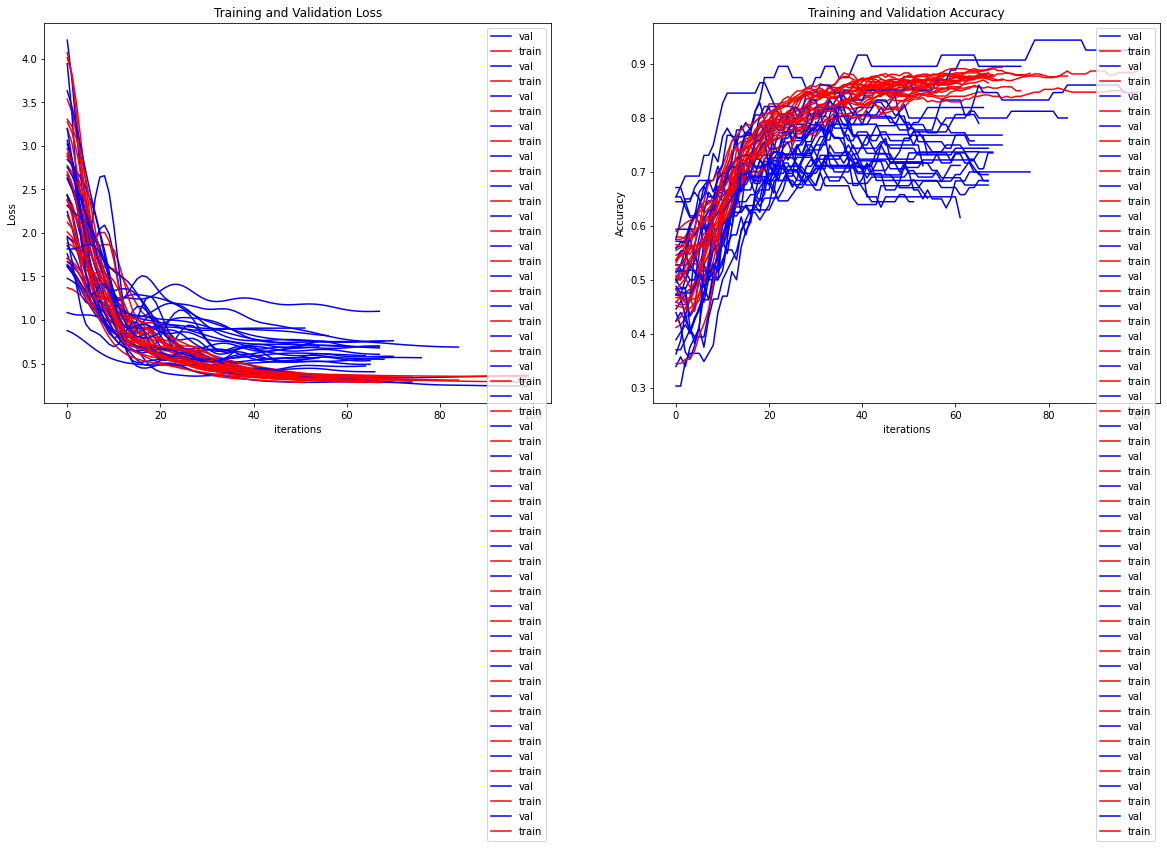

In [ ]:
n_val = 4 
data_folder = '/content/drive/MyDrive/cats'
output_dir = '/content/'
batch_size = 500
n_pca_components = 50
test_loss_tl_pca, test_acc_lt_pca, val_acc_tl_pca=cross_validation_train(data_folder, output_dir, 'dino_vits16', 
                        n_val, batch_size, num_epochs=100, patience=35, lr=0.001, step_size=25, finetune=False, n_pca_components= n_pca_components)

#Results:

In [11]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()
dict ={ 'Resnet18 finetune (1000,64,2)': [78.52, 74.64, 213],
        'Resnet18- TL (1000,64,2)': [0, 68,200],
        'Dino vits16 finetune (1000,64,2)': [72.31, 69.52,199],
        'Dino vits16 + Linear (384,2)':[79.16,72.40, 9.5 ],
        'Dino vits16 + Linear w/PCA (50,2)':[ 79.51, 74.11, 9.5]}
index_names=['0-Mean validation accracy', '1-Mean test accracy', '2-Run time [min]']
table = pd.DataFrame(dict,index=index_names) 
table

,"Resnet18 finetune (1000,64,2)","Resnet18- TL (1000,64,2)","Dino vits16 finetune (1000,64,2)","Dino vits16 + Linear (384,2)","Dino vits16 + Linear w/PCA (50,2)"
0-Mean validation accracy,78.52,0,72.31,79.16,79.51
1-Mean test accracy,74.64,68,69.52,72.40,74.11
2-Run time [min],213.00,0,199.00,9.50,9.50


##Dino vits16: 
* SGD with momentum 0.9
* lr = 0.001
* Lr decay: step_size=10, gamma=np.sqrt(0.1)
* Left- right augmentation
* early stopping: paticence=15

#Finetune: 
* batch_size = 32
* epochs=35

* Mean validation accuracy till 27: 72.31%
* Mean test accuracy till 27: 69.52%
* Saved PyTorch model state to  /content/drive/MyDrive/models/model26_cat30_test_ac54.pth

Cross validation finished, time elappsed 199m  20s

#Transfer learning:

knn: ?

linear without pca(384 features):
* Mean validation accuracy till 27: 79.16%
* Mean test accuracy till 27: 72.40%
* Saved PyTorch model state to  /content/drive/MyDrive/models/model26_cat30_test_ac64.pth

Cross validation finished, time elappsed 9m  39s

linear with pca (50 features):  
* Mean validation accuracy till 27: 79.51%
* Mean test accuracy till 27: 74.11%
* Saved PyTorch model state to  /content/drive/MyDrive/models/model26_cat30_test_ac61.pth
Cross validation finished, time elappsed 9m  36s



###Resnet18: 
Parameters - full run (27 cats):
Resnet18:
* seed = 42
* batch_size_tl = 4
* SGD with momentum 0.9
* lr = 0.0001
* Lr decay: step_size=10, gamma=np.sqrt(0.1)
* epochs=35
* Left- right augmentation
* early stopping: paticence=15

Finetune:
* Mean validation accuracy till 27: 78.52%
* Mean test accuracy till 27: 74.64%
* Saved PyTorch model state to  /content/drive/MyDrive/models/model26_cat30_test_ac61.pth
Cross validation finished, time elappsed 213m  6s

Transfer learning (24 cats):
* Test: 68.5%
* Need to run again with larger learning rate



##To do:
* Run renset transfer learning with lr= 3*10^-4, 10^-4 - Itai
* Summary table, KNN cross validation - Tamar
* Possible comparison: 2 layers, vitb16, Adam vs SGD optimization, binary cross entropy loss. 
* Remove bad cats from data set
* Test with other cats which where unbalanced
* Brightness augmentation
* visualization of results
